In [1]:
## Importing libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()

In [2]:
match_lvl_data = pd.read_csv('/Users/alokroy/Documents/Programming/Projects/Amex/data/main/664389efa0868_match_level_scorecard.csv')
batsman_lvl_data = pd.read_csv('/Users/alokroy/Documents/Programming/Projects/Amex/data/main/663e2b548c98c_batsman_level_scorecard.csv')
bowler_lvl_data = pd.read_csv('/Users/alokroy/Documents/Programming/Projects/Amex/data/main/663e2b2c60743_bowler_level_scorecard.csv')
train_data = pd.read_csv('/Users/alokroy/Documents/Programming/Projects/Amex/data/main/663e2b6d54457_train_data_with_samplefeatures.csv')
test_data = pd.read_csv('/Users/alokroy/Documents/Programming/Projects/Amex/data/main/6644a1e287df6_test_data_with_samplefeatures.csv')

In [3]:
## Creating a binary winner column - 0 if team1 wins, else 1
train_data['winner_01'] = train_data.apply(lambda x: 0 if (x['team1']==x['winner']) else 1, axis=1)

In [4]:
def giveLastNgamesPlayer(player_id, date, n, bat_or_bowl):
    '''
    Function to get last n games stats of a player before an input date.

    Input-
    1. player_id: id of the player to get historical data.
    2. date: date to look-back and get n games. Stats returned are before this input date.
    3. n: Number of historical games stats to return.
    4. bat_or_bowl: Kind of stats to return. {'bat': batting stats to return, 'bowl': bowling stats to return}

    Output-None

    Returns- dataframe having bowling/batting stats from last n games of a player before an input date.
    The results are sorted by date.
    '''
    if bat_or_bowl == 'bat':
        df_topick = batsman_lvl_data
        id_col = 'batsman_id'
    else:
        df_topick = bowler_lvl_data
        id_col = 'bowler_id'

    return df_topick[(df_topick['match_dt']<date)&(df_topick[id_col]==float(player_id))]\
                .sort_values(by='match_dt', ascending=False).head(n)

In [5]:
def calculate_ratio(row, col1, col2):
    value1 = row[col1]
    value2 = row[col2]
    if value2 == 0:
        return value1
    else:
        return value1 / value2

# Function to add a ratio column for any two columns
def add_ratio_column(df, col1, col2, new_col_name):
    df[new_col_name] = df.apply(lambda row: calculate_ratio(row, col1, col2), axis=1)
    return df

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pandas as pd

def check_distribution_match(train_feature, test_feature):
    """
    Checks and visualizes if the distributions of a feature in the train and test datasets match.

    Args:
    train_feature (pd.Series): Feature data from the training dataset.
    test_feature (pd.Series): Feature data from the testing dataset.
    """

    # Visualizing distributions with histograms
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(train_feature, bins=30, alpha=0.5, color='blue', label='Train', density=True)
    plt.hist(test_feature, bins=30, alpha=0.5, color='red', label='Test', density=True)
    plt.legend(loc='upper right')
    plt.title('Histogram Comparison')

    # Density plot comparison
    plt.subplot(1, 2, 2)
    sns.kdeplot(train_feature, label='Train', fill=True, color='blue')
    sns.kdeplot(test_feature, label='Test', fill=True, color='red')
    plt.legend()
    plt.title('Density Plot Comparison')
    plt.tight_layout()
    plt.show()

    # Statistical test - Kolmogorov-Smirnov Test
    ks_stat, ks_pvalue = stats.ks_2samp(train_feature, test_feature)
    print(f"Kolmogorov-Smirnov test result: KS statistic = {ks_stat:.4f}, p-value = {ks_pvalue:.4f}")

    # Additional insights from descriptive statistics
    compare_stats = pd.DataFrame({
        'Train Stats': train_feature.describe(),
        'Test Stats': test_feature.describe()
    })
    print("\nDescriptive Statistics Comparison:")
    print(compare_stats)

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re

# Set seaborn style
sns.set(style="whitegrid")

def createRnP(X_12, feature, N=5, ylim_lb=0.3, ylim_ub=0.7):
    '''
    Rank and Plot of input feature on the input data. The y-axis shows %team1 wins in each bucket.
    
    Parameters-
    1. X_12: dataset to build the RnP on. 
    2. feature: Feature to build RnP of.
    3. N: number of bins on x-axis. Default 5.
    4. ylim_lb: lower bound of y axis on plot.
    5. ylim_ub: upper bound of y axis on plot.
    
    Output-
    1. Rank and Plot
    
    Returns- None
    '''
    df = X_12.copy()
    df[f'{feature}_bin'] = df[feature].rank(pct=True)//(1/N) # divide feature values for all games in 5 equi-volume buckets.
    df['count'] = 1
    df['team1_win%'] = df['winner_01'].apply(lambda x: 1-x) # invert winner_01 to get team1 winner indicator
    df['team2_win%'] = df['winner_01'].copy()
    df[f'{feature}_min'] = df[feature].copy()
    df[f'{feature}_max'] = df[feature].copy()
    df_g = df.groupby(f'{feature}_bin').agg({'team1_win%':'mean', 'team2_win%':'mean', 'count':'sum', f'{feature}_min':'min',\
                                            f'{feature}_max':'max'}).reset_index()
    N = min(N,df_g.shape[0])
    blue_bar = df_g['team1_win%'].values.tolist()
    ind = np.arange(N)
    # plotting starts
    plt.figure(figsize=(10,5));
    plt.bar(ind, blue_bar, label='Team 1 win%');
    plt.axhline(y=0.5, linewidth=0.5, color='k', linestyle = '--')
    xlabel = re.sub('team_','ratio_',feature)
    plt.xlabel(f'{xlabel} (team1 / team2) bins');
    plt.ylabel('Win %');
    plt.title(f'RnP - {feature} vs win');
    df_g['xticks'] = df_g.apply(lambda x: str(round(x[f'{feature}_min'],2)) + ' - ' + str(round(x[f'{feature}_max'],2)), axis=1)
    plt.xticks(ind, df_g['xticks']);
    plt.ylim([ylim_lb,ylim_ub]);
    plt.legend(loc='best');
    x2,x1 = blue_bar[-1],blue_bar[0]
    slope = x2/x1
    if slope < 1:
        slope = 1/slope
        x1,x2 = x2,x1
    print('slope:', round(x2,2),'/',round(x1,2), '= ',round(slope,2))
    plt.show();
    
    correlation = df['winner_01'].corr(df[feature])
    print(f"Correlation between {feature} and winner_01 is: {correlation}") 

In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import QuantileTransformer

transformers = {}

def remove_skew(df, feature, method='sqrt', train=True):
    skew = df[feature].skew()
    if method == 'sqrt':
        df[feature] = np.sqrt(df[feature] + np.finfo(float).eps)  
        transformation = 'square root'
    
    elif method == 'log':
        df[feature] = np.log1p(df[feature])
        transformation = 'log'
    
    elif method == 'quantile':
        if train:
            transformer = QuantileTransformer(output_distribution='normal')
            df[feature] = transformer.fit_transform(df[feature].values.reshape(-1, 1))
            transformers[feature] = transformer 
        else:
            transformer = transformers.get(feature)
            if transformer:
                df[feature] = transformer.transform(df[feature].values.reshape(-1, 1))
            else:
                raise ValueError("Transformer not initialized. Please run on training data first.")
        transformation = 'quantile'
    
    # Print skewness before and after
    new_skew = df[feature].skew()
    print(f"Skewness of {feature} was {skew}. {transformation} transformation applied. New skewness is {new_skew}")
    # print(f"Skewness of {feature} was {skew}. New skewness is {new_skew}")

In [9]:
import pandas as pd

def handle_outliers(data, column_name):
    """
    Identifies and imputes outliers in a specified column of the DataFrame using the IQR method,
    replacing them with the maximum value of the non-outlier data.

    Parameters:
    data (pd.DataFrame): The DataFrame containing the data.
    column_name (str): The name of the column to check for outliers.

    Returns:
    pd.DataFrame: The DataFrame with outliers in the specified column imputed.
    int: The number of identified outliers.
    """
    # Calculate Q1, Q3 and IQR
    Q1 = data[column_name].quantile(0.25)
    Q3 = data[column_name].quantile(0.75)
    IQR = Q3 - Q1

    # Identify outliers
    outliers = data[(data[column_name] < (Q1 - 1.5 * IQR)) | (data[column_name] > (Q3 + 1.5 * IQR))][column_name]
    num_outliers = len(outliers)
    print("Number of outliers:", num_outliers)

    # Calculate the maximum value of the non-outlier data
    max_value = data.loc[~((data[column_name] < (Q1 - 1.5 * IQR)) | (data[column_name] > (Q3 + 1.5 * IQR))), column_name].max()

    # Impute outliers with the maximum value
    data.loc[((data[column_name] < (Q1 - 1.5 * IQR)) | (data[column_name] > (Q3 + 1.5 * IQR))), column_name] = max_value

    return data

## Features

### team_avg_score_ground_ratio

In [10]:
# Function to calculate ground's average score
def avg_score_at_ground(matches, ground_id):
    ground_matches = matches[matches['ground_id'] == ground_id]
    total_scores = ground_matches['inning1_runs'].sum() + ground_matches['inning2_runs'].sum()
    total_matches = len(ground_matches) * 2  # as each match has two innings
    return total_scores / total_matches if total_matches > 0 else 0

# Function to calculate team's average score
def avg_team_score(matches, team_id):
    team_matches = matches[(matches['team1_id'] == team_id) | (matches['team2_id'] == team_id)]
    team_scores = team_matches.apply(lambda x: x['inning1_runs'] if x['team1_id'] == team_id else x['inning2_runs'], axis=1).sum()
    total_innings = len(team_matches) * 2  # as each match has two innings
    return team_scores / total_innings if total_innings > 0 else 0

# Function to calculate ratio of team's avg score to ground's avg score
def team_to_ground_avg_score_ratio(matches, team_id, ground_id):
    ground_avg_score = avg_score_at_ground(matches, ground_id)
    team_avg_score = avg_team_score(matches, team_id)
    return team_avg_score / ground_avg_score if ground_avg_score > 0 else team_avg_score

# Apply to training data
train_data['team1_avg_score_ground_ratio'] = train_data.apply(lambda x: team_to_ground_avg_score_ratio(match_lvl_data, x['team1_id'], x['ground_id']), axis=1)
train_data['team2_avg_score_ground_ratio'] = train_data.apply(lambda x: team_to_ground_avg_score_ratio(match_lvl_data, x['team2_id'], x['ground_id']), axis=1)
train_data = add_ratio_column(train_data, 'team1_avg_score_ground_ratio', 'team2_avg_score_ground_ratio', 'team_avg_score_ground_ratio')

# Drop intermediate columns to avoid redundancy
train_data = train_data.drop(columns=['team1_avg_score_ground_ratio', 'team2_avg_score_ground_ratio'])

# Apply to test data
test_data['team1_avg_score_ground_ratio'] = test_data.apply(lambda x: team_to_ground_avg_score_ratio(match_lvl_data, x['team1_id'], x['ground_id']), axis=1)
test_data['team2_avg_score_ground_ratio'] = test_data.apply(lambda x: team_to_ground_avg_score_ratio(match_lvl_data, x['team2_id'], x['ground_id']), axis=1)
test_data = add_ratio_column(test_data, 'team1_avg_score_ground_ratio', 'team2_avg_score_ground_ratio', 'team_avg_score_ground_ratio')

# Drop intermediate columns to avoid redundancy
test_data = test_data.drop(columns=['team1_avg_score_ground_ratio', 'team2_avg_score_ground_ratio'])

slope: 0.6 / 0.31 =  1.92


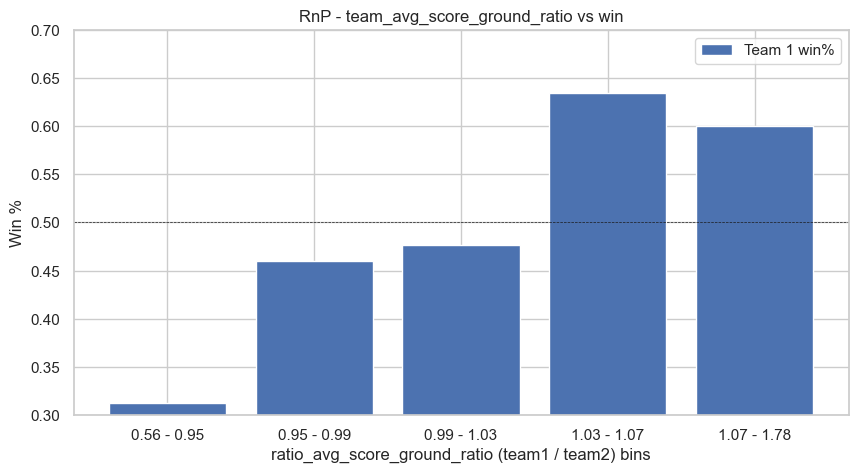

Correlation between team_avg_score_ground_ratio and winner_01 is: -0.2123613545271719


In [11]:
createRnP(train_data, 'team_avg_score_ground_ratio')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


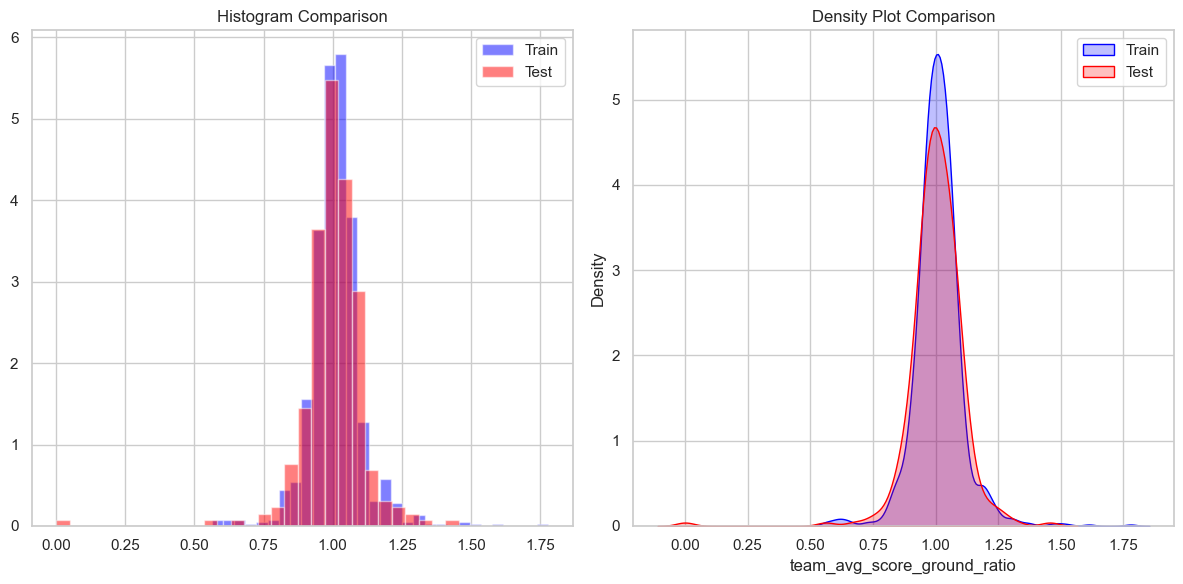

Kolmogorov-Smirnov test result: KS statistic = 0.0631, p-value = 0.3530

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.010332    1.002811
std       0.097821    0.112144
min       0.561952    0.000000
25%       0.965461    0.956411
50%       1.009148    1.001715
75%       1.054772    1.058152
max       1.779512    1.456676


In [12]:
check_distribution_match(train_data['team_avg_score_ground_ratio'], test_data['team_avg_score_ground_ratio'])

### avg_score_ground_batting_first_ratio

In [13]:
def avg_score_at_ground(matches, ground_id):
    ground_matches = matches[matches['ground_id'] == ground_id]
    total_scores = ground_matches['inning1_runs'].sum() + ground_matches['inning2_runs'].sum()
    total_matches = len(ground_matches) * 2  # as each match has two innings
    return total_scores / total_matches if total_matches > 0 else 0

# Function to calculate team's average score
def avg_team_score(matches, team_id):
    team_matches = matches[(matches['team1_id'] == team_id) | (matches['team2_id'] == team_id)]
    team_scores = team_matches.apply(lambda x: x['inning1_runs'] if x['team1_id'] == team_id else x['inning2_runs'], axis=1).sum()
    total_innings = len(team_matches) * 2  # as each match has two innings
    return team_scores / total_innings if total_innings > 0 else 0


# Function to calculate team's average score when batting first
def avg_team_score_batting_first(matches, team_id):
    team_matches = matches[matches['team1_id'] == team_id]
    team_scores = team_matches['inning1_runs'].sum()
    total_innings = len(team_matches)
    return team_scores / total_innings if total_innings > 0 else 0

# Function to calculate team's average score when fielding first
def avg_team_score_fielding_first(matches, team_id):
    team_matches = matches[matches['team2_id'] == team_id]
    team_scores = team_matches['inning2_runs'].sum()
    total_innings = len(team_matches)
    return team_scores / total_innings if total_innings > 0 else 0

# Function to calculate ratio of team's avg score to ground's avg score (batting first)
def team_to_ground_avg_score_ratio_batting_first(matches, team_id, ground_id):
    ground_avg_score = avg_score_at_ground(matches, ground_id)
    team_avg_score = avg_team_score_batting_first(matches, team_id)
    return team_avg_score / ground_avg_score if ground_avg_score > 0 else team_avg_score

# Function to calculate ratio of team's avg score to ground's avg score (fielding first)
def team_to_ground_avg_score_ratio_fielding_first(matches, team_id, ground_id):
    ground_avg_score = avg_score_at_ground(matches, ground_id)
    team_avg_score = avg_team_score_fielding_first(matches, team_id)
    return team_avg_score / ground_avg_score if ground_avg_score > 0 else team_avg_score

# Apply to training data
train_data['team1_avg_score_ground_batting_first_ratio'] = train_data.apply(lambda x: team_to_ground_avg_score_ratio_batting_first(match_lvl_data, x['team1_id'], x['ground_id']), axis=1)
train_data['team2_avg_score_ground_batting_first_ratio'] = train_data.apply(lambda x: team_to_ground_avg_score_ratio_batting_first(match_lvl_data, x['team2_id'], x['ground_id']), axis=1)
# train_data['team1_avg_score_ground_fielding_first_ratio'] = train_data.apply(lambda x: team_to_ground_avg_score_ratio_fielding_first(match_lvl_data, x['team1_id'], x['ground_id']), axis=1)
# train_data['team2_avg_score_ground_fielding_first_ratio'] = train_data.apply(lambda x: team_to_ground_avg_score_ratio_fielding_first(match_lvl_data, x['team2_id'], x['ground_id']), axis=1)

train_data = add_ratio_column(train_data, 'team1_avg_score_ground_batting_first_ratio', 'team2_avg_score_ground_batting_first_ratio', 'avg_score_ground_batting_first_ratio')
# train_data = add_ratio_column(train_data, 'team1_avg_score_ground_fielding_first_ratio', 'team2_avg_score_ground_fielding_first_ratio', 'avg_score_ground_fielding_first_ratio')

# Drop intermediate columns to avoid redundancy
train_data = train_data.drop(columns=['team1_avg_score_ground_batting_first_ratio', 'team2_avg_score_ground_batting_first_ratio'])

# Apply to test data
test_data['team1_avg_score_ground_batting_first_ratio'] = test_data.apply(lambda x: team_to_ground_avg_score_ratio_batting_first(match_lvl_data, x['team1_id'], x['ground_id']), axis=1)
test_data['team2_avg_score_ground_batting_first_ratio'] = test_data.apply(lambda x: team_to_ground_avg_score_ratio_batting_first(match_lvl_data, x['team2_id'], x['ground_id']), axis=1)
# test_data['team1_avg_score_ground_fielding_first_ratio'] = test_data.apply(lambda x: team_to_ground_avg_score_ratio_fielding_first(match_lvl_data, x['team1_id'], x['ground_id']), axis=1)
# test_data['team2_avg_score_ground_fielding_first_ratio'] = test_data.apply(lambda x: team_to_ground_avg_score_ratio_fielding_first(match_lvl_data, x['team2_id'], x['ground_id']), axis=1)

test_data = add_ratio_column(test_data, 'team1_avg_score_ground_batting_first_ratio', 'team2_avg_score_ground_batting_first_ratio', 'avg_score_ground_batting_first_ratio')
# test_data = add_ratio_column(test_data, 'team1_avg_score_ground_fielding_first_ratio', 'team2_avg_score_ground_fielding_first_ratio', 'avg_score_ground_fielding_first_ratio')

# Drop intermediate columns to avoid redundancy
test_data = test_data.drop(columns=['team1_avg_score_ground_batting_first_ratio', 'team2_avg_score_ground_batting_first_ratio'])

slope: 0.63 / 0.33 =  1.92


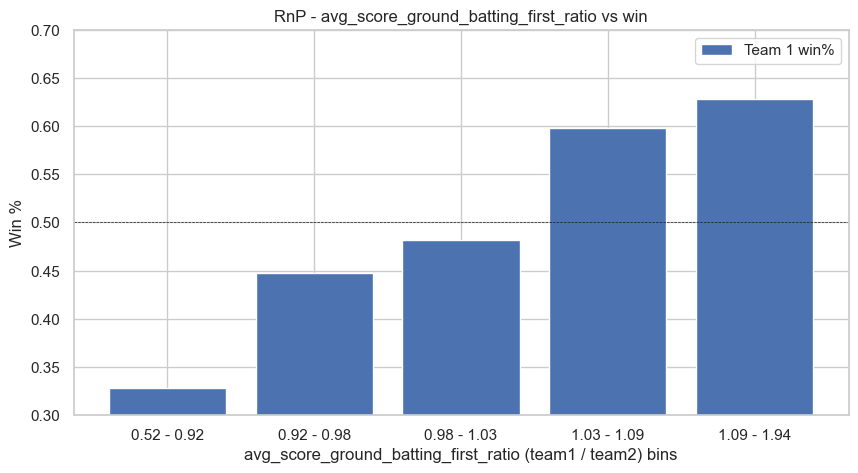

Correlation between avg_score_ground_batting_first_ratio and winner_01 is: -0.20373240248923474


In [14]:
createRnP(train_data, 'avg_score_ground_batting_first_ratio')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


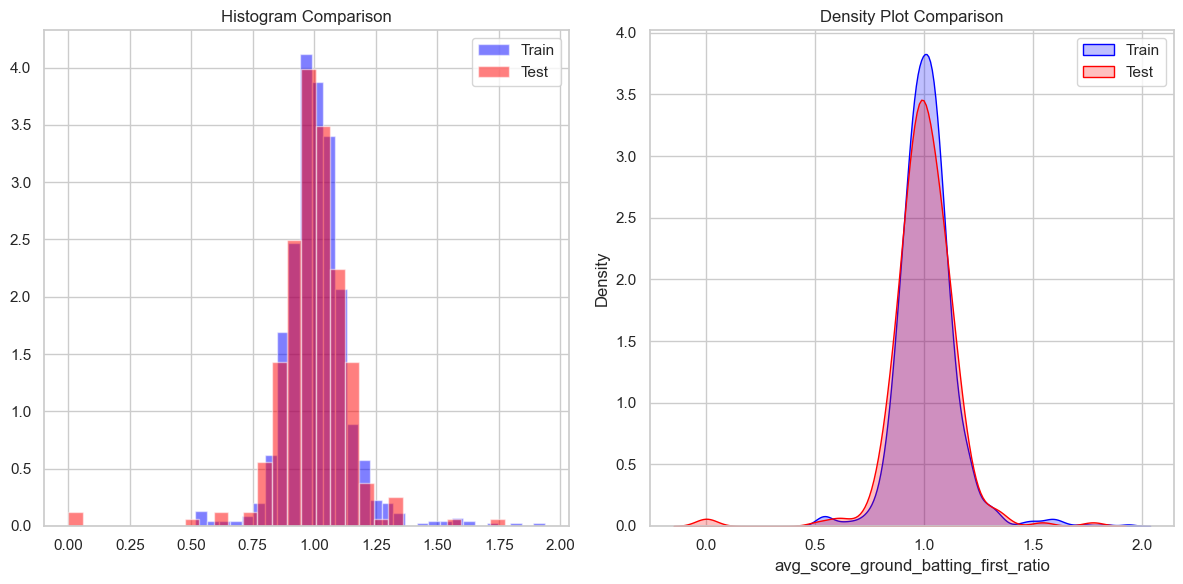

Kolmogorov-Smirnov test result: KS statistic = 0.0498, p-value = 0.6495

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.011611    0.997932
std       0.131546    0.153532
min       0.516104    0.000000
25%       0.941754    0.934434
50%       1.008732    0.994149
75%       1.069335    1.073235
max       1.937595    1.774919


In [15]:
check_distribution_match(train_data['avg_score_ground_batting_first_ratio'], test_data['avg_score_ground_batting_first_ratio'])

### match_experience_score_ratio

In [16]:
# Function to calculate match experience score
def match_experience_score(matches, team_roster_ids, date):
    team_ids = str(team_roster_ids).split(':')
    total_experience_score = 0

    for player_id in team_ids:
        player_matches = matches[(matches['match_dt'] < date) & ((matches['team1_roster_ids'].str.contains(player_id)) | (matches['team2_roster_ids'].str.contains(player_id)))]
        total_experience_score += player_matches.shape[0]

    return total_experience_score

# Apply to training data
train_data['team1_match_experience_score'] = train_data.apply(lambda x: match_experience_score(match_lvl_data, x['team1_roster_ids'], x['match_dt']), axis=1)
train_data['team2_match_experience_score'] = train_data.apply(lambda x: match_experience_score(match_lvl_data, x['team2_roster_ids'], x['match_dt']), axis=1)
train_data = add_ratio_column(train_data, 'team1_match_experience_score', 'team2_match_experience_score', 'match_experience_score_ratio')

# Drop intermediate columns to avoid redundancy
train_data = train_data.drop(columns=['team1_match_experience_score', 'team2_match_experience_score'])

# Apply to test data
test_data['team1_match_experience_score'] = test_data.apply(lambda x: match_experience_score(match_lvl_data, x['team1_roster_ids'], x['match_dt']), axis=1)
test_data['team2_match_experience_score'] = test_data.apply(lambda x: match_experience_score(match_lvl_data, x['team2_roster_ids'], x['match_dt']), axis=1)
test_data = add_ratio_column(test_data, 'team1_match_experience_score', 'team2_match_experience_score', 'match_experience_score_ratio')

# Drop intermediate columns to avoid redundancy
test_data = test_data.drop(columns=['team1_match_experience_score', 'team2_match_experience_score'])

slope: 0.62 / 0.32 =  1.96


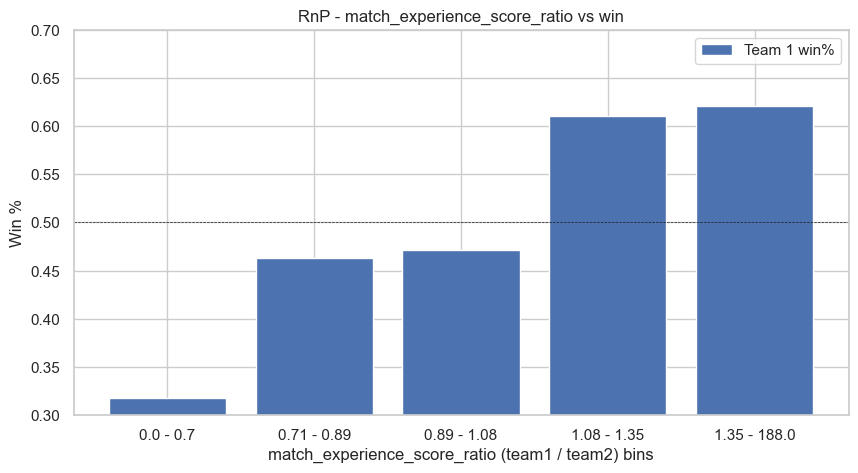

Correlation between match_experience_score_ratio and winner_01 is: -0.06841510458819834


In [17]:
createRnP(train_data, 'match_experience_score_ratio') 

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


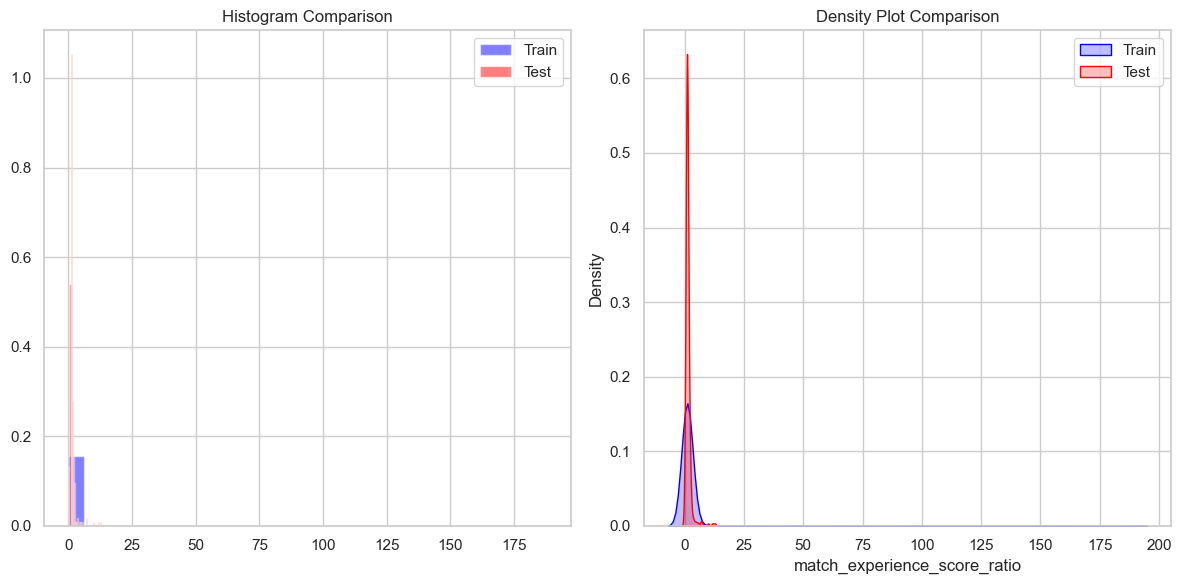

Kolmogorov-Smirnov test result: KS statistic = 0.0798, p-value = 0.1287

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.801553    1.307881
std       9.161932    1.365106
min       0.000000    0.000000
25%       0.756502    0.808865
50%       0.981857    1.029412
75%       1.258992    1.305643
max     188.000000   12.714286


In [18]:
check_distribution_match(train_data['match_experience_score_ratio'], test_data['match_experience_score_ratio'])

In [19]:
# train_data = handle_outliers(train_data, 'match_experience_score_ratio')
# test_data = handle_outliers(test_data, 'match_experience_score_ratio')

remove_skew(train_data, 'match_experience_score_ratio', method='quantile', train=True)
remove_skew(test_data, 'match_experience_score_ratio', method='quantile', train=False)

Skewness of match_experience_score_ratio was 16.198769310265217. quantile transformation applied. New skewness is -0.7827699526142451
Skewness of match_experience_score_ratio was 5.516448366174592. quantile transformation applied. New skewness is -0.7713313789954136


/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2667: UserWarning: n_quantiles (1000) is greater than the total number of samples (948). n_quantiles is set to n_samples.
  warnings.warn(


slope: 0.62 / 0.32 =  1.96


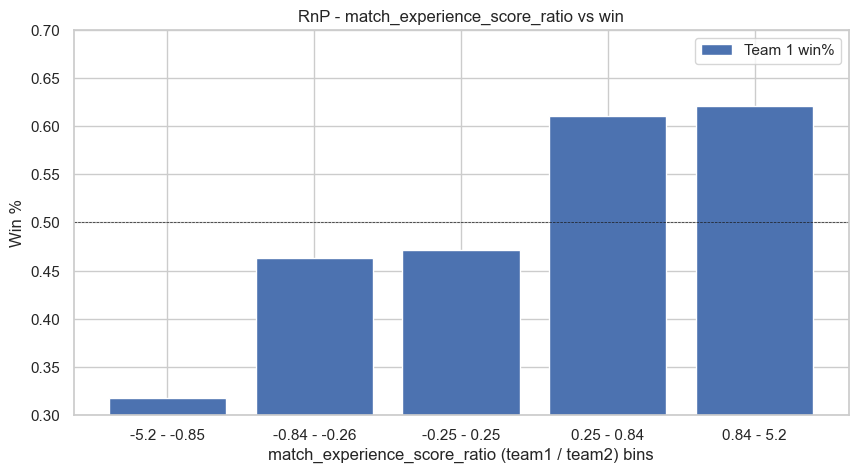

Correlation between match_experience_score_ratio and winner_01 is: -0.21913067135993403


In [20]:
createRnP(train_data, 'match_experience_score_ratio')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


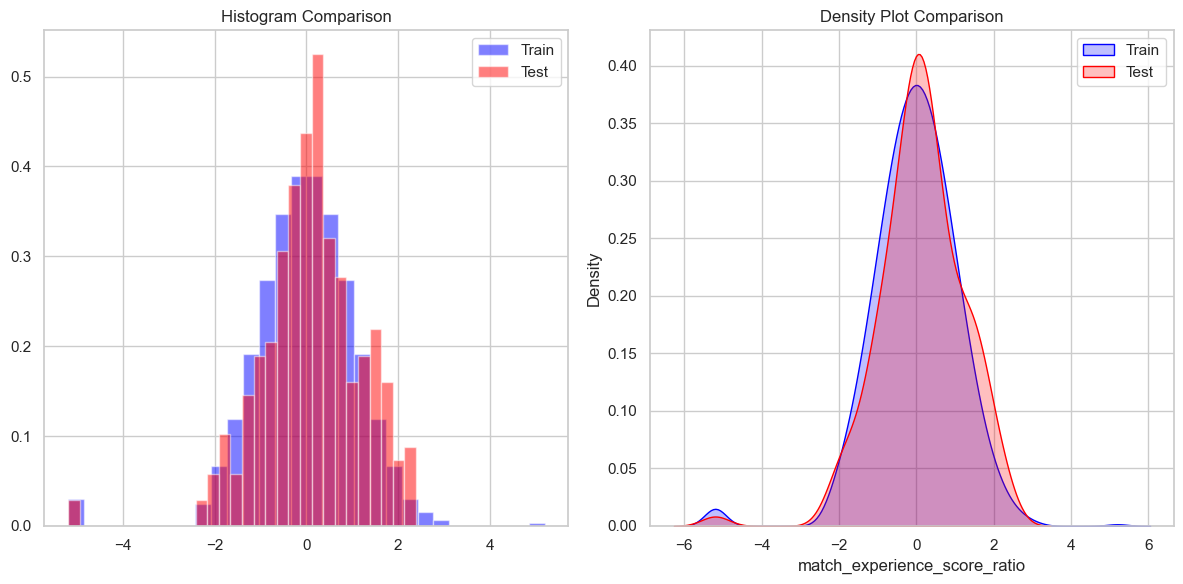

Kolmogorov-Smirnov test result: KS statistic = 0.0798, p-value = 0.1287

Descriptive Statistics Comparison:
        Train Stats  Test Stats
count  9.480000e+02  271.000000
mean  -2.452667e-02    0.113003
std    1.111034e+00    1.094711
min   -5.199338e+00   -5.199338
25%   -6.744904e-01   -0.486911
50%   -1.392116e-16    0.117208
75%    6.744904e-01    0.764327
max    5.199338e+00    2.389431


In [21]:
check_distribution_match(train_data['match_experience_score_ratio'], test_data['match_experience_score_ratio'])

### team_count_50runs_last15

In [22]:
def no50sLastn(player_list, date, n):

    player_list = str(player_list).split(':')
    res_list = []

    for player in player_list:
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bat') 
        df_rel['gte_50runs'] = np.where(df_rel['runs']>=50, 1, 0) 
        res_list.append(np.nansum(df_rel['gte_50runs']))
        
    return np.nansum(res_list)

train_data['team1_count_50runs_last15'] = train_data.progress_apply(lambda x: \
            no50sLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data['team2_count_50runs_last15'] = train_data.progress_apply(lambda x: \
            no50sLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data = add_ratio_column(train_data, 'team1_count_50runs_last15', 'team2_count_50runs_last15', 'team_count_50runs_last15')

train_data = train_data.drop(columns=['team1_count_50runs_last15', 'team2_count_50runs_last15'])

test_data['team1_count_50runs_last15'] = test_data.progress_apply(lambda x: \
            no50sLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data['team2_count_50runs_last15'] = test_data.progress_apply(lambda x: \
            no50sLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data = add_ratio_column(test_data, 'team1_count_50runs_last15', 'team2_count_50runs_last15', 'team_count_50runs_last15')

# Drop the initial individual features
test_data = test_data.drop(columns=['team1_count_50runs_last15', 'team2_count_50runs_last15'])

100%|██████████| 271/271 [00:04<00:00, 54.42it/s]


slope: 0.6 / 0.39 =  1.53


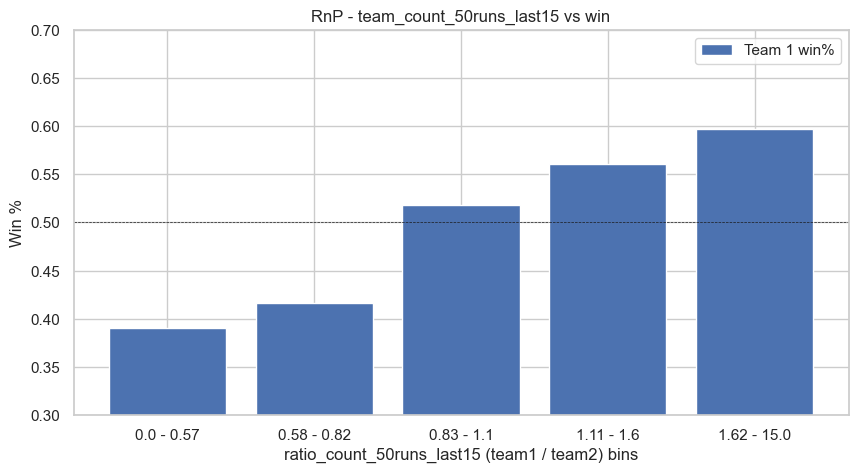

Correlation between team_count_50runs_last15 and winner_01 is: -0.11632710368127931


In [23]:
createRnP(train_data, 'team_count_50runs_last15')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


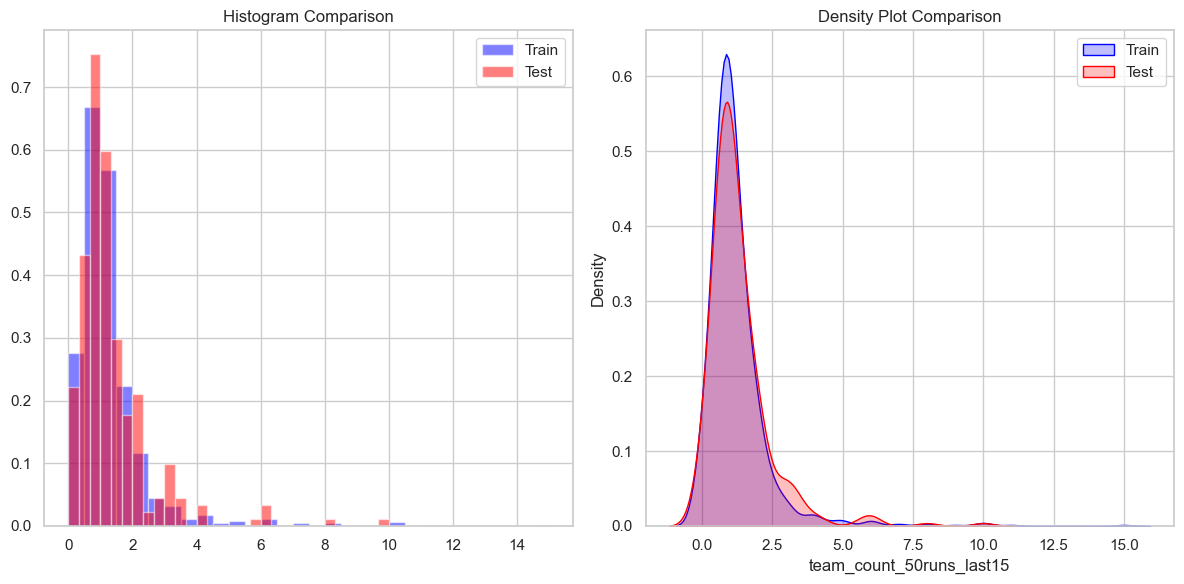

Kolmogorov-Smirnov test result: KS statistic = 0.0578, p-value = 0.4595

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.222363    1.303374
std       1.224666    1.180753
min       0.000000    0.000000
25%       0.636364    0.685855
50%       1.000000    1.000000
75%       1.446970    1.563492
max      15.000000   10.000000


In [24]:
check_distribution_match(train_data['team_count_50runs_last15'], test_data['team_count_50runs_last15'])

In [25]:
remove_skew(train_data, 'team_count_50runs_last15', method='sqrt')
remove_skew(test_data, 'team_count_50runs_last15', method='sqrt')

Skewness of team_count_50runs_last15 was 4.704864290536163. square root transformation applied. New skewness is 0.9991356907137633
Skewness of team_count_50runs_last15 was 3.3175332522300485. square root transformation applied. New skewness is 0.7858804038946939


slope: 0.6 / 0.39 =  1.53


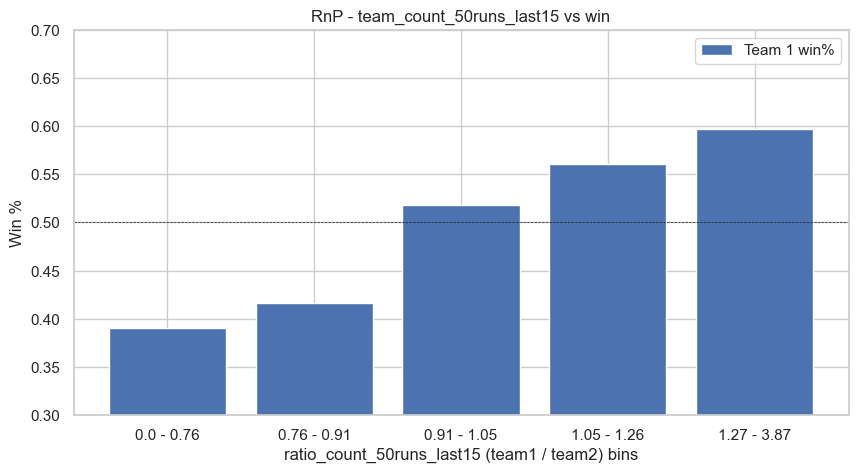

Correlation between team_count_50runs_last15 and winner_01 is: -0.1478596124198269


In [26]:
createRnP(train_data, 'team_count_50runs_last15')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


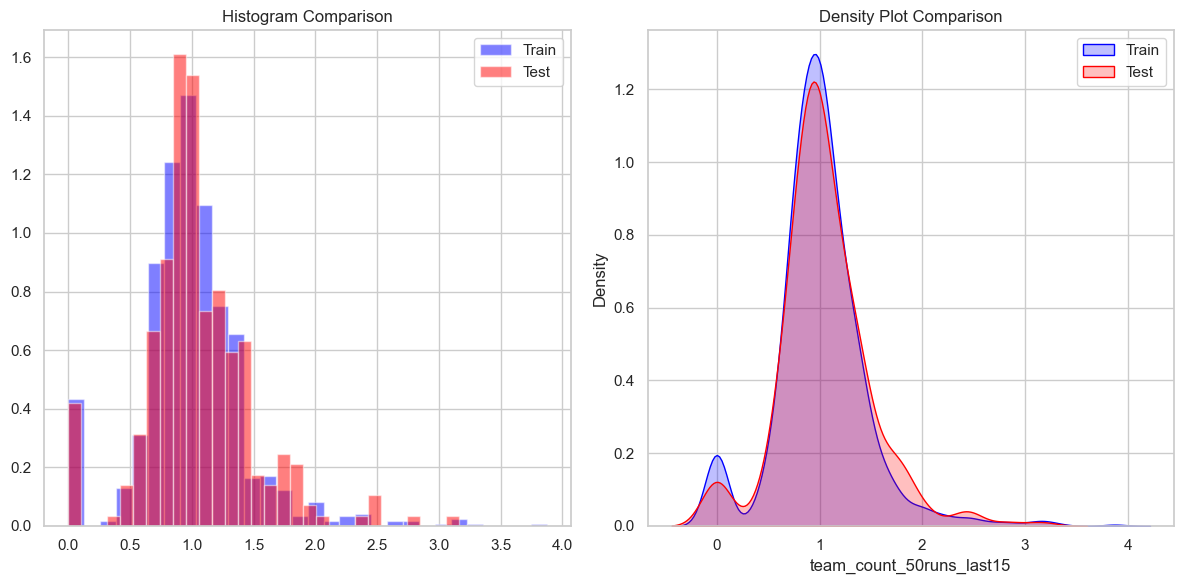

Kolmogorov-Smirnov test result: KS statistic = 0.0578, p-value = 0.4595

Descriptive Statistics Comparison:
        Train Stats    Test Stats
count  9.480000e+02  2.710000e+02
mean   1.009808e+00  1.050375e+00
std    4.504063e-01  4.481367e-01
min    1.490116e-08  1.490116e-08
25%    7.977240e-01  8.281632e-01
50%    1.000000e+00  1.000000e+00
75%    1.202899e+00  1.250393e+00
max    3.872983e+00  3.162278e+00


In [27]:
check_distribution_match(train_data['team_count_50runs_last15'], test_data['team_count_50runs_last15'])

### team_match_impact_score

In [28]:
def match_impact_score(player_list, date, n):
    player_list = player_list.split(':')
    total_impact_score = 0
    count = 0

    for player in player_list:
        player_matches = giveLastNgamesPlayer(player_id=player, date=date, n = n, bat_or_bowl='bat')
        if not player_matches.empty:
            avg_runs = player_matches['runs'].mean()
            avg_strike_rate = player_matches['strike_rate'].mean()
            top_scorer_count = sum(player_matches['runs'] == player_matches.groupby('match id')['runs'].transform('max'))

            impact_score = (avg_runs * avg_strike_rate * top_scorer_count) / 100
            total_impact_score += impact_score
            count += 1

    return total_impact_score / count if count > 0 else 0

train_data['team1_match_impact_score'] = train_data.progress_apply(lambda x: \
            match_impact_score(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data['team2_match_impact_score'] = train_data.progress_apply(lambda x: \
            match_impact_score(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data = add_ratio_column(train_data, 'team1_match_impact_score', 'team2_match_impact_score', 'team_match_impact_score')

train_data = train_data.drop(columns=['team1_match_impact_score', 'team2_match_impact_score'])

test_data['team1_match_impact_score'] = test_data.progress_apply(lambda x: \
            match_impact_score(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data['team2_match_impact_score'] = test_data.progress_apply(lambda x: \
            match_impact_score(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data = add_ratio_column(test_data, 'team1_match_impact_score', 'team2_match_impact_score', 'team_match_impact_score')

test_data = test_data.drop(columns=['team1_match_impact_score', 'team2_match_impact_score'])

100%|██████████| 271/271 [00:05<00:00, 52.59it/s]


In [29]:
train_data['team_match_impact_score'].fillna(0, inplace=True)
test_data['team_match_impact_score'].fillna(0, inplace=True)

/var/folders/z7/t3qmw89j637f4y58ls6cb_vh0000gn/T/ipykernel_50413/1843425482.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['team_match_impact_score'].fillna(0, inplace=True)
/var/folders/z7/t3qmw89j637f4y58ls6cb_vh0000gn/T/ipykernel_50413/1843425482.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are settin

slope: 0.64 / 0.37 =  1.76


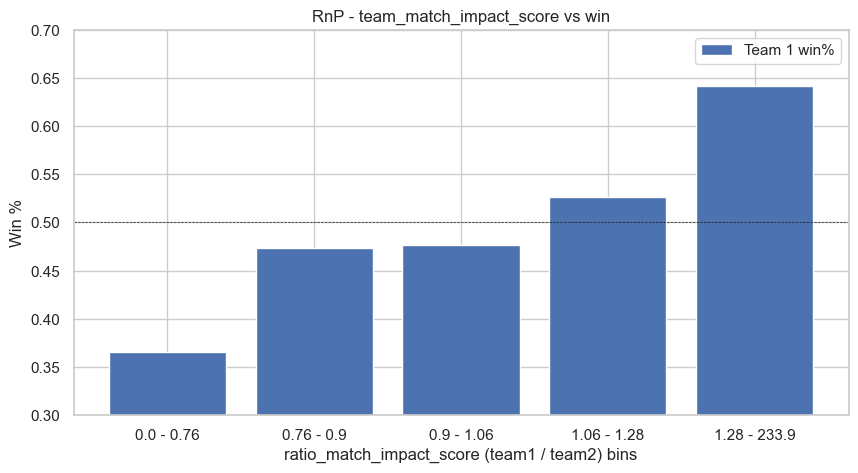

Correlation between team_match_impact_score and winner_01 is: -0.058983246581441606


In [30]:
createRnP(train_data, 'team_match_impact_score')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


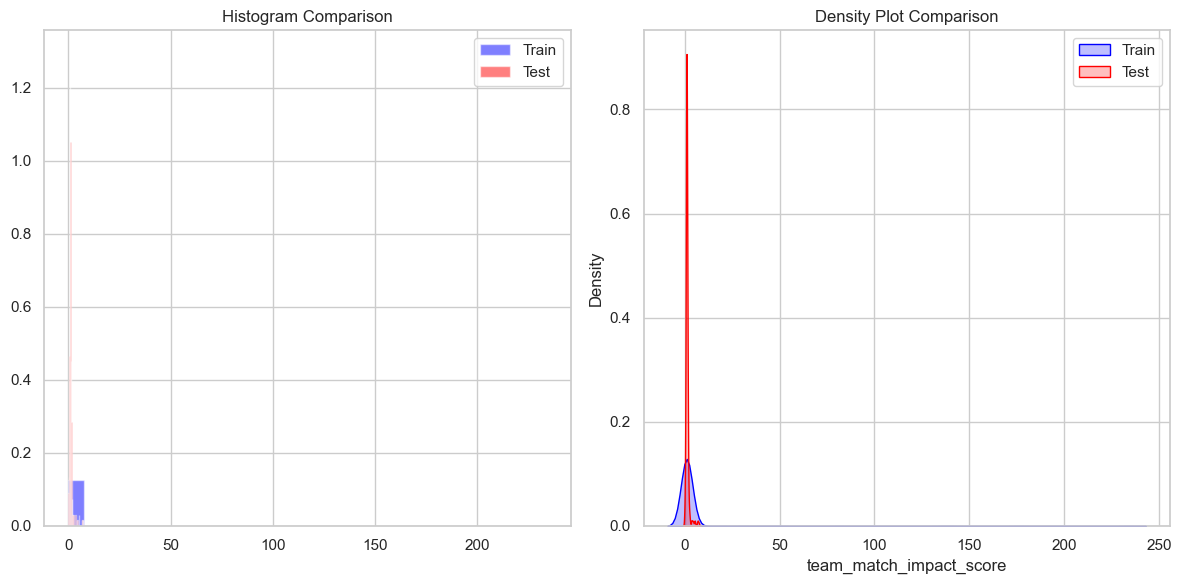

Kolmogorov-Smirnov test result: KS statistic = 0.0445, p-value = 0.7782

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      2.029634    1.159481
std      11.882182    0.884258
min       0.000000    0.000000
25%       0.788809    0.808711
50%       0.988272    0.985984
75%       1.217262    1.230012
max     233.897878    7.362204


In [31]:
check_distribution_match(train_data['team_match_impact_score'], test_data['team_match_impact_score'])

In [32]:
# train_data = handle_outliers(train_data, 'team_match_impact_score')
# test_data = handle_outliers(test_data, 'team_match_impact_score')

remove_skew(train_data, 'team_match_impact_score', method='quantile', train=True)
remove_skew(test_data, 'team_match_impact_score', method='quantile', train=False)

Skewness of team_match_impact_score was 14.805088094345194. quantile transformation applied. New skewness is -1.0752173798684557
Skewness of team_match_impact_score was 4.417290632663462. quantile transformation applied. New skewness is -0.9944141915860719


/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2667: UserWarning: n_quantiles (1000) is greater than the total number of samples (948). n_quantiles is set to n_samples.
  warnings.warn(


/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


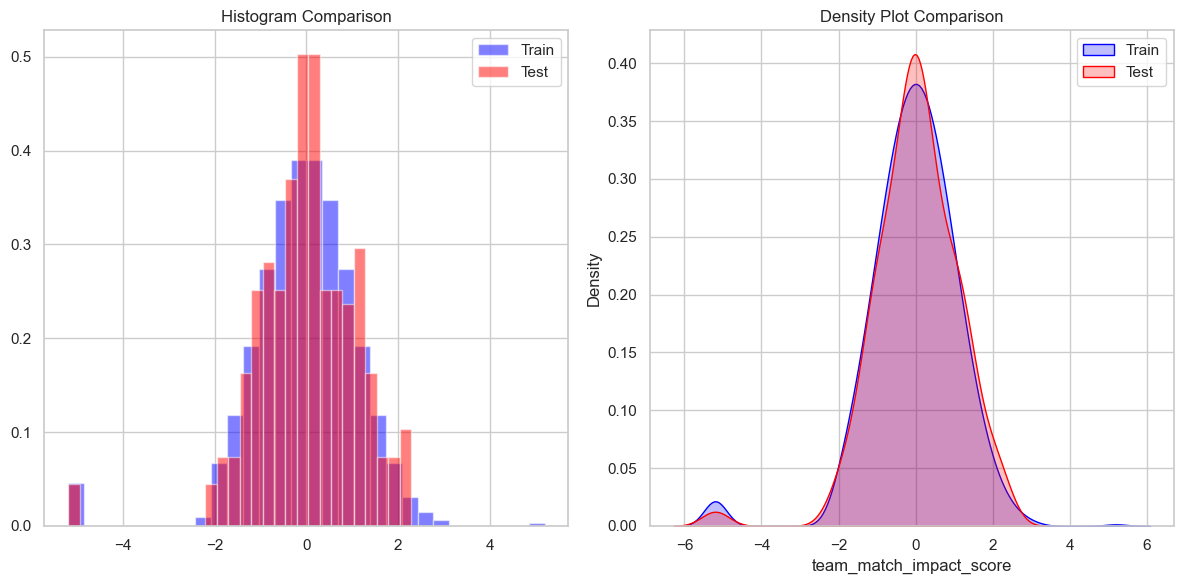

Kolmogorov-Smirnov test result: KS statistic = 0.0445, p-value = 0.7782

Descriptive Statistics Comparison:
        Train Stats  Test Stats
count  9.480000e+02  271.000000
mean  -4.016670e-02    0.010049
std    1.161758e+00    1.098872
min   -5.199338e+00   -5.199338
25%   -6.744904e-01   -0.578200
50%    1.392116e-16   -0.011895
75%    6.744904e-01    0.702572
max    5.199338e+00    2.283557


In [33]:
check_distribution_match(train_data['team_match_impact_score'], test_data['team_match_impact_score'])

slope: 0.64 / 0.37 =  1.76


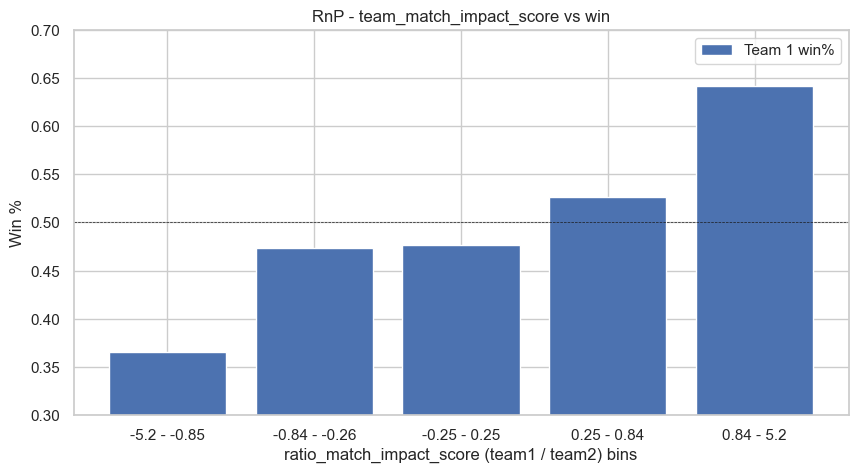

Correlation between team_match_impact_score and winner_01 is: -0.1952741634126559


In [34]:
createRnP(train_data, 'team_match_impact_score')

### team_balls_efficiency_score

In [35]:
def balls_efficiency_score(player_list, date, n):
    """
    Evaluates the mean efficiency of scoring runs based on the number of balls faced for a list of players.
    
    :param player_list: String containing player IDs separated by colons
    :param date: Cut-off date for the games (in the format YYYY-MM-DD)
    :param n: Number of games to consider
    :return: Mean efficiency score (total runs divided by total balls faced) for the list of players
    """
    player_list = player_list.split(':')
    total_runs = 0
    total_balls = 0

    for player in player_list:
        player_matches = giveLastNgamesPlayer(player_id=player, date=date, n = n, bat_or_bowl='bat')
        if not player_matches.empty:
            total_runs += player_matches['runs'].sum()
            total_balls += player_matches['balls_faced'].sum()

    return total_runs / total_balls if total_balls > 0 else 0

train_data['team1_balls_efficiency_score'] = train_data.progress_apply(lambda x: \
            balls_efficiency_score(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data['team2_balls_efficiency_score'] = train_data.progress_apply(lambda x: \
            balls_efficiency_score(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data = add_ratio_column(train_data, 'team1_balls_efficiency_score', 'team2_balls_efficiency_score', 'team_balls_efficiency_score')

train_data = train_data.drop(columns=['team1_balls_efficiency_score', 'team2_balls_efficiency_score'])

test_data['team1_balls_efficiency_score'] = test_data.progress_apply(lambda x: \
            balls_efficiency_score(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data['team2_balls_efficiency_score'] = test_data.progress_apply(lambda x: \
            balls_efficiency_score(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data = add_ratio_column(test_data, 'team1_balls_efficiency_score', 'team2_balls_efficiency_score', 'team_balls_efficiency_score')

test_data = test_data.drop(columns=['team1_balls_efficiency_score', 'team2_balls_efficiency_score'])

100%|██████████| 271/271 [00:04<00:00, 61.91it/s]


slope: 0.62 / 0.39 =  1.59


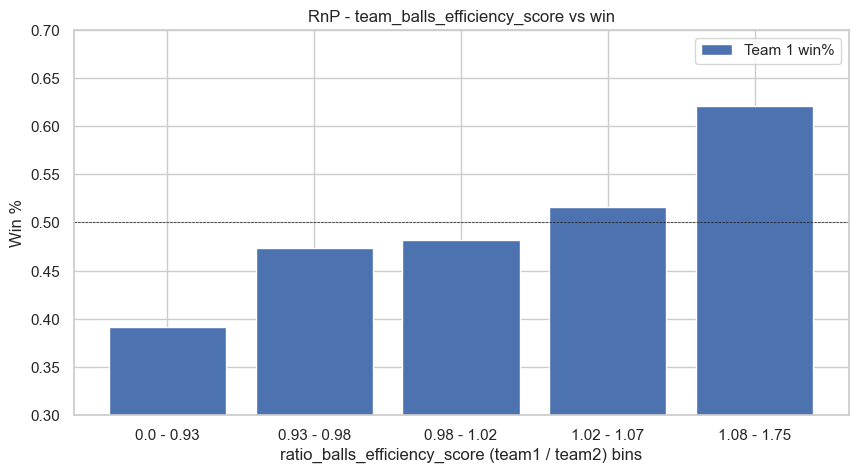

Correlation between team_balls_efficiency_score and winner_01 is: -0.15330782131214032


In [36]:
createRnP(train_data, 'team_balls_efficiency_score')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


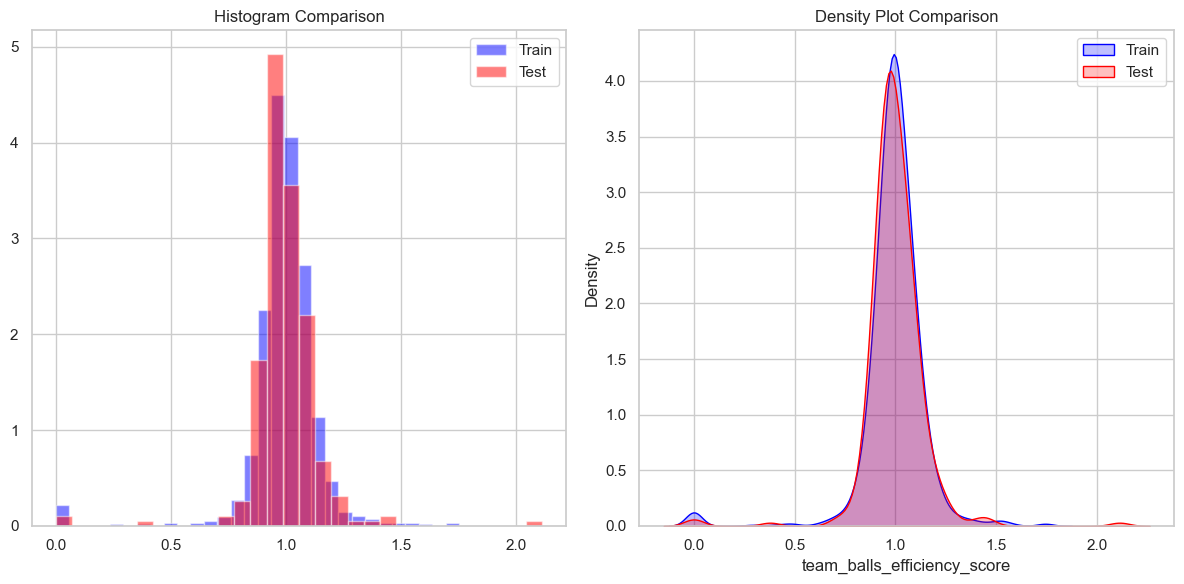

Kolmogorov-Smirnov test result: KS statistic = 0.1000, p-value = 0.0271

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      0.993906    0.996573
std       0.162549    0.153018
min       0.000000    0.000000
25%       0.943062    0.939211
50%       0.998334    0.981431
75%       1.058843    1.054250
max       1.752989    2.112944


In [37]:
check_distribution_match(train_data['team_balls_efficiency_score'], test_data['team_balls_efficiency_score'])

In [38]:
remove_skew(train_data, 'team_balls_efficiency_score', method='quantile')
remove_skew(test_data, 'team_balls_efficiency_score', method='quantile', train=False)

Skewness of team_balls_efficiency_score was -2.546386990395436. quantile transformation applied. New skewness is -0.9104786548959048
Skewness of team_balls_efficiency_score was -0.5195140394922192. quantile transformation applied. New skewness is -0.12444775402423466


/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2667: UserWarning: n_quantiles (1000) is greater than the total number of samples (948). n_quantiles is set to n_samples.
  warnings.warn(


/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


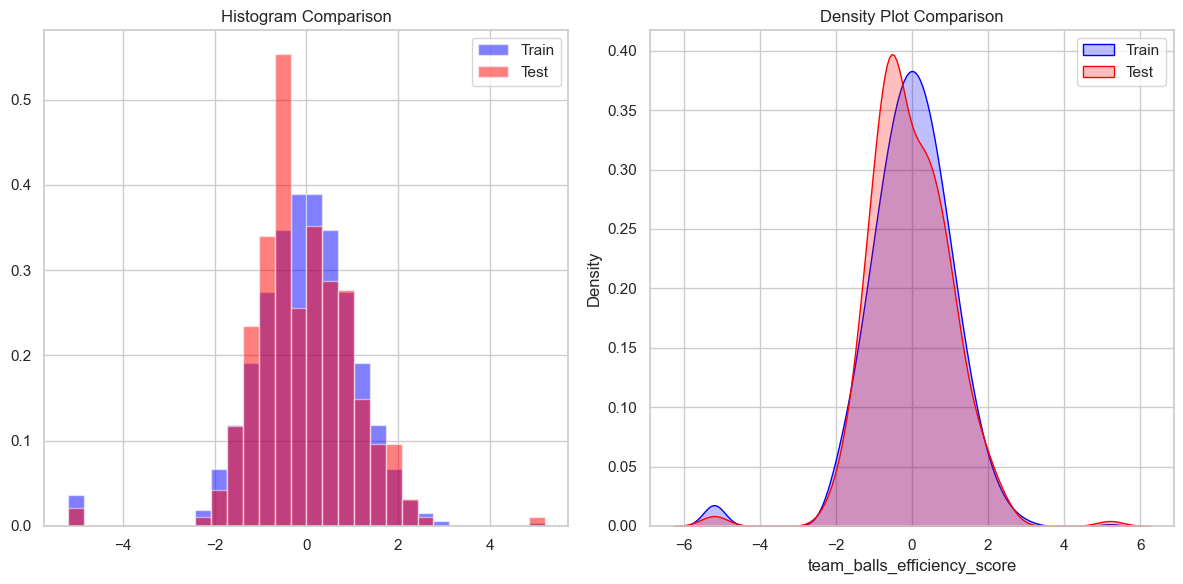

Kolmogorov-Smirnov test result: KS statistic = 0.1000, p-value = 0.0271

Descriptive Statistics Comparison:
        Train Stats  Test Stats
count  9.480000e+02  271.000000
mean  -3.069301e-02   -0.061701
std    1.131428e+00    1.079925
min   -5.199338e+00   -5.199338
25%   -6.744904e-01   -0.730670
50%   -1.392116e-16   -0.223947
75%    6.744904e-01    0.606826
max    5.199338e+00    5.199338


In [39]:
check_distribution_match(train_data['team_balls_efficiency_score'], test_data['team_balls_efficiency_score'])

slope: 0.62 / 0.39 =  1.59


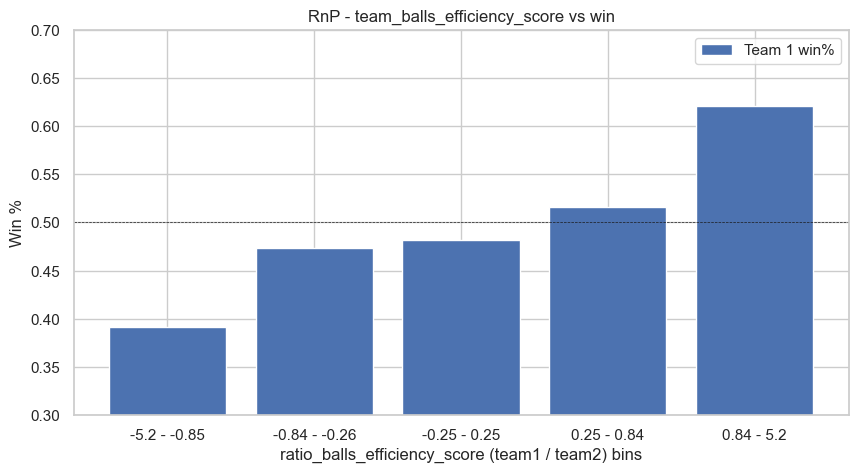

Correlation between team_balls_efficiency_score and winner_01 is: -0.15913865908765945


In [40]:
createRnP(train_data, 'team_balls_efficiency_score')

## Bowler

In [41]:
num_matches = 15

### team_avg_wickets_top5_bowlers

In [42]:
def avg_wickets_top5_bowlers(bowler_df, team_roster_ids, date, n=10):
    team_ids = team_roster_ids.split(':')
    bowlers_wickets = []

    for player_id in team_ids:
        recent_matches = giveLastNgamesPlayer(player_id, date, n, 'bowl')
        if not recent_matches.empty:
            total_wickets = recent_matches['wicket_count'].sum()
            bowlers_wickets.append(total_wickets)

    bowlers_wickets.sort(reverse=True)
    top5_bowlers_wickets = bowlers_wickets[:5]

    return sum(top5_bowlers_wickets) / 5 if len(top5_bowlers_wickets) == 5 else sum(top5_bowlers_wickets) / len(top5_bowlers_wickets) if len(top5_bowlers_wickets) > 0 else 0

train_data['team1_avg_wickets_top5_bowlers'] = train_data.apply(lambda x: avg_wickets_top5_bowlers(bowler_lvl_data, x['team1_roster_ids'], x['match_dt'],n=num_matches), axis=1)
train_data['team2_avg_wickets_top5_bowlers'] = train_data.apply(lambda x: avg_wickets_top5_bowlers(bowler_lvl_data, x['team2_roster_ids'], x['match_dt'],n=num_matches), axis=1)

train_data = add_ratio_column(train_data, 'team1_avg_wickets_top5_bowlers', 'team2_avg_wickets_top5_bowlers', 'team_avg_wickets_top5_bowlers')

train_data = train_data.drop(columns=['team1_avg_wickets_top5_bowlers', 'team2_avg_wickets_top5_bowlers'])

test_data['team1_avg_wickets_top5_bowlers'] = test_data.apply(lambda x: avg_wickets_top5_bowlers(bowler_lvl_data, x['team1_roster_ids'], x['match_dt'],n=num_matches), axis=1)
test_data['team2_avg_wickets_top5_bowlers'] = test_data.apply(lambda x: avg_wickets_top5_bowlers(bowler_lvl_data, x['team2_roster_ids'], x['match_dt'],n=num_matches), axis=1)

test_data = add_ratio_column(test_data, 'team1_avg_wickets_top5_bowlers', 'team2_avg_wickets_top5_bowlers', 'team_avg_wickets_top5_bowlers')

test_data = test_data.drop(columns=['team1_avg_wickets_top5_bowlers', 'team2_avg_wickets_top5_bowlers'])

slope: 0.58 / 0.38 =  1.56


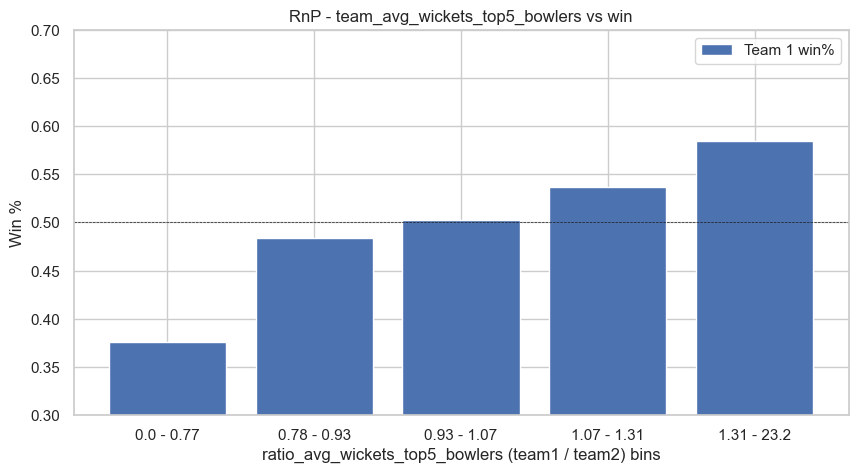

Correlation between team_avg_wickets_top5_bowlers and winner_01 is: -0.12496003337472769


In [43]:
createRnP(train_data, 'team_avg_wickets_top5_bowlers')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


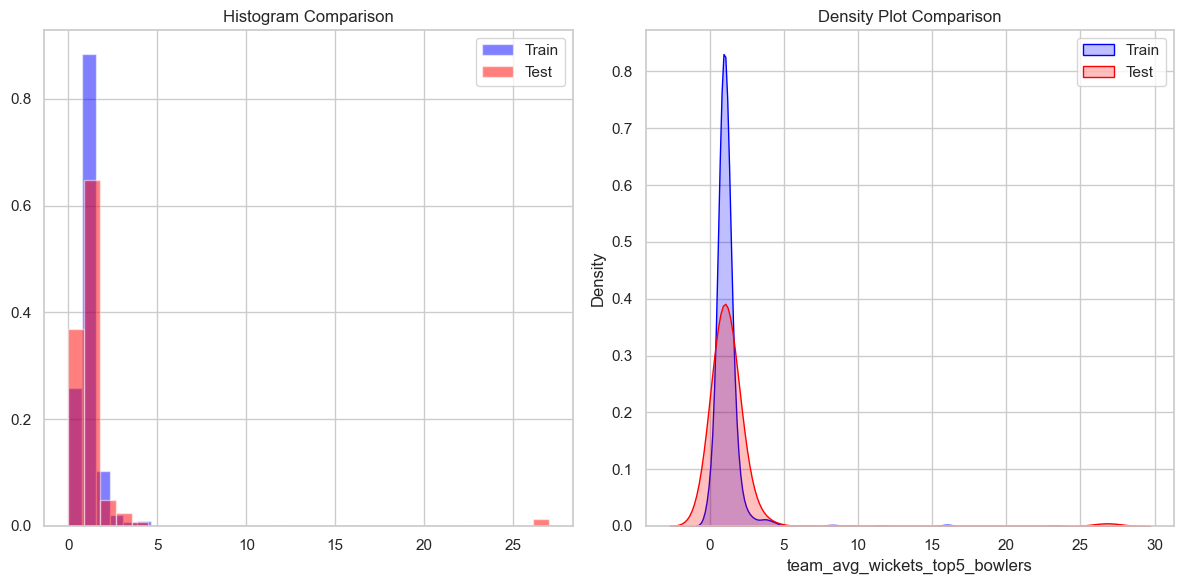

Kolmogorov-Smirnov test result: KS statistic = 0.0509, p-value = 0.6235

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.172481    1.395288
std       1.267244    2.751009
min       0.000000    0.000000
25%       0.822644    0.825778
50%       1.000000    1.025974
75%       1.233242    1.249694
max      23.200000   27.000000


In [44]:
check_distribution_match(train_data['team_avg_wickets_top5_bowlers'], test_data['team_avg_wickets_top5_bowlers'])

In [45]:
remove_skew(train_data, 'team_avg_wickets_top5_bowlers', method='quantile')
remove_skew(test_data, 'team_avg_wickets_top5_bowlers', method='quantile', train=False)

Skewness of team_avg_wickets_top5_bowlers was 10.434939871519715. quantile transformation applied. New skewness is -0.9681470005266314
Skewness of team_avg_wickets_top5_bowlers was 8.822081247252886. quantile transformation applied. New skewness is -0.04246897505855854


/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2667: UserWarning: n_quantiles (1000) is greater than the total number of samples (948). n_quantiles is set to n_samples.
  warnings.warn(


slope: 0.58 / 0.38 =  1.56


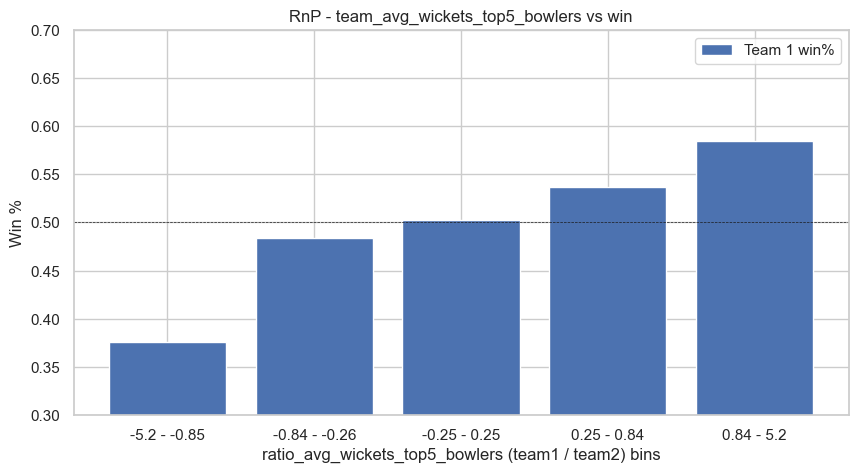

Correlation between team_avg_wickets_top5_bowlers and winner_01 is: -0.1690146269293458


In [46]:
createRnP(train_data, 'team_avg_wickets_top5_bowlers')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


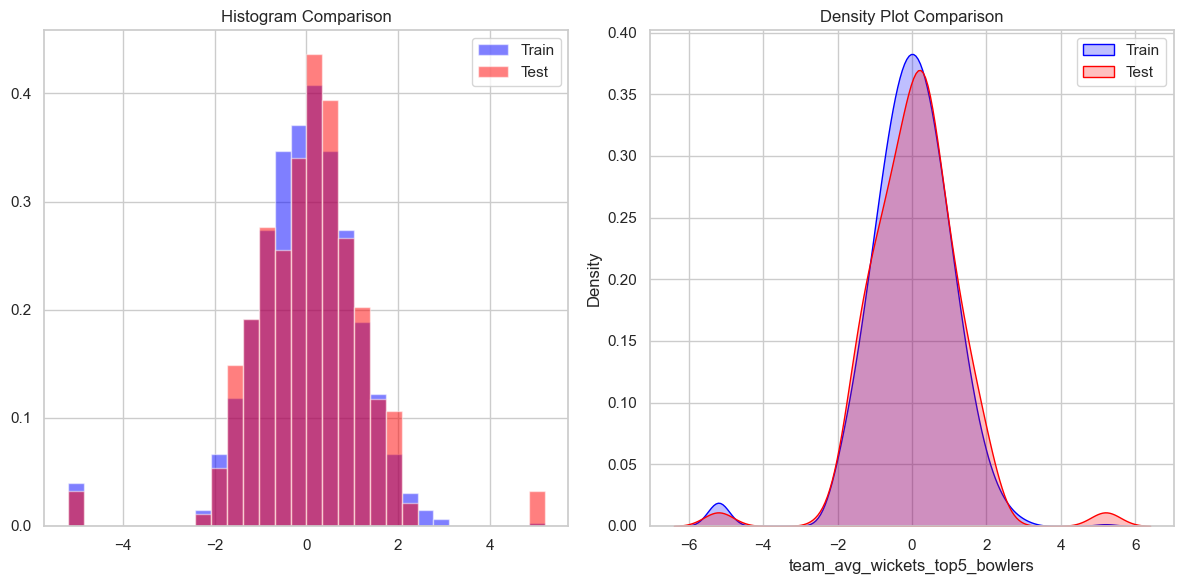

Kolmogorov-Smirnov test result: KS statistic = 0.0509, p-value = 0.6235

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean     -0.033661    0.058420
std       1.141697    1.224844
min      -5.199338   -5.199338
25%      -0.674490   -0.663854
50%       0.006617    0.099423
75%       0.674490    0.713481
max       5.199338    5.199338


In [47]:
check_distribution_match(train_data['team_avg_wickets_top5_bowlers'], test_data['team_avg_wickets_top5_bowlers'])

### team_extra_runs_conceded

In [48]:
def extra_runs_conceded(bowler_df, player_list, date, n=10):
    player_ids = player_list.split(':')
    total_extras = 0

    for player_id in player_ids:
        player_id = float(player_id)
        recent_matches = giveLastNgamesPlayer(player_id, date, n, bat_or_bowl='bowl')
        total_extras += recent_matches['wides'].sum() + recent_matches['noballs'].sum()

    return total_extras

train_data['team1_extra_runs_conceded'] = train_data.apply(lambda x: extra_runs_conceded(bowler_lvl_data, x['team1_roster_ids'], x['match_dt'],n = num_matches), axis=1)
train_data['team2_extra_runs_conceded'] = train_data.apply(lambda x: extra_runs_conceded(bowler_lvl_data, x['team2_roster_ids'], x['match_dt'],n = num_matches), axis=1)

train_data = add_ratio_column(train_data, 'team1_extra_runs_conceded', 'team2_extra_runs_conceded', 'team_extra_runs_conceded')

train_data = train_data.drop(columns=['team1_extra_runs_conceded', 'team2_extra_runs_conceded'])

test_data['team1_extra_runs_conceded'] = test_data.apply(lambda x: extra_runs_conceded(bowler_lvl_data, x['team1_roster_ids'], x['match_dt'],n = num_matches), axis=1)
test_data['team2_extra_runs_conceded'] = test_data.apply(lambda x: extra_runs_conceded(bowler_lvl_data, x['team2_roster_ids'], x['match_dt'],n = num_matches), axis=1)

test_data = add_ratio_column(test_data, 'team1_extra_runs_conceded', 'team2_extra_runs_conceded', 'team_extra_runs_conceded')

test_data = test_data.drop(columns=['team1_extra_runs_conceded', 'team2_extra_runs_conceded'])

slope: 0.53 / 0.44 =  1.2


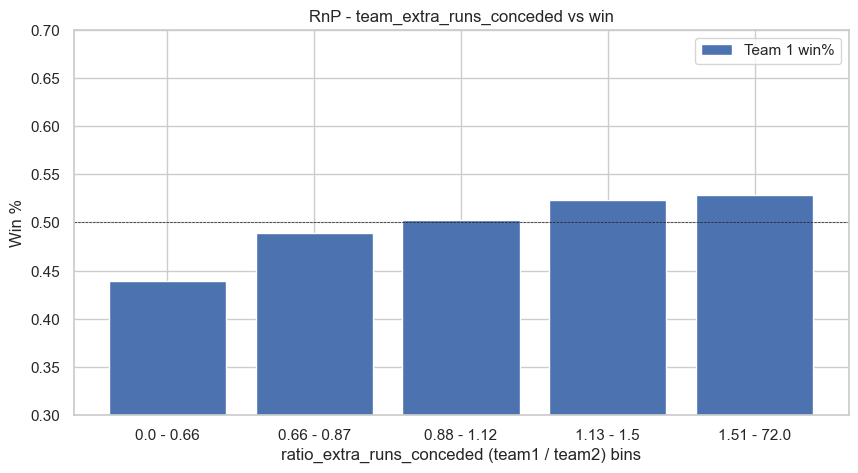

Correlation between team_extra_runs_conceded and winner_01 is: -0.07484662505475996


In [49]:
createRnP(train_data, 'team_extra_runs_conceded')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


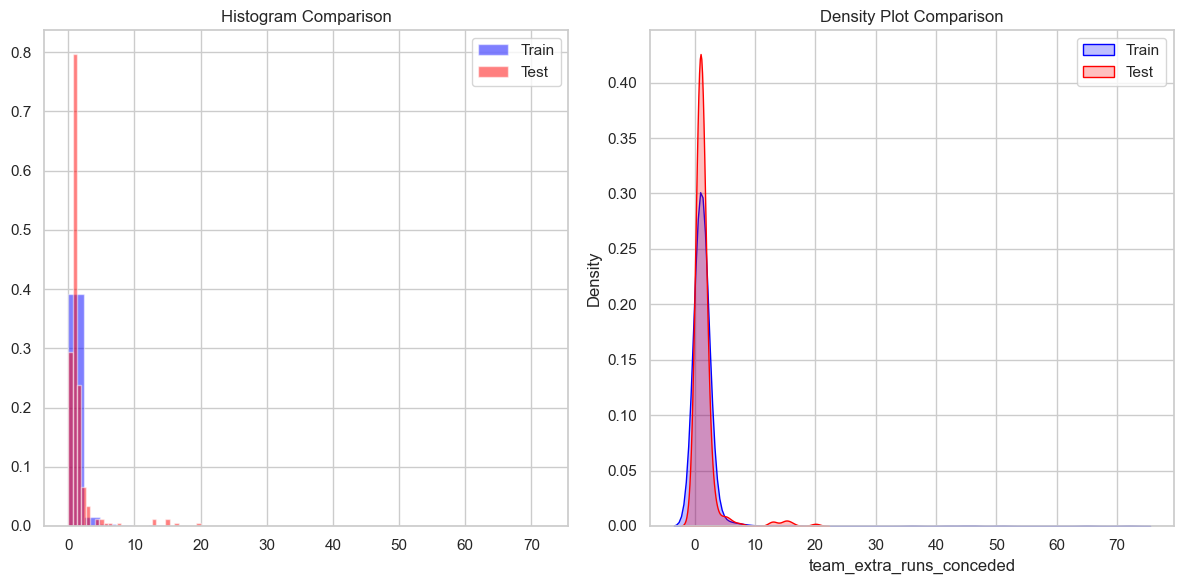

Kolmogorov-Smirnov test result: KS statistic = 0.0409, p-value = 0.8553

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.590927    1.484492
std       4.566753    2.297023
min       0.000000    0.000000
25%       0.719245    0.717724
50%       1.000000    0.965517
75%       1.397619    1.361063
max      72.000000   20.000000


In [50]:
check_distribution_match(train_data['team_extra_runs_conceded'], test_data['team_extra_runs_conceded'])

In [51]:
remove_skew(train_data, 'team_extra_runs_conceded', method='quantile')
remove_skew(test_data, 'team_extra_runs_conceded', method='quantile', train=False)

Skewness of team_extra_runs_conceded was 11.248915569636328. quantile transformation applied. New skewness is -1.1236778044185396
Skewness of team_extra_runs_conceded was 5.482206599725503. quantile transformation applied. New skewness is -0.7778497238748254


/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2667: UserWarning: n_quantiles (1000) is greater than the total number of samples (948). n_quantiles is set to n_samples.
  warnings.warn(


slope: 0.53 / 0.44 =  1.2


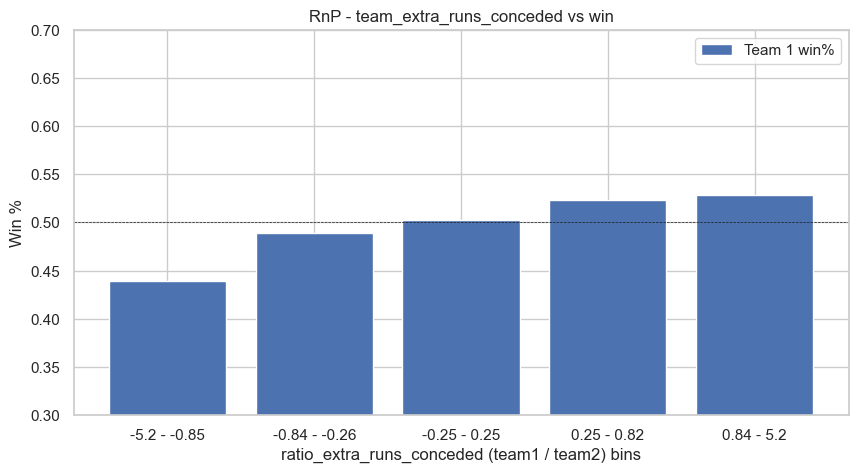

Correlation between team_extra_runs_conceded and winner_01 is: -0.09083569541966245


In [52]:
createRnP(train_data, 'team_extra_runs_conceded')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


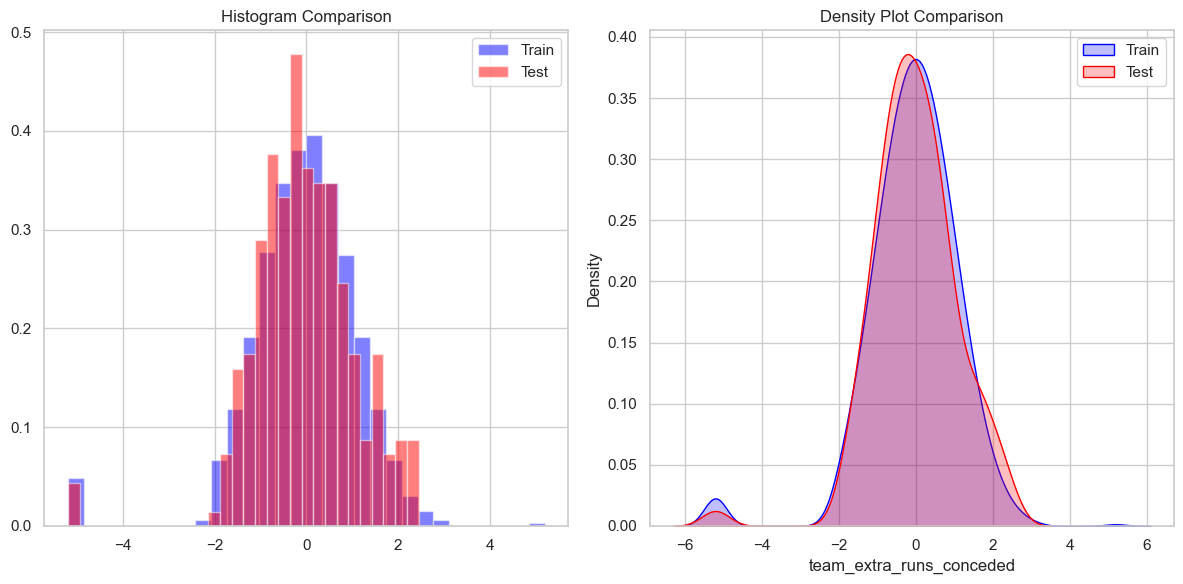

Kolmogorov-Smirnov test result: KS statistic = 0.0409, p-value = 0.8553

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean     -0.043222   -0.020637
std       1.171820    1.103792
min      -5.199338   -5.199338
25%      -0.674490   -0.680618
50%       0.022501   -0.066198
75%       0.676577    0.619196
max       5.199338    2.446339


In [53]:
check_distribution_match(train_data['team_extra_runs_conceded'], test_data['team_extra_runs_conceded'])

### team_average_dots_per_match

In [54]:
def average_dots_per_match(player_list, date, n=10):
    player_ids = player_list.split(':')
    total_dots = 0
    total_matches = 0

    for player_id in player_ids:
        player_id = float(player_id)
        recent_matches = giveLastNgamesPlayer(player_id, date, n, bat_or_bowl='bowl')
        total_dots += recent_matches['dots'].sum()
        total_matches += len(recent_matches)

    return total_dots / total_matches if total_matches > 0 else 0

train_data['team1_average_dots_per_match'] = train_data.apply(lambda x: average_dots_per_match(x['team1_roster_ids'], x['match_dt'],n = num_matches), axis=1)
train_data['team2_average_dots_per_match'] = train_data.apply(lambda x: average_dots_per_match(x['team2_roster_ids'], x['match_dt'],n = num_matches), axis=1)

train_data = add_ratio_column(train_data, 'team1_average_dots_per_match', 'team2_average_dots_per_match', 'team_average_dots_per_match')

train_data = train_data.drop(columns=['team1_average_dots_per_match', 'team2_average_dots_per_match'])

test_data['team1_average_dots_per_match'] = test_data.apply(lambda x: average_dots_per_match(x['team1_roster_ids'], x['match_dt'],n = num_matches), axis=1)
test_data['team2_average_dots_per_match'] = test_data.apply(lambda x: average_dots_per_match(x['team2_roster_ids'], x['match_dt'],n = num_matches), axis=1)

test_data = add_ratio_column(test_data, 'team1_average_dots_per_match', 'team2_average_dots_per_match', 'team_average_dots_per_match')

test_data = test_data.drop(columns=['team1_average_dots_per_match', 'team2_average_dots_per_match'])

slope: 0.55 / 0.42 =  1.29


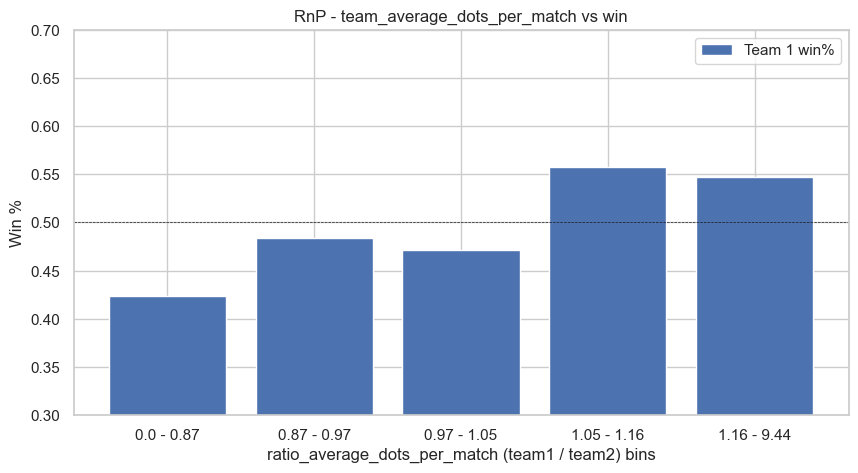

Correlation between team_average_dots_per_match and winner_01 is: -0.06897569738223483


In [55]:
createRnP(train_data, 'team_average_dots_per_match')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


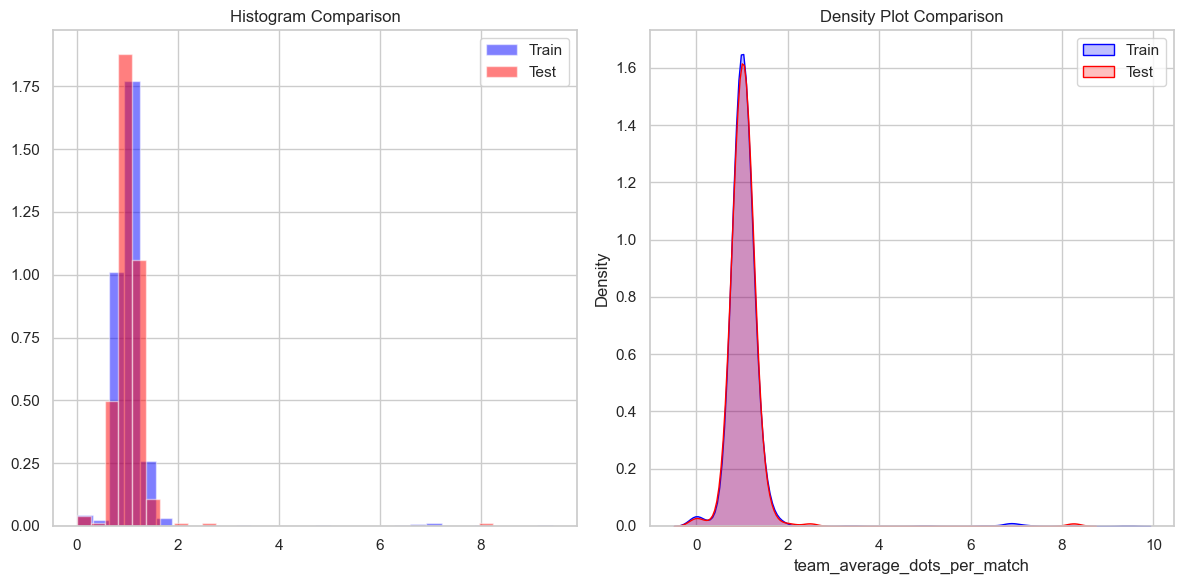

Kolmogorov-Smirnov test result: KS statistic = 0.0516, p-value = 0.6059

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.072134    1.042975
std       0.644385    0.499809
min       0.000000    0.000000
25%       0.892069    0.885041
50%       1.008887    1.019371
75%       1.124893    1.135280
max       9.437500    8.250000


In [56]:
check_distribution_match(train_data['team_average_dots_per_match'], test_data['team_average_dots_per_match'])

In [57]:
remove_skew(train_data, 'team_average_dots_per_match', method='quantile')
remove_skew(test_data, 'team_average_dots_per_match', method='quantile', train=False)

Skewness of team_average_dots_per_match was 8.550689275078458. quantile transformation applied. New skewness is -0.9687697171304142
Skewness of team_average_dots_per_match was 11.191746707391301. quantile transformation applied. New skewness is -0.9539223552872275


/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2667: UserWarning: n_quantiles (1000) is greater than the total number of samples (948). n_quantiles is set to n_samples.
  warnings.warn(


slope: 0.55 / 0.42 =  1.29


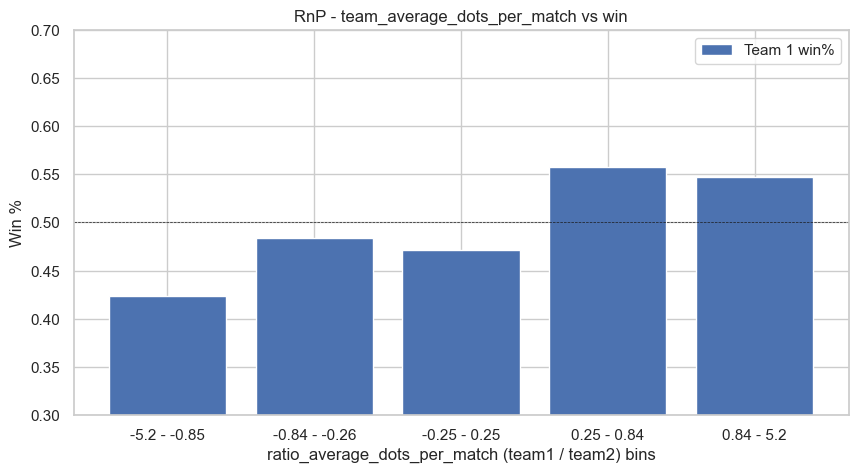

Correlation between team_average_dots_per_match and winner_01 is: -0.10791646125914851


In [58]:
createRnP(train_data, 'team_average_dots_per_match')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


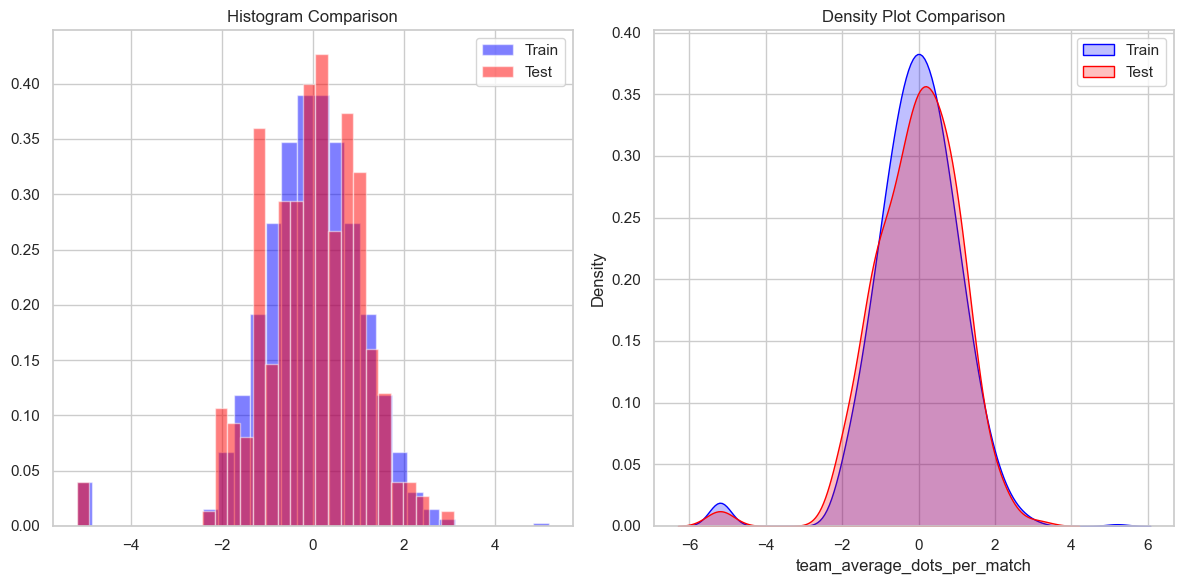

Kolmogorov-Smirnov test result: KS statistic = 0.0516, p-value = 0.6059

Descriptive Statistics Comparison:
        Train Stats  Test Stats
count  9.480000e+02  271.000000
mean  -3.381876e-02   -0.042917
std    1.141575e+00    1.128400
min   -5.199338e+00   -5.199338
25%   -6.744904e-01   -0.720871
50%   -1.392116e-16    0.038152
75%    6.744904e-01    0.729781
max    5.199338e+00    3.099702


In [59]:
check_distribution_match(train_data['team_average_dots_per_match'], test_data['team_average_dots_per_match'])

### team_bowler_performance_ratio

In [60]:
#new feature 1 bowler's performance of teams in recent mathes
def team_bowler_performance_recent(bowler_df, match_id, team_roster_ids, date, n=15):
    team_ids = str(team_roster_ids).split(':')
    total_impact_score = 0

    for player_id in team_ids:
        recent_matches = giveLastNgamesPlayer(player_id=player_id, date=date, n=n, bat_or_bowl='bowl')
        if not recent_matches.empty:
            player_impact = (recent_matches['wicket_count']) * 5 + recent_matches['dots']*1.5+(recent_matches['maiden']) * 1.5 -(recent_matches['Fours'] * 1) - recent_matches['Sixes']*1.5 - recent_matches['wides'] - recent_matches['noballs']                            
            total_impact_score += player_impact.sum()

    return total_impact_score

train_data['team1_bowler_performance_recent'] = train_data.apply(
    lambda x: team_bowler_performance_recent(bowler_lvl_data, x['match id'], x['team1_roster_ids'], x['match_dt']),
    axis=1
)

train_data['team2_bowler_performance_recent'] = train_data.apply(
    lambda x: team_bowler_performance_recent(bowler_lvl_data, x['match id'], x['team2_roster_ids'], x['match_dt']),
    axis=1
)
train_data = add_ratio_column(train_data, 'team1_bowler_performance_recent', 'team2_bowler_performance_recent', 'team_bowler_performance_ratio')

# Drop the initial individual features
train_data = train_data.drop(columns=['team1_bowler_performance_recent', 'team2_bowler_performance_recent'])

test_data['team1_bowler_performance_recent'] = test_data.apply(
    lambda x: team_bowler_performance_recent(bowler_lvl_data, x['match id'], x['team1_roster_ids'], x['match_dt']),
    axis=1
)

test_data['team2_bowler_performance_recent'] = test_data.apply(
    lambda x: team_bowler_performance_recent(bowler_lvl_data, x['match id'], x['team2_roster_ids'], x['match_dt']),
    axis=1
)
test_data = add_ratio_column(test_data, 'team1_bowler_performance_recent', 'team2_bowler_performance_recent', 'team_bowler_performance_ratio')

# Drop the initial individual features
test_data = test_data.drop(columns=['team1_bowler_performance_recent', 'team2_bowler_performance_recent'])

slope: 0.61 / 0.34 =  1.8


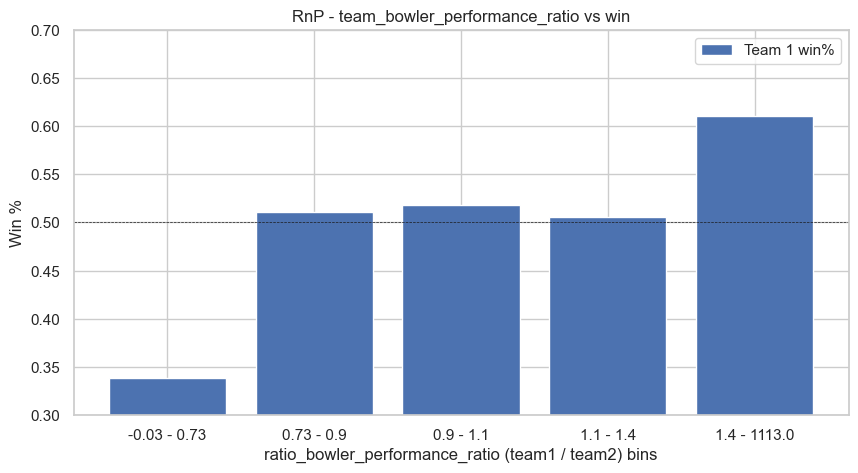

Correlation between team_bowler_performance_ratio and winner_01 is: -0.05037630480130837


In [61]:
createRnP(train_data, 'team_bowler_performance_ratio')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


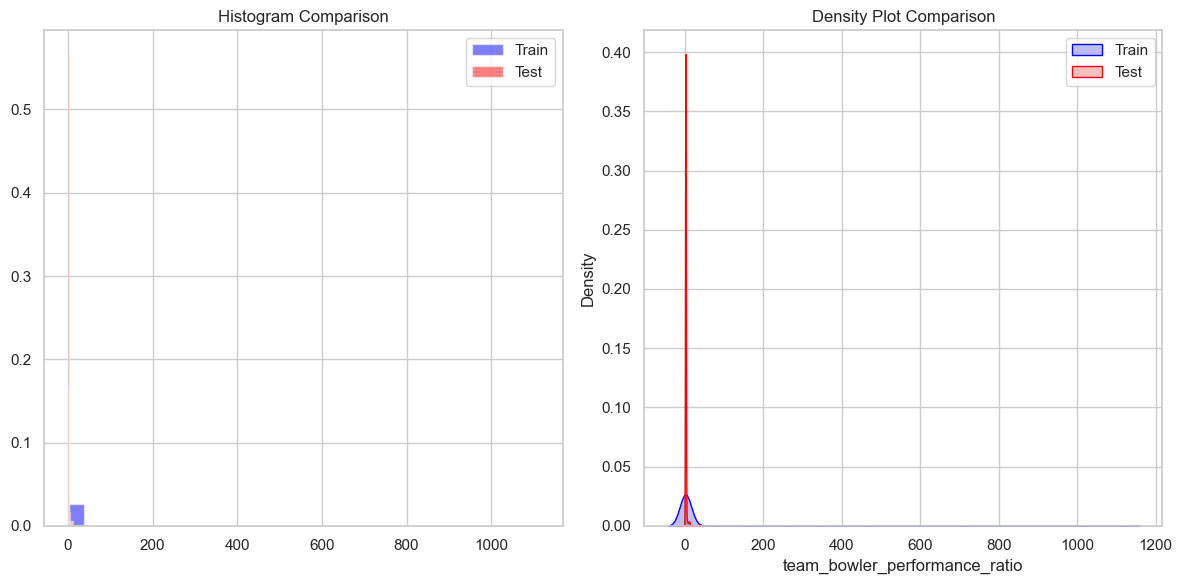

Kolmogorov-Smirnov test result: KS statistic = 0.1057, p-value = 0.0166

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      5.618912    1.420354
std      57.700298    2.597474
min      -0.028103    0.000000
25%       0.790858    0.826576
50%       0.981911    1.051232
75%       1.284090    1.334909
max    1113.000000   38.500000


In [62]:
check_distribution_match(train_data['team_bowler_performance_ratio'], test_data['team_bowler_performance_ratio'])

In [63]:
# train_data = handle_outliers(train_data, 'team_bowler_performance_ratio')
# test_data = handle_outliers(test_data, 'team_bowler_performance_ratio')

remove_skew(train_data, 'team_bowler_performance_ratio', method='quantile')
remove_skew(test_data, 'team_bowler_performance_ratio', method='quantile', train=False)

Skewness of team_bowler_performance_ratio was 15.727021194757878. quantile transformation applied. New skewness is 0.022300757560188577
Skewness of team_bowler_performance_ratio was 11.446400247125148. quantile transformation applied. New skewness is -0.14157333849945405


/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2667: UserWarning: n_quantiles (1000) is greater than the total number of samples (948). n_quantiles is set to n_samples.
  warnings.warn(


slope: 0.61 / 0.34 =  1.8


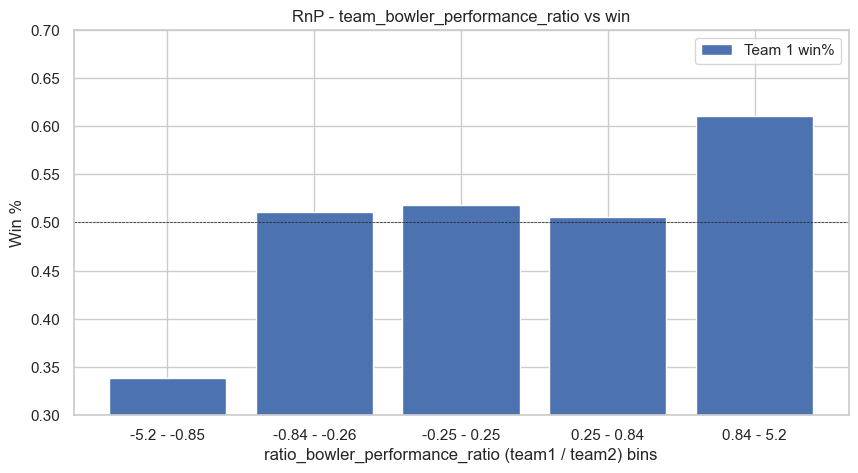

Correlation between team_bowler_performance_ratio and winner_01 is: -0.16691134531084595


In [64]:
createRnP(train_data, 'team_bowler_performance_ratio')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


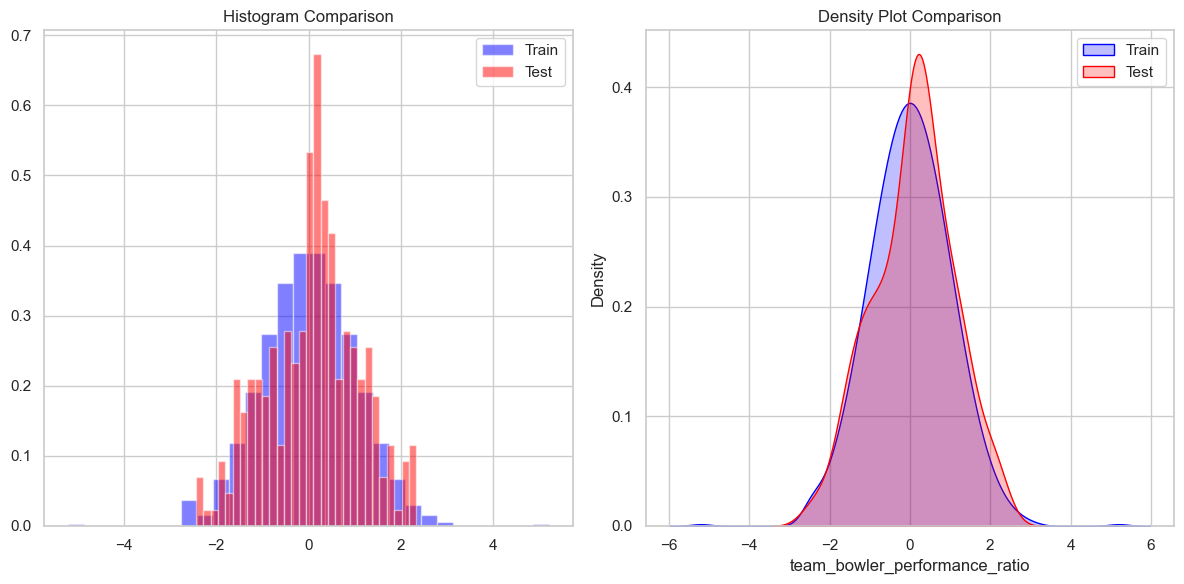

Kolmogorov-Smirnov test result: KS statistic = 0.1057, p-value = 0.0166

Descriptive Statistics Comparison:
        Train Stats  Test Stats
count  9.480000e+02  271.000000
mean   1.142580e-03    0.089393
std    1.018370e+00    1.004803
min   -5.199338e+00   -2.437639
25%   -6.744904e-01   -0.536766
50%    2.782063e-16    0.162006
75%    6.744904e-01    0.769192
max    5.199338e+00    2.330598


In [65]:
check_distribution_match(train_data['team_bowler_performance_ratio'], test_data['team_bowler_performance_ratio'])

### team_avg_wicket

In [66]:
def average_wickets_taken(player_list, date, n):
    player_list = player_list.split(':')
    wickets_list = []
    for player_id in player_list:
        recent_matches = giveLastNgamesPlayer(player_id=player_id, date=date, n=n, bat_or_bowl='bowl')
        total_wickets = recent_matches['wicket_count'].sum()
        average_wickets = total_wickets / n if n > 0 else 0
        wickets_list.append(average_wickets)
    return sum(wickets_list) / len(wickets_list) if wickets_list else 0

train_data['team1_avg_wicket'] = train_data.progress_apply(lambda x: \
            average_wickets_taken(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['team2_avg_wicket'] = train_data.progress_apply(lambda x: \
            average_wickets_taken(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data = add_ratio_column(train_data, 'team1_avg_wicket', 'team2_avg_wicket', 'team_avg_wicket')

train_data = train_data.drop(columns=['team1_avg_wicket', 'team2_avg_wicket'])

test_data['team1_avg_wicket'] = test_data.progress_apply(lambda x: \
            average_wickets_taken(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['team2_avg_wicket'] = test_data.progress_apply(lambda x: \
            average_wickets_taken(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data = add_ratio_column(test_data, 'team1_avg_wicket', 'team2_avg_wicket', 'team_avg_wicket')

test_data = test_data.drop(columns=['team1_avg_wicket', 'team2_avg_wicket'])

100%|██████████| 271/271 [00:03<00:00, 77.80it/s]


slope: 0.6 / 0.39 =  1.55


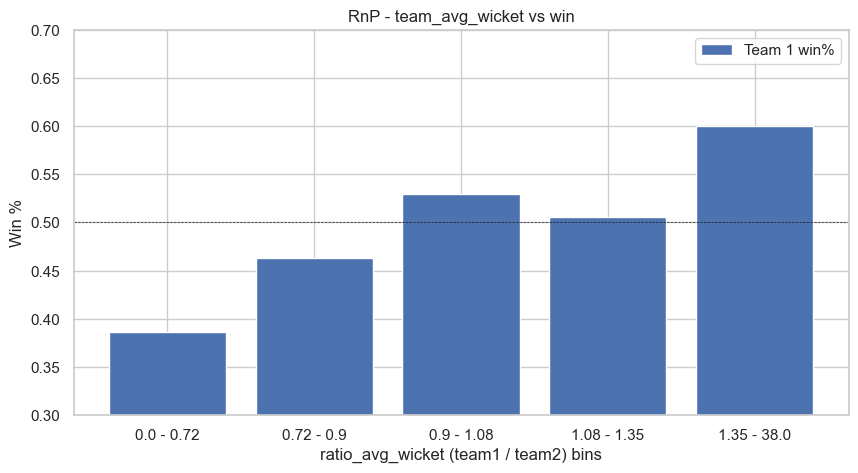

Correlation between team_avg_wicket and winner_01 is: -0.10351532938769395


In [67]:
createRnP(train_data, 'team_avg_wicket')   

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


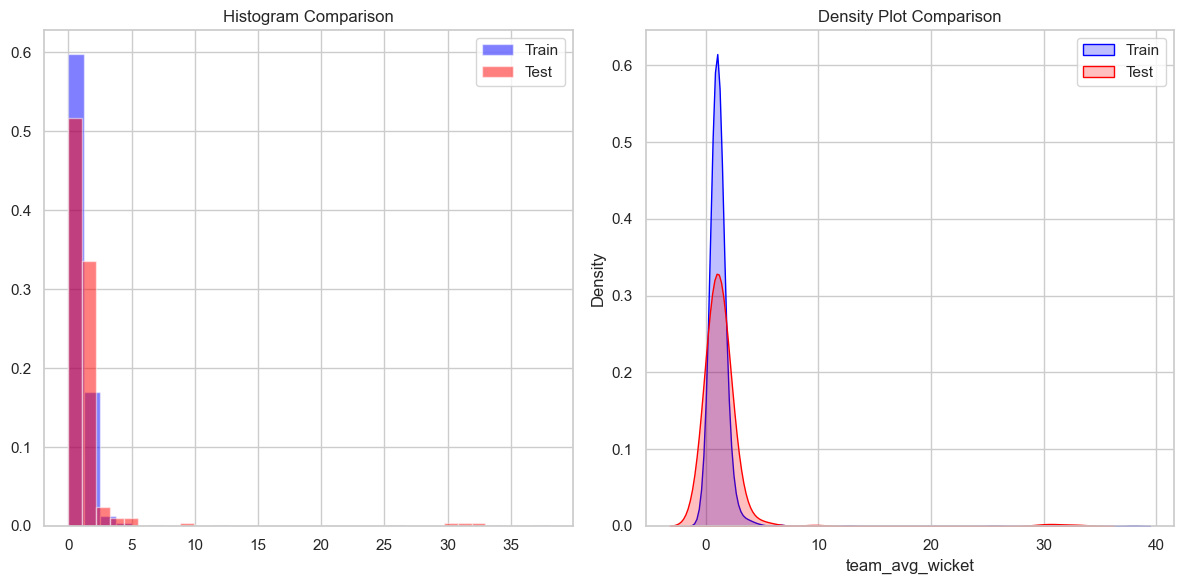

Kolmogorov-Smirnov test result: KS statistic = 0.0673, p-value = 0.2792

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.190463    1.501683
std       1.913690    3.281587
min       0.000000    0.000000
25%       0.785714    0.776298
50%       0.988300    1.000000
75%       1.258155    1.343919
max      38.000000   33.000000


In [68]:
check_distribution_match(train_data['team_avg_wicket'], test_data['team_avg_wicket'])

In [69]:
remove_skew(train_data, 'team_avg_wicket', method='quantile')
remove_skew(test_data, 'team_avg_wicket', method='quantile', train=False)

Skewness of team_avg_wicket was 14.911101277827377. quantile transformation applied. New skewness is -0.9688777682195913
Skewness of team_avg_wicket was 8.521517093352115. quantile transformation applied. New skewness is -0.6922458802545621


/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2667: UserWarning: n_quantiles (1000) is greater than the total number of samples (948). n_quantiles is set to n_samples.
  warnings.warn(


slope: 0.6 / 0.39 =  1.55


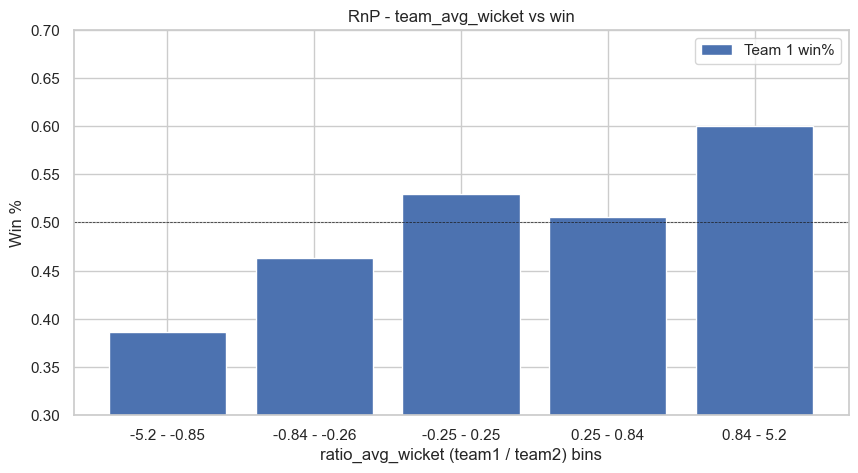

Correlation between team_avg_wicket and winner_01 is: -0.1576413183246282


In [70]:
createRnP(train_data, 'team_avg_wicket')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


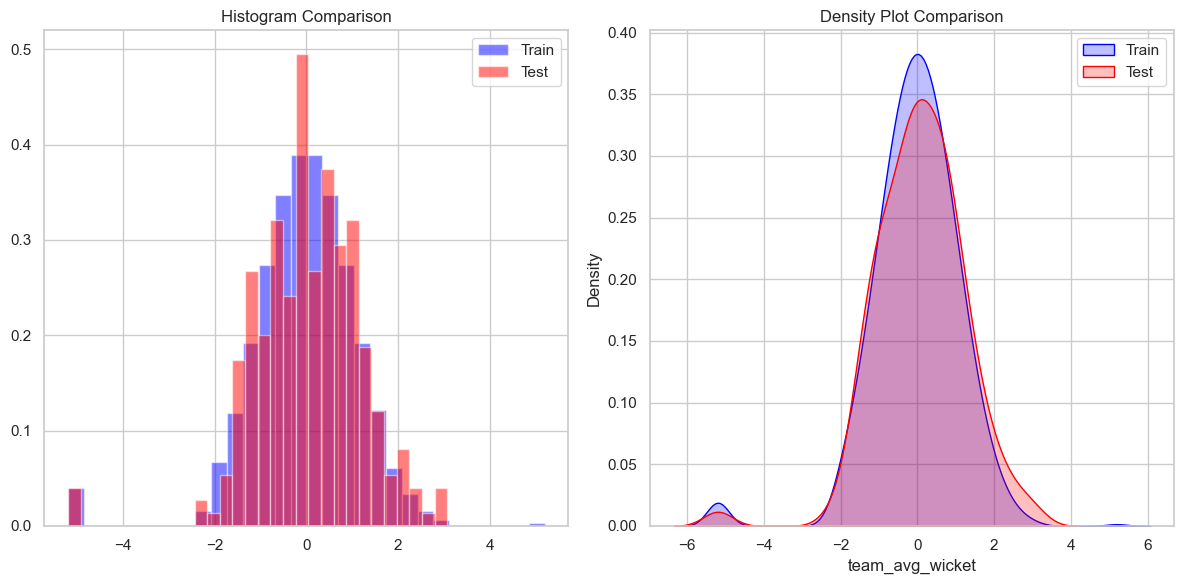

Kolmogorov-Smirnov test result: KS statistic = 0.0673, p-value = 0.2792

Descriptive Statistics Comparison:
        Train Stats  Test Stats
count  9.480000e+02  271.000000
mean  -3.373012e-02    0.063566
std    1.141508e+00    1.174082
min   -5.199338e+00   -5.199338
25%   -6.744904e-01   -0.695955
50%   -1.392116e-16    0.023824
75%    6.744904e-01    0.837493
max    5.199338e+00    3.074023


In [71]:
check_distribution_match(train_data['team_avg_wicket'], test_data['team_avg_wicket'])

### team_batting_strength

In [72]:
def team_batting_strength(player_list, date, n):
    players = player_list.split(':')
    total_runs = 0
    for player_id in players:
        recent_matches = giveLastNgamesPlayer(player_id=player_id, date=date, n=n, bat_or_bowl='bat')
        total_runs += recent_matches['runs'].sum()
    return total_runs / len(players) if players else 0

train_data['team1_batting_strength'] = train_data.progress_apply(lambda x: \
            team_batting_strength(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['team2_batting_strength'] = train_data.progress_apply(lambda x: \
            team_batting_strength(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data = add_ratio_column(train_data, 'team1_batting_strength', 'team2_batting_strength', 'team_batting_strength')

train_data = train_data.drop(columns=['team1_batting_strength', 'team2_batting_strength'])

test_data['team1_batting_strength'] = test_data.progress_apply(lambda x: \
            team_batting_strength(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['team2_batting_strength'] = test_data.progress_apply(lambda x: \
            team_batting_strength(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data = add_ratio_column(test_data, 'team1_batting_strength', 'team2_batting_strength', 'team_batting_strength')

test_data = test_data.drop(columns=['team1_batting_strength', 'team2_batting_strength'])

100%|██████████| 271/271 [00:04<00:00, 62.73it/s]


slope: 0.64 / 0.34 =  1.88


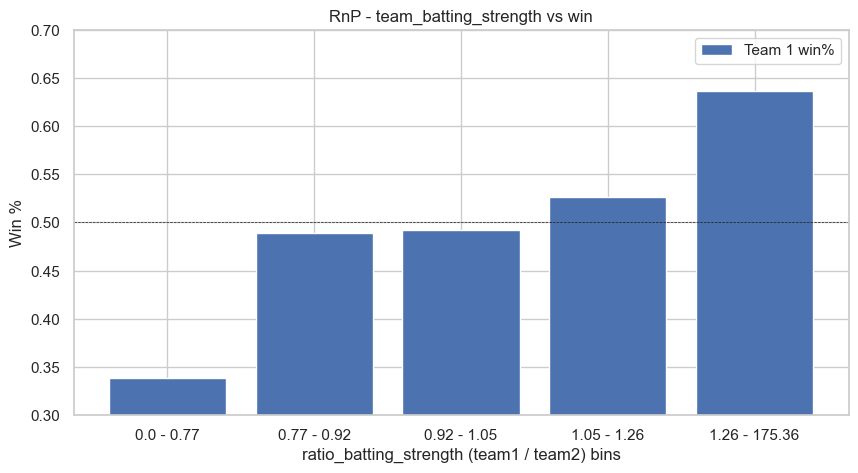

Correlation between team_batting_strength and winner_01 is: -0.06285430528267014


In [73]:
createRnP(train_data, 'team_batting_strength')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


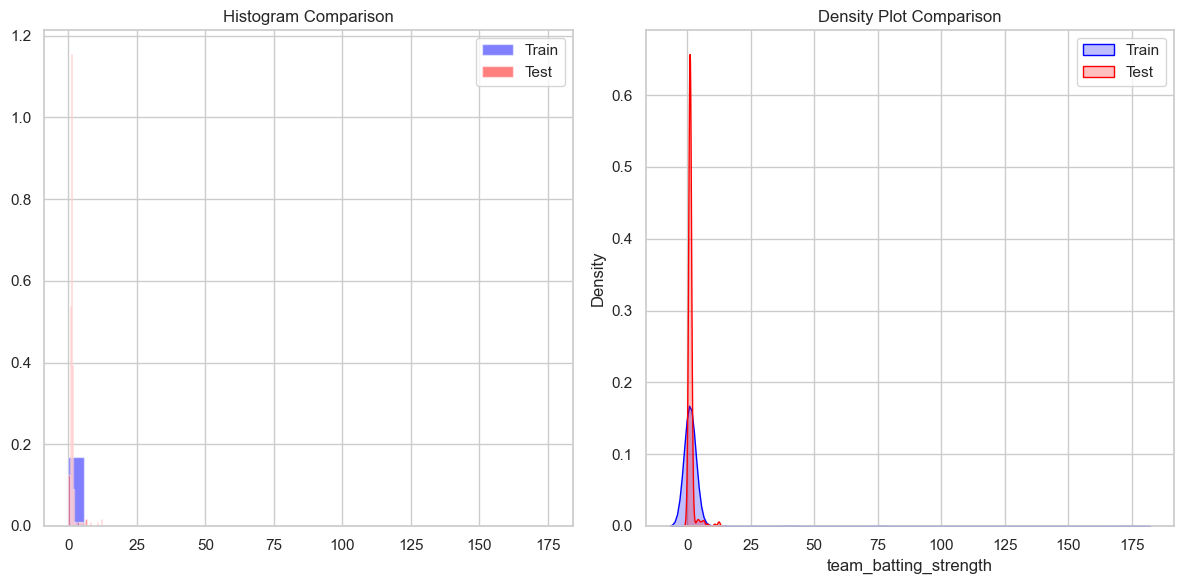

Kolmogorov-Smirnov test result: KS statistic = 0.0519, p-value = 0.5989

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.791761    1.270211
std       8.971790    1.436063
min       0.000000    0.000000
25%       0.813151    0.815097
50%       0.978937    0.993631
75%       1.189842    1.239880
max     175.363636   12.362069


In [74]:
check_distribution_match(train_data['team_batting_strength'], test_data['team_batting_strength'])

In [75]:
# train_data = handle_outliers(train_data, 'team_batting_strength')
# test_data = handle_outliers(test_data, 'team_batting_strength')

remove_skew(train_data, 'team_batting_strength', method='quantile')
remove_skew(test_data, 'team_batting_strength', method='quantile', train=False)

Skewness of team_batting_strength was 16.213935546162297. quantile transformation applied. New skewness is -0.9104786548964429
Skewness of team_batting_strength was 5.504598474931442. quantile transformation applied. New skewness is -0.6815782404797542


/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2667: UserWarning: n_quantiles (1000) is greater than the total number of samples (948). n_quantiles is set to n_samples.
  warnings.warn(


slope: 0.64 / 0.34 =  1.88


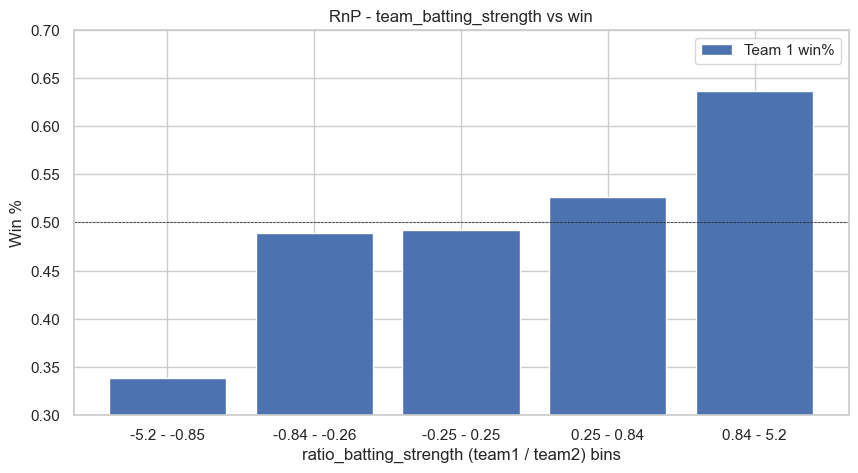

Correlation between team_batting_strength and winner_01 is: -0.1900130908681658


In [76]:
createRnP(train_data, 'team_batting_strength')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


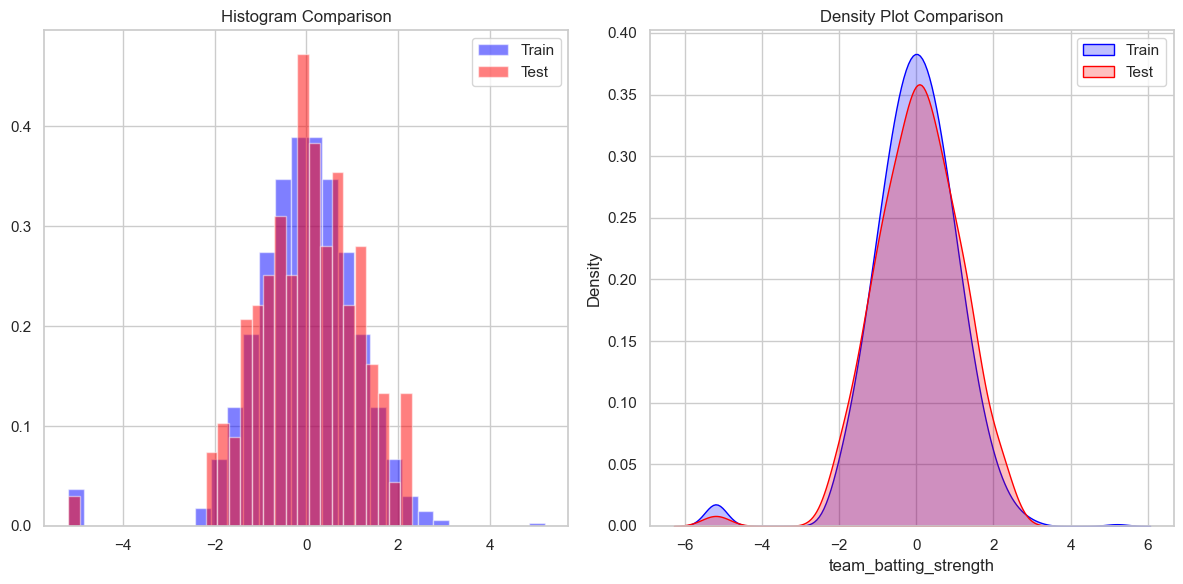

Kolmogorov-Smirnov test result: KS statistic = 0.0519, p-value = 0.5989

Descriptive Statistics Comparison:
        Train Stats  Test Stats
count  9.480000e+02  271.000000
mean  -3.069301e-02    0.033885
std    1.131428e+00    1.109474
min   -5.199338e+00   -5.199338
25%   -6.744904e-01   -0.663910
50%   -1.392116e-16    0.048605
75%    6.744904e-01    0.768964
max    5.199338e+00    2.302007


In [77]:
check_distribution_match(train_data['team_batting_strength'], test_data['team_batting_strength'])

### team_momentum

In [78]:
def calculate_exponential_momentum(match_lvl_data, team_id, date, alpha=0.1):
    matches = match_lvl_data[((match_lvl_data['team1_id'] == team_id) | (match_lvl_data['team2_id'] == team_id)) &
                             (match_lvl_data['match_dt'] < date)].sort_values('match_dt', ascending=False)
    wins = matches['winner_id'].apply(lambda x: 1 if x == team_id else 0).to_numpy()
    weights = np.exp(-alpha * np.arange(len(wins)))
    if np.sum(weights) > 0:
        momentum = np.dot(wins, weights) / np.sum(weights)
    else:
        momentum = 0  # Handle case with no matches
    return momentum

train_data['team1_momentum'] = train_data.apply(
    lambda x: calculate_exponential_momentum(match_lvl_data, x['team1_id'], x['match_dt']),
    axis=1
)
train_data['team2_momentum'] = train_data.apply(
    lambda x: calculate_exponential_momentum(match_lvl_data, x['team2_id'], x['match_dt']),
    axis=1
)

train_data = add_ratio_column(train_data, 'team1_momentum', 'team2_momentum', 'team_momentum')

train_data = train_data.drop(columns=['team1_momentum', 'team2_momentum'])

test_data['team1_momentum'] = test_data.apply(
    lambda x: calculate_exponential_momentum(match_lvl_data, x['team1_id'], x['match_dt']),
    axis=1
)
test_data['team2_momentum'] = test_data.apply(
    lambda x: calculate_exponential_momentum(match_lvl_data, x['team2_id'], x['match_dt']),
    axis=1
)

test_data = add_ratio_column(test_data, 'team1_momentum', 'team2_momentum', 'team_momentum')

test_data = test_data.drop(columns=['team1_momentum', 'team2_momentum'])

slope: 0.56 / 0.42 =  1.33


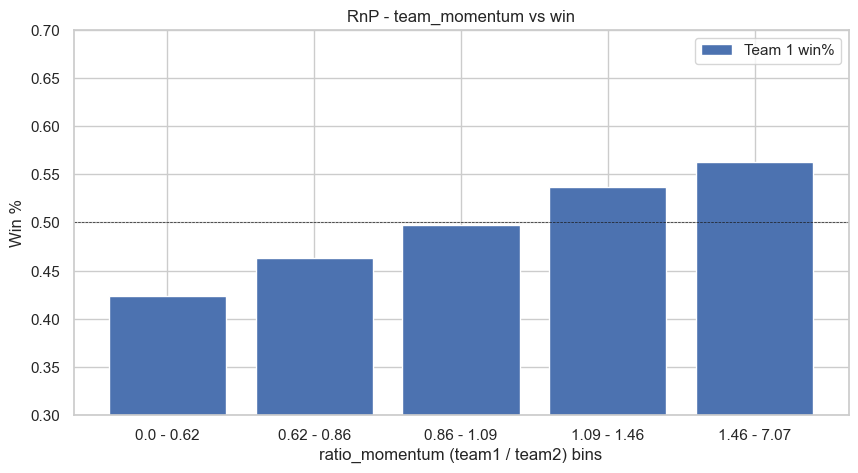

Correlation between team_momentum and winner_01 is: -0.09341226475457841


In [79]:
createRnP(train_data, 'team_momentum')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


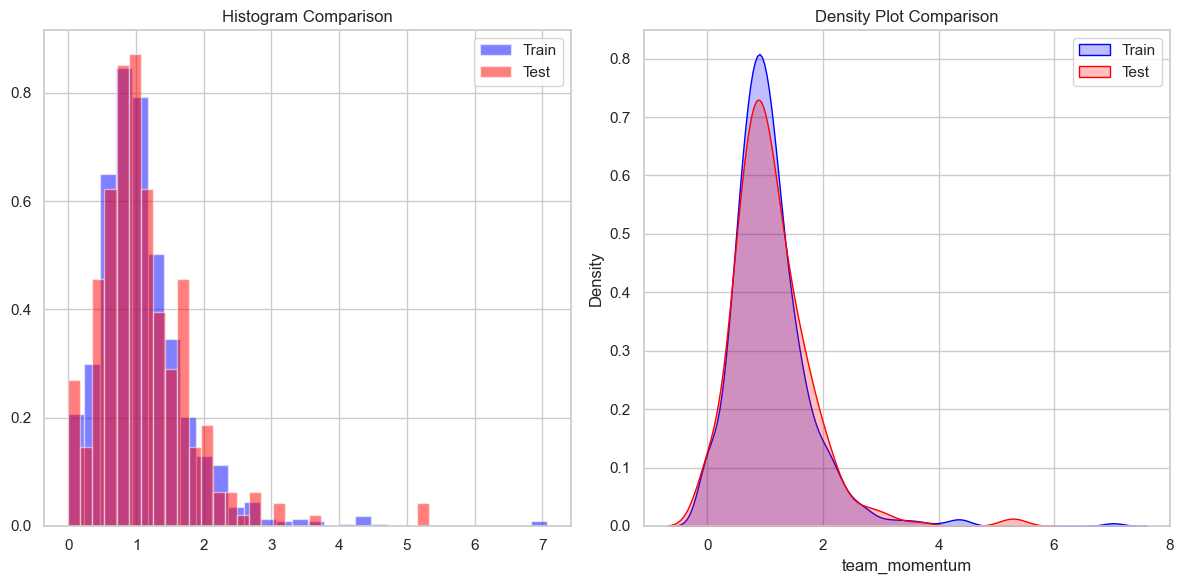

Kolmogorov-Smirnov test result: KS statistic = 0.0437, p-value = 0.7955

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.084422    1.105497
std       0.689988    0.701511
min       0.000000    0.000000
25%       0.682378    0.684016
50%       0.977013    0.987529
75%       1.347996    1.414583
max       7.065686    5.332317


In [80]:
check_distribution_match(train_data['team_momentum'], test_data['team_momentum'])

In [81]:
remove_skew(train_data, 'team_momentum', method='log')
remove_skew(test_data, 'team_momentum', method='log', train=False)

Skewness of team_momentum was 2.485375670626139. log transformation applied. New skewness is 0.30980390992244305
Skewness of team_momentum was 2.0681247582607982. log transformation applied. New skewness is 0.21767653143409846


slope: 0.56 / 0.42 =  1.33


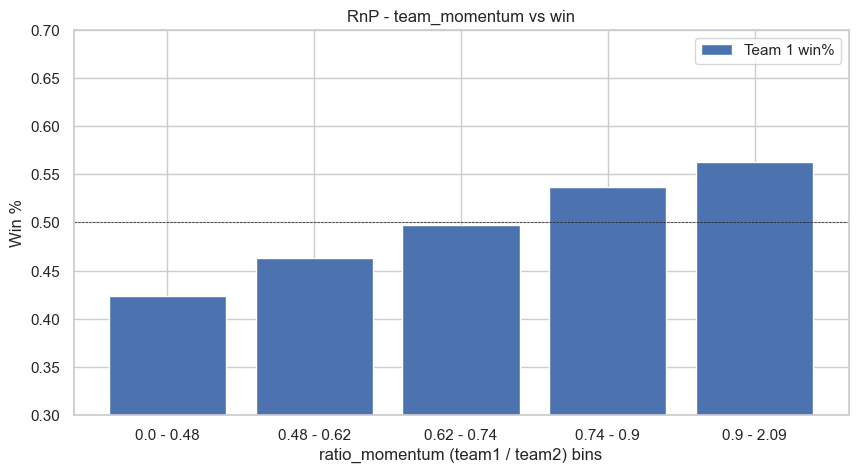

Correlation between team_momentum and winner_01 is: -0.097422542381829


In [82]:
createRnP(train_data, 'team_momentum')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


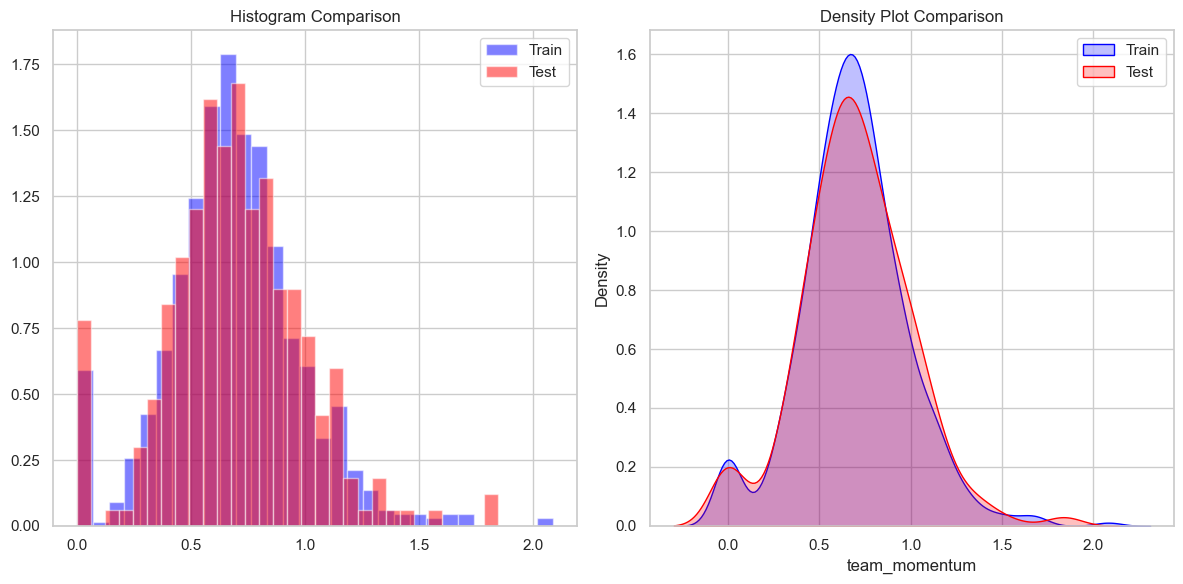

Kolmogorov-Smirnov test result: KS statistic = 0.0437, p-value = 0.7955

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      0.689294    0.697362
std       0.294460    0.302902
min       0.000000    0.000000
25%       0.520208    0.521181
50%       0.681587    0.686892
75%       0.853562    0.881527
max       2.087619    1.845666


In [83]:
check_distribution_match(train_data['team_momentum'], test_data['team_momentum'])

### team_batsman_performance_recent

In [84]:
def team_batsman_performance_recent(bat_df, match_id, team_roster_ids, date, n=15):
    team_ids = str(team_roster_ids).split(':')
    total_performance_index = 0

    for player_id in team_ids:
        recent_matches = giveLastNgamesPlayer(player_id=player_id, date=date, n=n, bat_or_bowl='bat')
        if not recent_matches.empty:
            player_performance = (recent_matches['runs'] * 4.5 +
                                  recent_matches['strike_rate'] * 2.5 +
                                  (recent_matches['Fours'] + recent_matches['Sixes'] ) * 1.5) 
                                  
            total_performance_index += player_performance.sum()

    return total_performance_index

train_data['team1_batsman_performance_recent'] = train_data.apply(
    lambda x: team_batsman_performance_recent(batsman_lvl_data, x['match id'], x['team1_roster_ids'], x['match_dt']),
    axis=1
)

train_data['team2_batsman_performance_recent'] = train_data.apply(
    lambda x: team_batsman_performance_recent(batsman_lvl_data, x['match id'], x['team2_roster_ids'], x['match_dt']),
    axis=1
)

train_data = add_ratio_column(train_data, 'team1_batsman_performance_recent', 'team2_batsman_performance_recent', 'team_batsman_performance_recent')

train_data = train_data.drop(columns=['team1_batsman_performance_recent', 'team2_batsman_performance_recent'])

test_data['team1_batsman_performance_recent'] = test_data.apply(
    lambda x: team_batsman_performance_recent(batsman_lvl_data, x['match id'], x['team1_roster_ids'], x['match_dt']),
    axis=1
)

test_data['team2_batsman_performance_recent'] = test_data.apply(
    lambda x: team_batsman_performance_recent(batsman_lvl_data, x['match id'], x['team2_roster_ids'], x['match_dt']),
    axis=1
)

test_data = add_ratio_column(test_data, 'team1_batsman_performance_recent', 'team2_batsman_performance_recent', 'team_batsman_performance_recent')

test_data = test_data.drop(columns=['team1_batsman_performance_recent', 'team2_batsman_performance_recent'])

slope: 0.58 / 0.35 =  1.65


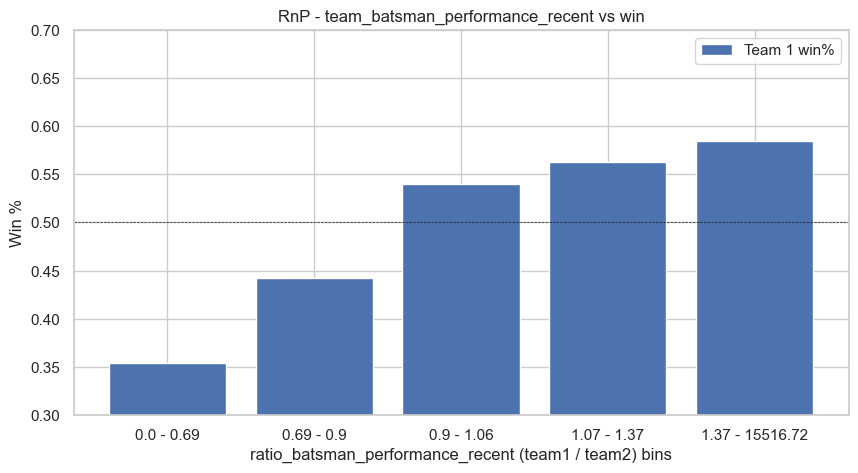

Correlation between team_batsman_performance_recent and winner_01 is: -0.04340818347684576


In [85]:
createRnP(train_data, 'team_batsman_performance_recent')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


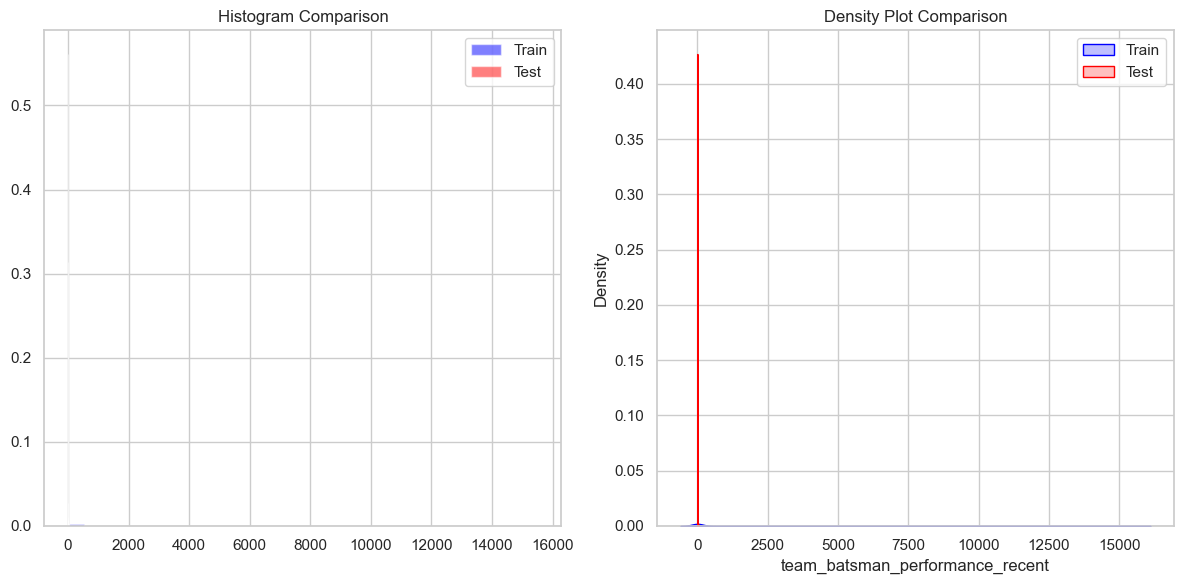

Kolmogorov-Smirnov test result: KS statistic = 0.0403, p-value = 0.8661

Descriptive Statistics Comparison:
        Train Stats  Test Stats
count    948.000000  271.000000
mean      60.915898    1.406714
std      785.743925    2.404311
min        0.000000    0.000000
25%        0.758679    0.748565
50%        0.977252    0.954295
75%        1.264147    1.312189
max    15516.725000   31.760455


In [86]:
check_distribution_match(train_data['team_batsman_performance_recent'], test_data['team_batsman_performance_recent'])

In [87]:
# train_data = handle_outliers(train_data, 'team_batsman_performance_recent')
# test_data = handle_outliers(test_data, 'team_batsman_performance_recent')

remove_skew(train_data, 'team_batsman_performance_recent', method='quantile')
remove_skew(test_data, 'team_batsman_performance_recent', method='quantile', train=False)

Skewness of team_batsman_performance_recent was 16.066367868963873. quantile transformation applied. New skewness is -1.2904113967898494
Skewness of team_batsman_performance_recent was 8.752602121688737. quantile transformation applied. New skewness is -0.9323133333277289


/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2667: UserWarning: n_quantiles (1000) is greater than the total number of samples (948). n_quantiles is set to n_samples.
  warnings.warn(


slope: 0.58 / 0.35 =  1.65


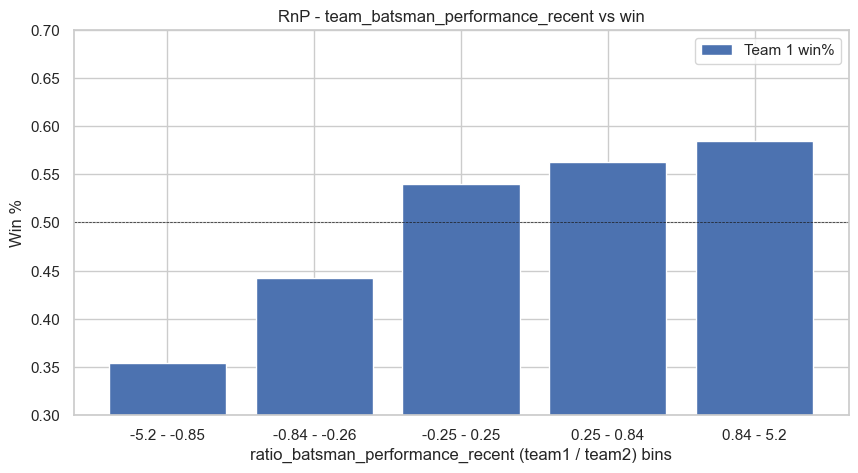

Correlation between team_batsman_performance_recent and winner_01 is: -0.16083217931003416


In [88]:
createRnP(train_data, 'team_batsman_performance_recent')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


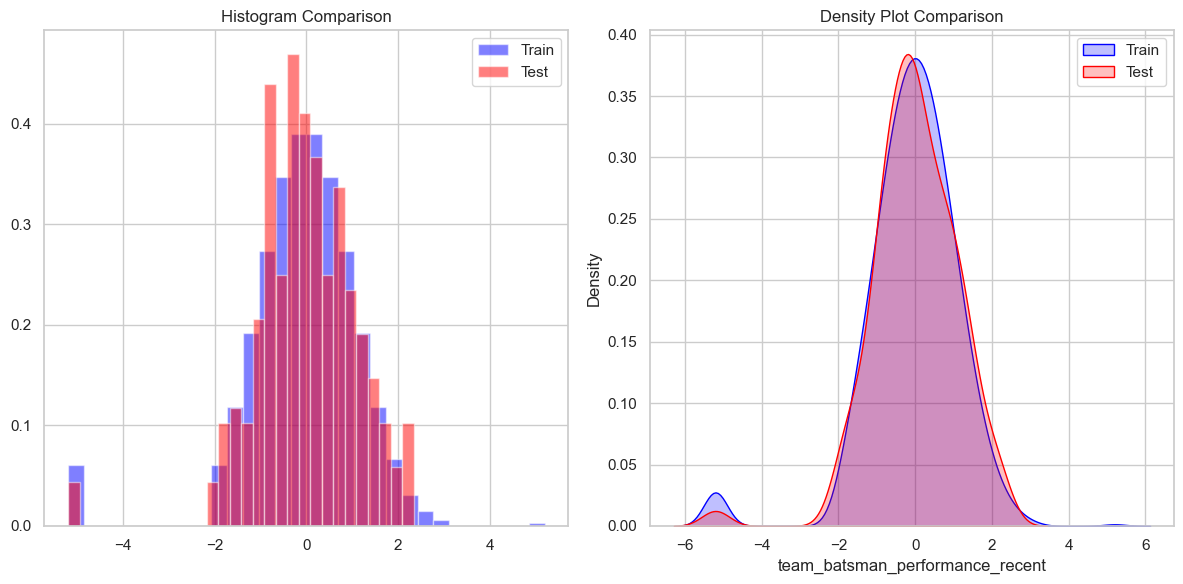

Kolmogorov-Smirnov test result: KS statistic = 0.0403, p-value = 0.8661

Descriptive Statistics Comparison:
        Train Stats  Test Stats
count  9.480000e+02  271.000000
mean  -5.651747e-02   -0.009945
std    1.211428e+00    1.109526
min   -5.199338e+00   -5.199338
25%   -6.744904e-01   -0.697474
50%    3.478121e-16   -0.069227
75%    6.744904e-01    0.750330
max    5.199338e+00    2.345538


In [89]:
check_distribution_match(train_data['team_batsman_performance_recent'], test_data['team_batsman_performance_recent'])

### team_pom_frequency

In [90]:
def player_of_match_frequency(matches, team_roster_ids, date):
    team_ids = str(team_roster_ids).split(':')
    pom_awards = 0
    total_matches = 0

    for player_id in team_ids:
        past_matches = matches[(matches['match_dt'] < date) & (matches['player_of_the_match_id'] == float(player_id))]
        pom_awards += past_matches.shape[0]
        total_matches += matches[(matches['match_dt'] < date) & ((matches['team1_roster_ids'].str.contains(str(player_id))) | (matches['team2_roster_ids'].str.contains(str(player_id))))].shape[0]

    return pom_awards / total_matches if total_matches > 0 else 0

train_data['team1_pom_frequency'] = train_data.apply(lambda x: player_of_match_frequency(match_lvl_data, x['team1_roster_ids'], x['match_dt']), axis=1)
train_data['team2_pom_frequency'] = train_data.apply(lambda x: player_of_match_frequency(match_lvl_data, x['team2_roster_ids'], x['match_dt']), axis=1)

train_data = add_ratio_column(train_data, 'team1_pom_frequency', 'team2_pom_frequency', 'team_pom_frequency')

train_data = train_data.drop(columns=['team1_pom_frequency', 'team2_pom_frequency'])

test_data['team1_pom_frequency'] = test_data.apply(lambda x: player_of_match_frequency(match_lvl_data, x['team1_roster_ids'], x['match_dt']), axis=1)
test_data['team2_pom_frequency'] = test_data.apply(lambda x: player_of_match_frequency(match_lvl_data, x['team2_roster_ids'], x['match_dt']), axis=1)

test_data = add_ratio_column(test_data, 'team1_pom_frequency', 'team2_pom_frequency', 'team_pom_frequency')

test_data = test_data.drop(columns=['team1_pom_frequency', 'team2_pom_frequency'])

slope: 0.53 / 0.39 =  1.36


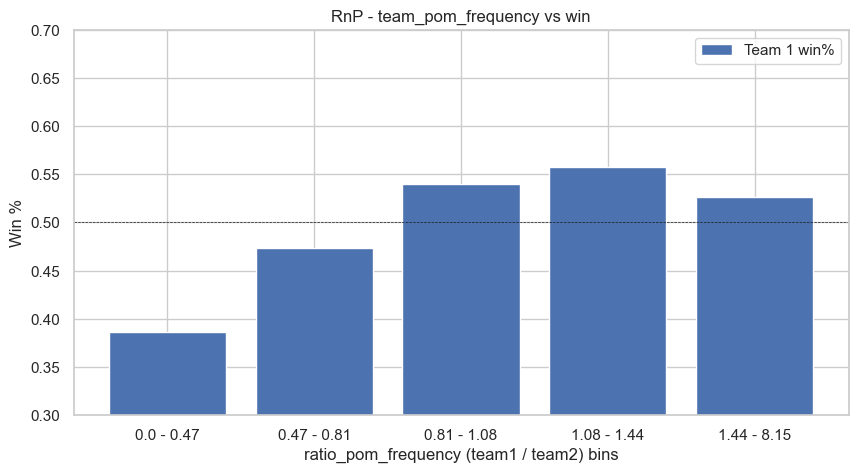

Correlation between team_pom_frequency and winner_01 is: -0.10387943593858757


In [91]:
createRnP(train_data, 'team_pom_frequency')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


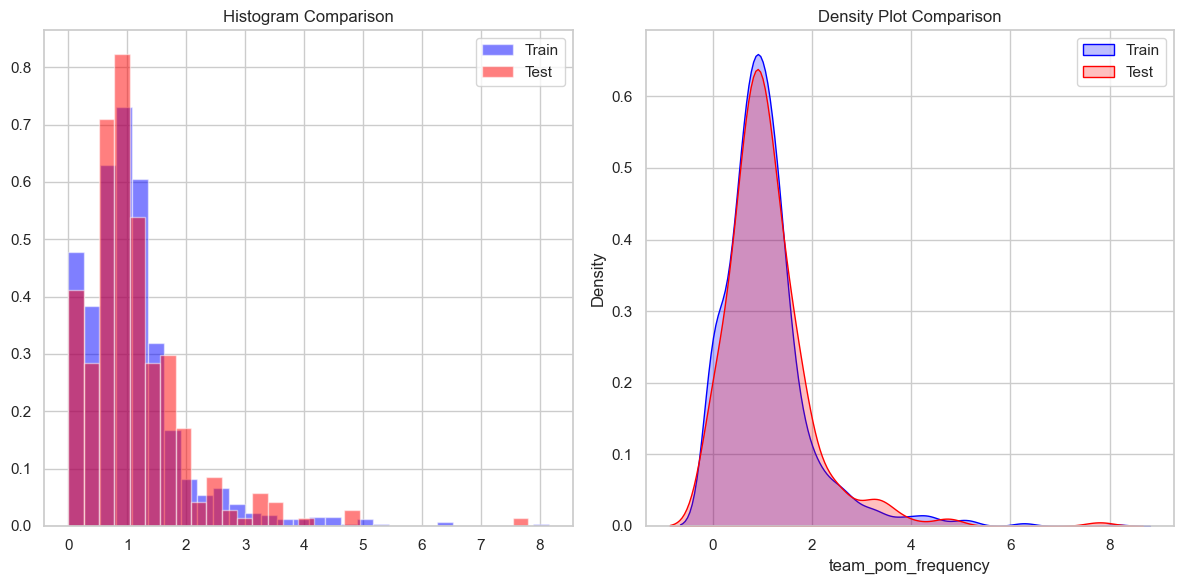

Kolmogorov-Smirnov test result: KS statistic = 0.0589, p-value = 0.4356

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.062113    1.116506
std       0.872368    0.888507
min       0.000000    0.000000
25%       0.575646    0.617815
50%       0.927612    0.960854
75%       1.323588    1.420928
max       8.151111    7.802120


In [92]:
check_distribution_match(train_data['team_pom_frequency'], test_data['team_pom_frequency'])

In [93]:
remove_skew(train_data, 'team_pom_frequency', method='quantile')
remove_skew(test_data, 'team_pom_frequency', method='quantile', train=False)

Skewness of team_pom_frequency was 2.3780794969674646. quantile transformation applied. New skewness is -1.743574397816213
Skewness of team_pom_frequency was 2.6387050242041012. quantile transformation applied. New skewness is -1.8935038139028268


/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2667: UserWarning: n_quantiles (1000) is greater than the total number of samples (948). n_quantiles is set to n_samples.
  warnings.warn(


slope: 0.53 / 0.39 =  1.36


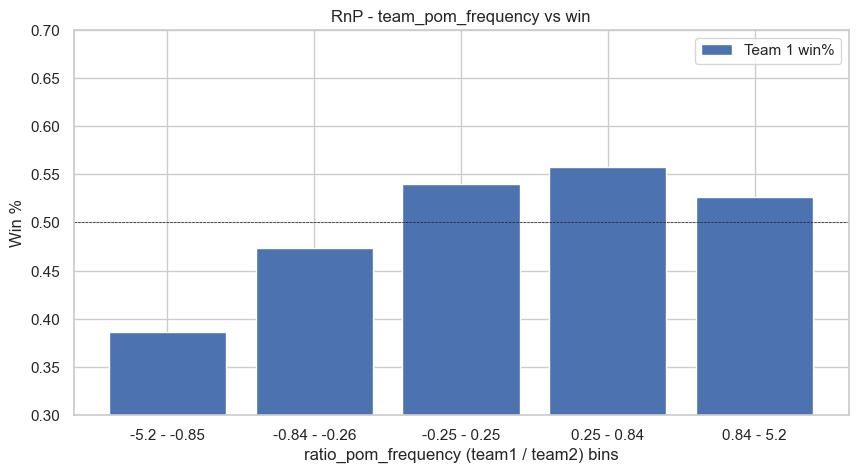

Correlation between team_pom_frequency and winner_01 is: -0.1572267382013481


In [94]:
createRnP(train_data, 'team_pom_frequency')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


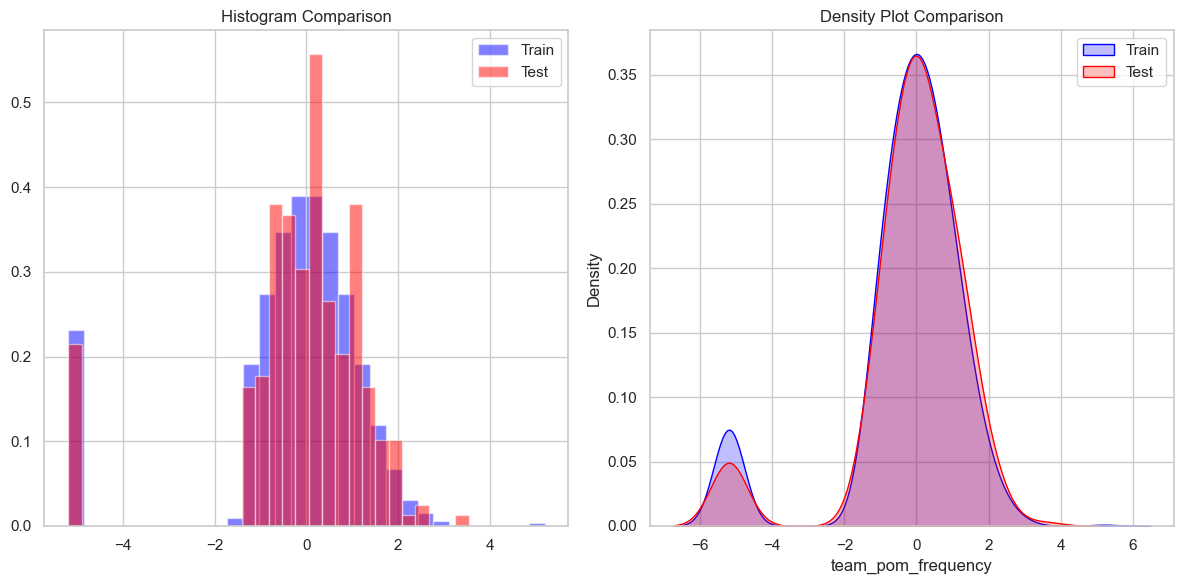

Kolmogorov-Smirnov test result: KS statistic = 0.0589, p-value = 0.4356

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean     -0.265105   -0.129229
std       1.683020    1.561880
min      -5.199338   -5.199338
25%      -0.674490   -0.592202
50%       0.000000    0.058133
75%       0.674490    0.820813
max       5.199338    3.544714


In [95]:
check_distribution_match(train_data['team_pom_frequency'], test_data['team_pom_frequency'])

###

In [96]:
def team_count_100runs_last15(matches, team1_roster, team2_roster, date, n=25):
    def count_100s(team_roster):
        total_100s = 0
        for player_id in team_roster.split(':'):
            player_matches = giveLastNgamesPlayer(player_id, date, n, 'bat')
            total_100s += (player_matches['runs'] >= 75).sum()
        return total_100s

    team1_100s = count_100s(team1_roster)
    team2_100s = count_100s(team2_roster)

    return team1_100s / team2_100s if team2_100s > 0 else team1_100s

train_data['team_count_100runs_ratio_last15'] = train_data.apply(lambda x: team_count_100runs_last15(match_lvl_data, x['team1_roster_ids'], x['team2_roster_ids'], x['match_dt']), axis=1)
test_data['team_count_100runs_ratio_last15'] = test_data.apply(lambda x: team_count_100runs_last15(match_lvl_data, x['team1_roster_ids'], x['team2_roster_ids'], x['match_dt']), axis=1)

slope: 0.59 / 0.4 =  1.48


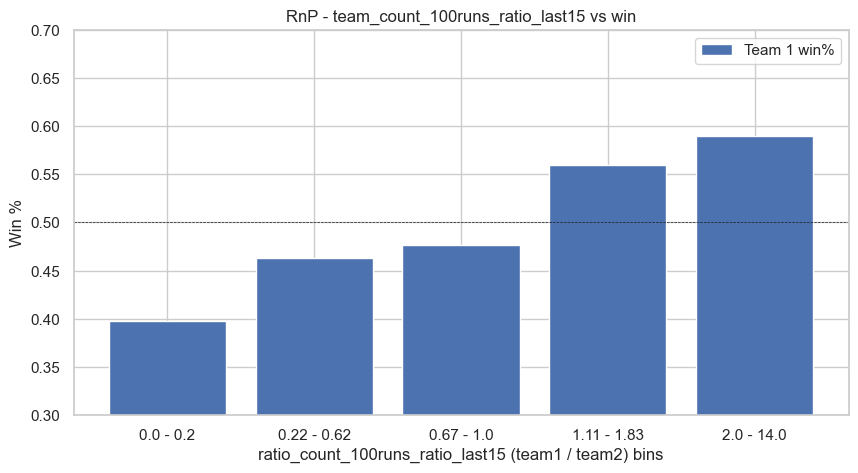

Correlation between team_count_100runs_ratio_last15 and winner_01 is: -0.14108232795000986


In [97]:
createRnP(train_data, 'team_count_100runs_ratio_last15')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


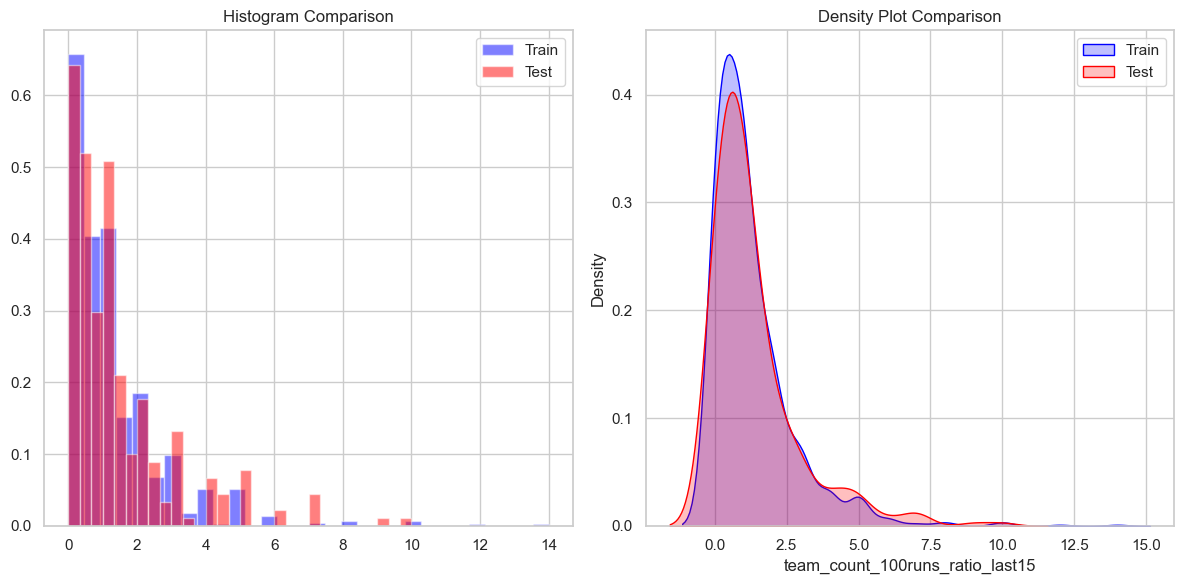

Kolmogorov-Smirnov test result: KS statistic = 0.0302, p-value = 0.9870

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.274676    1.365704
std       1.483916    1.597194
min       0.000000    0.000000
25%       0.333333    0.375000
50%       1.000000    1.000000
75%       1.750000    1.666667
max      14.000000   10.000000


In [98]:
check_distribution_match(train_data['team_count_100runs_ratio_last15'], test_data['team_count_100runs_ratio_last15'])

In [99]:
remove_skew(train_data, 'team_count_100runs_ratio_last15', method='sqrt')
remove_skew(test_data, 'team_count_100runs_ratio_last15', method='sqrt', train=False)

Skewness of team_count_100runs_ratio_last15 was 2.8535227456095624. square root transformation applied. New skewness is 0.45615396542395226
Skewness of team_count_100runs_ratio_last15 was 2.264393808264223. square root transformation applied. New skewness is 0.504468869686905


slope: 0.59 / 0.4 =  1.48


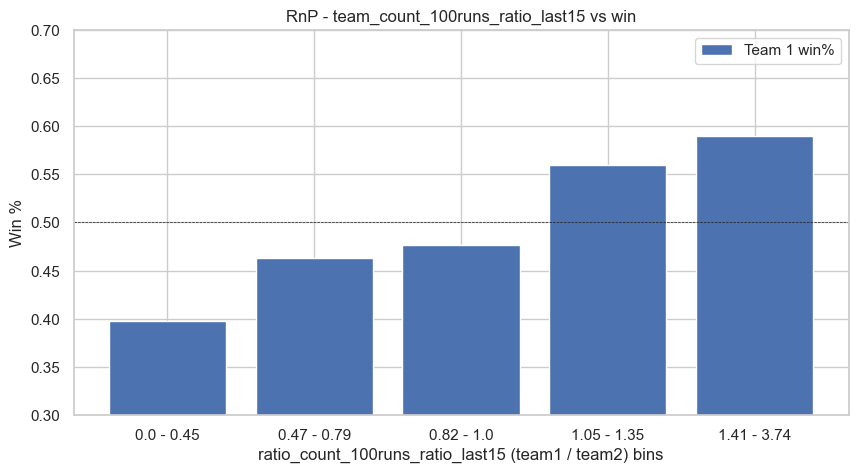

Correlation between team_count_100runs_ratio_last15 and winner_01 is: -0.14628285571498287


In [100]:
createRnP(train_data, 'team_count_100runs_ratio_last15')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


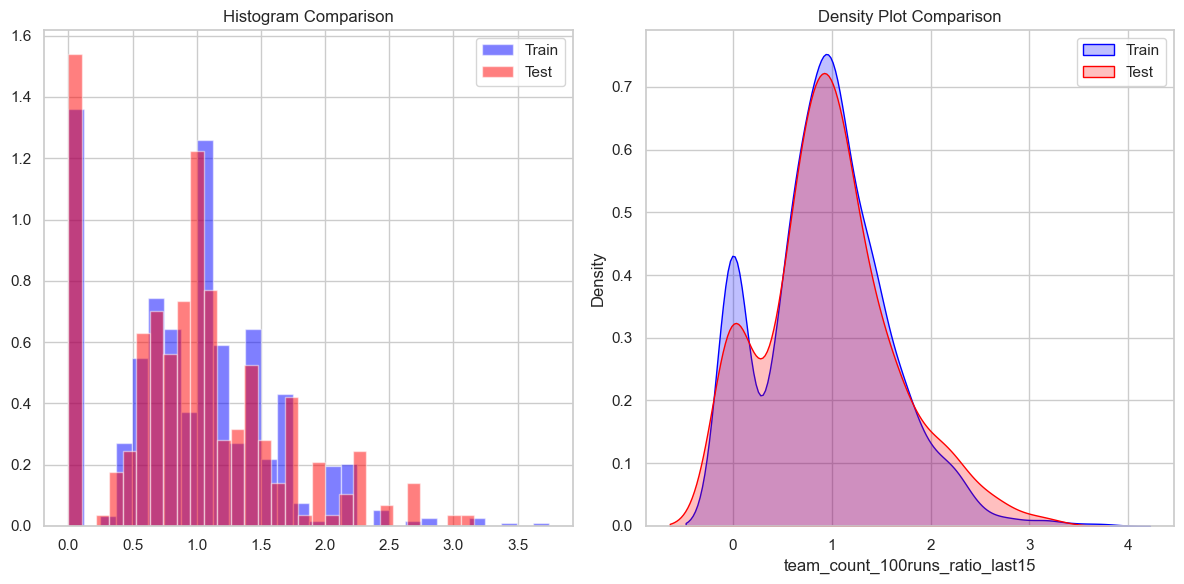

Kolmogorov-Smirnov test result: KS statistic = 0.0302, p-value = 0.9870

Descriptive Statistics Comparison:
        Train Stats    Test Stats
count  9.480000e+02  2.710000e+02
mean   9.399936e-01  9.712677e-01
std    6.257001e-01  6.510819e-01
min    1.490116e-08  1.490116e-08
25%    5.773503e-01  6.123724e-01
50%    1.000000e+00  1.000000e+00
75%    1.322876e+00  1.290994e+00
max    3.741657e+00  3.162278e+00


In [101]:
check_distribution_match(train_data['team_count_100runs_ratio_last15'], test_data['team_count_100runs_ratio_last15'])

### team_win_percentage_fielding_first

In [102]:
def win_percentage_fielding_first(matches, team_id, date):
    fielding_first_matches = matches[((matches['team1_id'] == team_id) & (matches['toss decision'] == 'field')) | ((matches['team2_id'] == team_id) & (matches['toss decision'] == 'field')) & (matches['match_dt'] < date)]
    wins = fielding_first_matches[fielding_first_matches['winner_id'] == team_id].shape[0]
    total_matches = fielding_first_matches.shape[0]
    return (wins / total_matches) * 100 if total_matches > 0 else 0

train_data['team1_win_percentage_fielding_first'] = train_data.apply(lambda x: win_percentage_fielding_first(match_lvl_data, x['team1_id'], x['match_dt']), axis=1)
train_data['team2_win_percentage_fielding_first'] = train_data.apply(lambda x: win_percentage_fielding_first(match_lvl_data, x['team2_id'], x['match_dt']), axis=1)

train_data = add_ratio_column(train_data, 'team1_win_percentage_fielding_first', 'team2_win_percentage_fielding_first', 'team_win_percentage_fielding_first')

train_data = train_data.drop(columns=['team1_win_percentage_fielding_first', 'team2_win_percentage_fielding_first'])

test_data['team1_win_percentage_fielding_first'] = test_data.apply(lambda x: win_percentage_fielding_first(match_lvl_data, x['team1_id'], x['match_dt']), axis=1)
test_data['team2_win_percentage_fielding_first'] = test_data.apply(lambda x: win_percentage_fielding_first(match_lvl_data, x['team2_id'], x['match_dt']), axis=1)

test_data = add_ratio_column(test_data, 'team1_win_percentage_fielding_first', 'team2_win_percentage_fielding_first', 'team_win_percentage_fielding_first')

test_data = test_data.drop(columns=['team1_win_percentage_fielding_first', 'team2_win_percentage_fielding_first'])

slope: 0.65 / 0.29 =  2.24


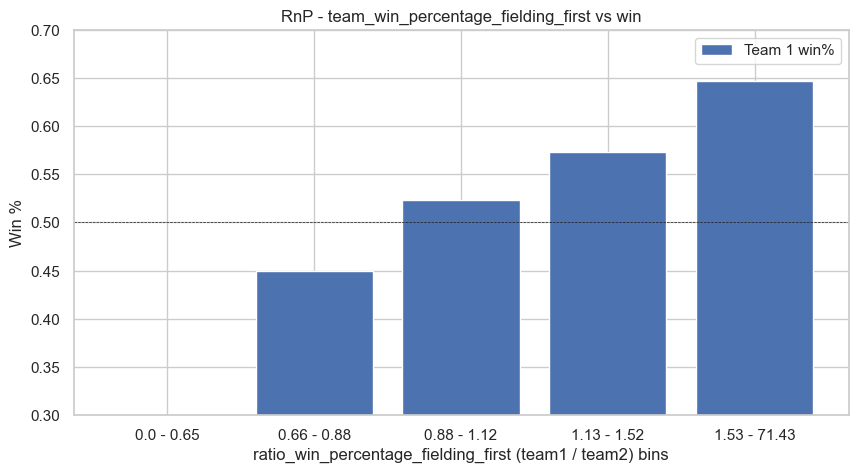

Correlation between team_win_percentage_fielding_first and winner_01 is: -0.08742231380636549


In [103]:
createRnP(train_data, 'team_win_percentage_fielding_first')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


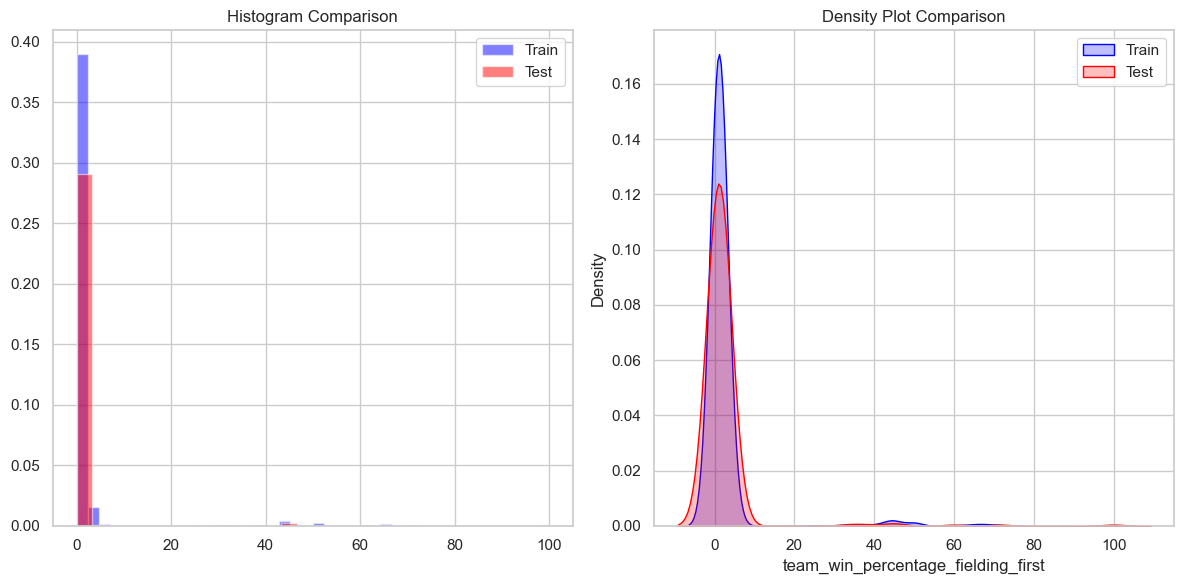

Kolmogorov-Smirnov test result: KS statistic = 0.0431, p-value = 0.8078

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      2.588952    2.489498
std       8.579653    9.424597
min       0.000000    0.000000
25%       0.715503    0.666667
50%       1.000000    1.000000
75%       1.370924    1.423962
max      71.428571  100.000000


In [104]:
check_distribution_match(train_data['team_win_percentage_fielding_first'], test_data['team_win_percentage_fielding_first'])

In [105]:
# train_data = handle_outliers(train_data, 'team_win_percentage_fielding_first')
# test_data = handle_outliers(test_data, 'team_win_percentage_fielding_first')

remove_skew(train_data, 'team_win_percentage_fielding_first', method='quantile')
remove_skew(test_data, 'team_win_percentage_fielding_first', method='quantile', train=False)

Skewness of team_win_percentage_fielding_first was 5.828009260432682. quantile transformation applied. New skewness is -1.6530617003435406
Skewness of team_win_percentage_fielding_first was 7.440560949116585. quantile transformation applied. New skewness is -1.2256769705188204


/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2667: UserWarning: n_quantiles (1000) is greater than the total number of samples (948). n_quantiles is set to n_samples.
  warnings.warn(


slope: 0.65 / 0.29 =  2.24


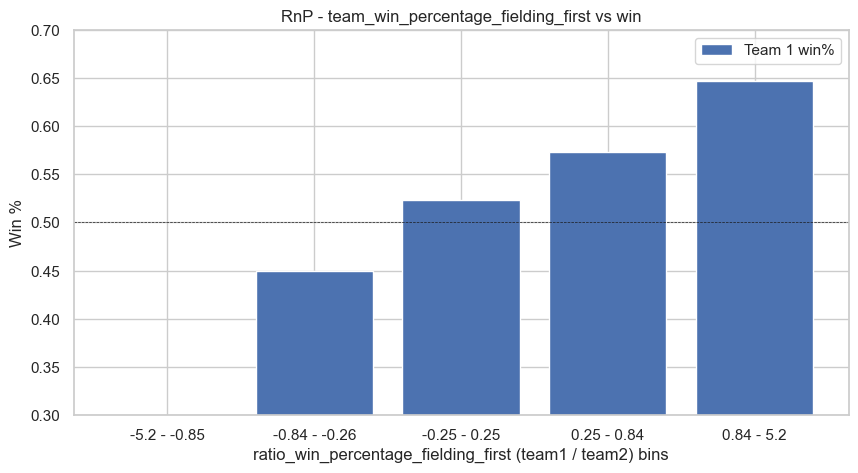

Correlation between team_win_percentage_fielding_first and winner_01 is: -0.21944673230064346


In [106]:
createRnP(train_data, 'team_win_percentage_fielding_first')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


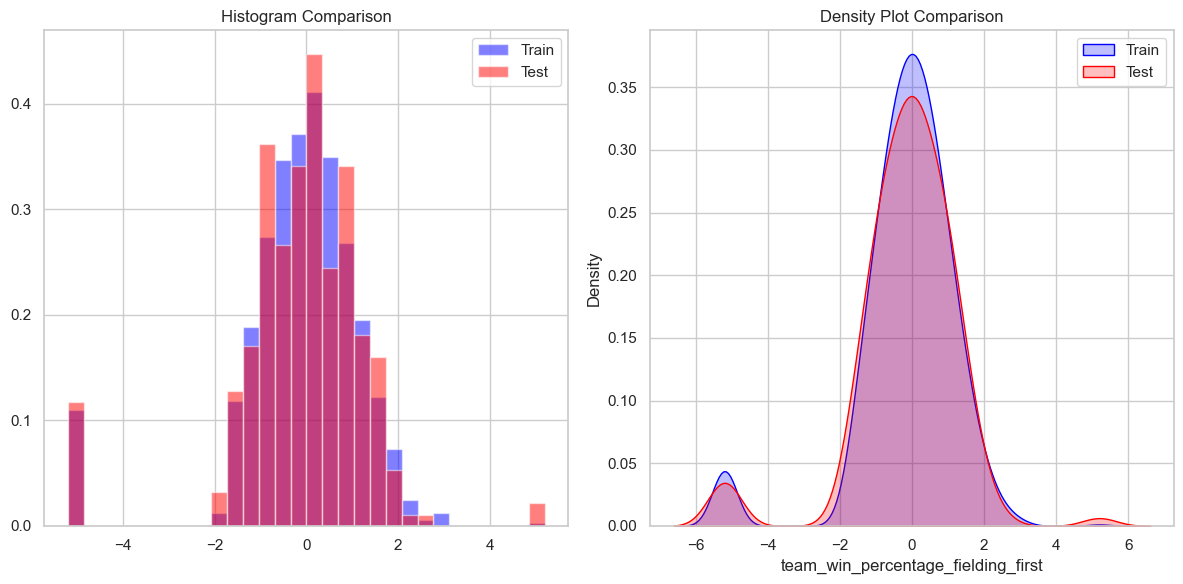

Kolmogorov-Smirnov test result: KS statistic = 0.0431, p-value = 0.8078

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean     -0.111712   -0.144699
std       1.362057    1.440214
min      -5.199338   -5.199338
25%      -0.674490   -0.805945
50%       0.010588    0.010588
75%       0.674490    0.722246
max       5.199338    5.199338


In [107]:
check_distribution_match(train_data['team_win_percentage_fielding_first'], test_data['team_win_percentage_fielding_first'])

## Added

1

In [108]:
def team_wicket_loss_average(team_id, date, match_lvl_data):
    team_matches = match_lvl_data[
        (match_lvl_data['match_dt'] < date) &
        ((match_lvl_data['team1_id'] == team_id) | (match_lvl_data['team2_id'] == team_id))
    ]
    team_wickets = team_matches.apply(
        lambda x: x['inning1_wickets'] if x['team1_id'] == team_id else x['inning2_wickets'], axis=1
    )
    return team_wickets.mean() if len(team_wickets) > 0 else 0

train_data['team1_wicket_loss_average'] = train_data.apply(
    lambda x: team_wicket_loss_average(
        team_id=x['team1_id'],
        date=x['match_dt'],
        match_lvl_data=match_lvl_data
    ), axis=1
)

train_data['team2_wicket_loss_average'] = train_data.apply(
    lambda x: team_wicket_loss_average(
        team_id=x['team2_id'],
        date=x['match_dt'],
        match_lvl_data=match_lvl_data
    ), axis=1
)

train_data = add_ratio_column(train_data, 'team1_wicket_loss_average', 'team2_wicket_loss_average', 'team_wicket_loss_average')

train_data = train_data.drop(columns=['team1_wicket_loss_average', 'team2_wicket_loss_average'])

test_data['team1_wicket_loss_average'] = test_data.apply(
    lambda x: team_wicket_loss_average(
        team_id=x['team1_id'],
        date=x['match_dt'],
        match_lvl_data=match_lvl_data
    ), axis=1
)

test_data['team2_wicket_loss_average'] = test_data.apply(
    lambda x: team_wicket_loss_average(
        team_id=x['team2_id'],
        date=x['match_dt'],
        match_lvl_data=match_lvl_data
    ), axis=1
)

test_data = add_ratio_column(test_data, 'team1_wicket_loss_average', 'team2_wicket_loss_average', 'team_wicket_loss_average')

test_data = test_data.drop(columns=['team1_wicket_loss_average', 'team2_wicket_loss_average'])

slope: 0.53 / 0.47 =  1.14


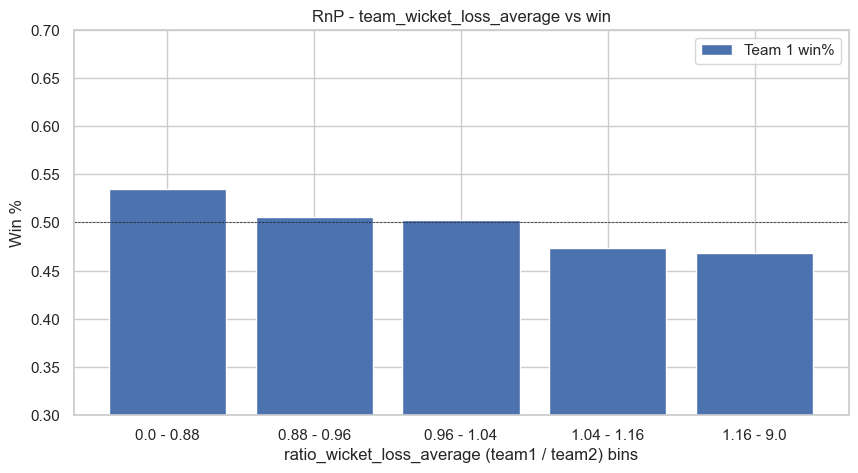

Correlation between team_wicket_loss_average and winner_01 is: -0.012728204099509413


In [109]:
createRnP(train_data, 'team_wicket_loss_average')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


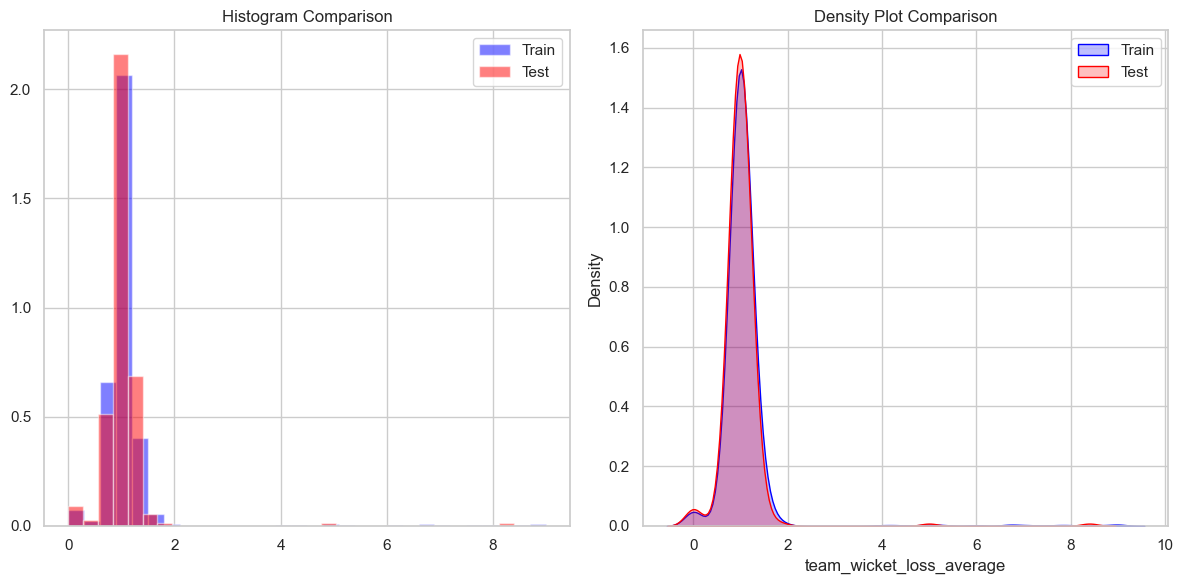

Kolmogorov-Smirnov test result: KS statistic = 0.1095, p-value = 0.0115

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.085126    1.012449
std       0.743221    0.563005
min       0.000000    0.000000
25%       0.909314    0.877306
50%       1.008309    0.985822
75%       1.122680    1.095405
max       9.000000    8.400000


In [110]:
check_distribution_match(train_data['team_wicket_loss_average'], test_data['team_wicket_loss_average'])

In [111]:
remove_skew(train_data, 'team_wicket_loss_average', method='quantile')
remove_skew(test_data, 'team_wicket_loss_average', method='quantile', train=False)

Skewness of team_wicket_loss_average was 7.615976105642051. quantile transformation applied. New skewness is -1.2409884734694494
Skewness of team_wicket_loss_average was 9.614507633194362. quantile transformation applied. New skewness is -1.5088212413499344


/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2667: UserWarning: n_quantiles (1000) is greater than the total number of samples (948). n_quantiles is set to n_samples.
  warnings.warn(


2.

In [112]:
def team_win_rate_at_venue(team_id, venue_id, date, match_lvl_data):
    # Filter matches where the team played at the given venue up to the specified date
    relevant_matches = match_lvl_data[(match_lvl_data['ground_id'] == venue_id) &
                                      ((match_lvl_data['team1_id'] == team_id) | (match_lvl_data['team2_id'] == team_id)) &
                                      (match_lvl_data['match_dt'] < date)]
    wins = relevant_matches['winner_id'].apply(lambda x: 1 if x == team_id else 0).sum()
    win_rate = wins / len(relevant_matches) if len(relevant_matches) > 0 else 0
    return win_rate

train_data['team1_win_rate_at_venue'] = train_data.apply(
    lambda x: team_win_rate_at_venue(
        team_id=x['team1_id'],
        venue_id=x['ground_id'],
        date=x['match_dt'],
        match_lvl_data=match_lvl_data
    ), axis=1
)

train_data['team2_win_rate_at_venue'] = train_data.apply(
    lambda x: team_win_rate_at_venue(
        team_id=x['team2_id'],
        venue_id=x['ground_id'],
        date=x['match_dt'],
        match_lvl_data=match_lvl_data
    ), axis=1
)

train_data = add_ratio_column(train_data, 'team1_win_rate_at_venue', 'team2_win_rate_at_venue', 'team_win_rate_at_venue')

train_data = train_data.drop(columns=['team1_win_rate_at_venue', 'team2_win_rate_at_venue'])

test_data['team1_win_rate_at_venue'] = test_data.apply(
    lambda x: team_win_rate_at_venue(
        team_id=x['team1_id'],
        venue_id=x['ground_id'],
        date=x['match_dt'],
        match_lvl_data=match_lvl_data
    ), axis=1
)

test_data['team2_win_rate_at_venue'] = test_data.apply(
    lambda x: team_win_rate_at_venue(
        team_id=x['team2_id'],
        venue_id=x['ground_id'],
        date=x['match_dt'],
        match_lvl_data=match_lvl_data
    ), axis=1
)

test_data = add_ratio_column(test_data, 'team1_win_rate_at_venue', 'team2_win_rate_at_venue', 'team_win_rate_at_venue')

test_data = test_data.drop(columns=['team1_win_rate_at_venue', 'team2_win_rate_at_venue'])

slope: 0.56 / 0.47 =  1.2


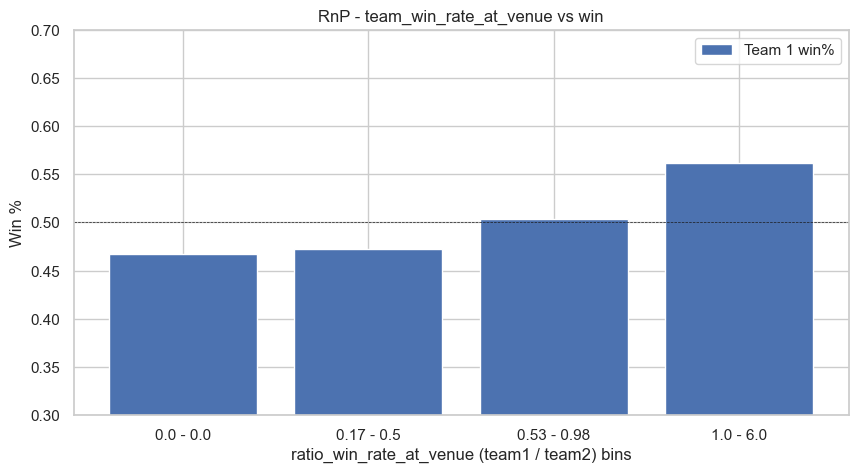

Correlation between team_win_rate_at_venue and winner_01 is: -0.053605345112640965


In [113]:
createRnP(train_data, 'team_win_rate_at_venue')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


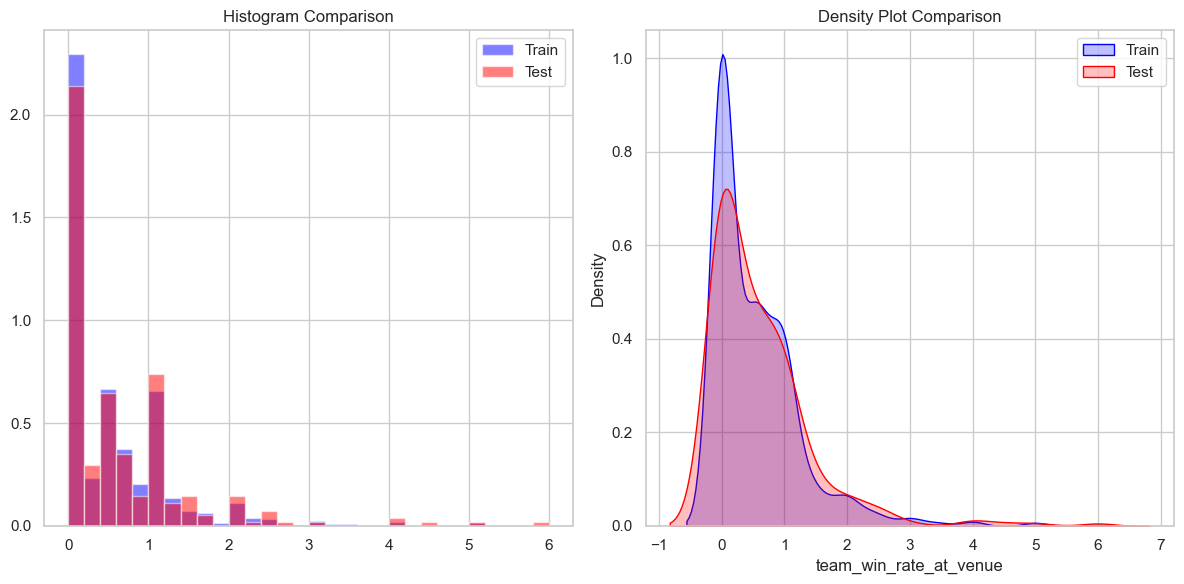

Kolmogorov-Smirnov test result: KS statistic = 0.0447, p-value = 0.7729

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      0.542736    0.610468
std       0.740733    0.848285
min       0.000000    0.000000
25%       0.000000    0.000000
50%       0.375000    0.428571
75%       0.930804    1.000000
max       6.000000    6.000000


In [114]:
check_distribution_match(train_data['team_win_rate_at_venue'], test_data['team_win_rate_at_venue'])

In [115]:
remove_skew(train_data, 'team_win_rate_at_venue', method='quantile')
remove_skew(test_data, 'team_win_rate_at_venue', method='quantile', train=False)

Skewness of team_win_rate_at_venue was 2.4483816809082177. quantile transformation applied. New skewness is -0.08780541671471663
Skewness of team_win_rate_at_venue was 2.6971569822552794. quantile transformation applied. New skewness is -0.17436014022474944


/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2667: UserWarning: n_quantiles (1000) is greater than the total number of samples (948). n_quantiles is set to n_samples.
  warnings.warn(


3

In [116]:
def team_batsman_performance_index(bat_df, match_id, team_roster_ids, date, n=5):
    team_ids = str(team_roster_ids).split(':')
    total_performance_index = 0

    for player_id in team_ids:
        recent_matches = giveLastNgamesPlayer(player_id=player_id, date=date, n=n, bat_or_bowl='bat')
        if not recent_matches.empty:
            player_performance = (recent_matches['runs'] * 0.5 +
                                  recent_matches['strike_rate'] * 0.3 +
                                  (recent_matches['Fours'] + recent_matches['Sixes'] * 2) * 0.2) * \
                                  (1 + 0.1 * recent_matches['is_batsman_captain'].iloc[0] +
                                   0.05 * recent_matches['is_batsman_keeper'].iloc[0])
            total_performance_index += player_performance.sum()

    return total_performance_index

train_data['team1_batsman_performance_index'] = train_data.apply(
    lambda x: team_batsman_performance_index(batsman_lvl_data, x['match id'], x['team1_roster_ids'], x['match_dt']),
    axis=1
)
train_data['team2_batsman_performance_index'] = train_data.apply(
    lambda x: team_batsman_performance_index(batsman_lvl_data, x['match id'], x['team2_roster_ids'], x['match_dt']),
    axis=1
)

train_data = add_ratio_column(train_data, 'team1_batsman_performance_index', 'team2_batsman_performance_index', 'team_batsman_performance_index')

train_data = train_data.drop(columns=['team1_batsman_performance_index', 'team2_batsman_performance_index'])

test_data['team1_batsman_performance_index'] = test_data.apply(
    lambda x: team_batsman_performance_index(batsman_lvl_data, x['match id'], x['team1_roster_ids'], x['match_dt']),
    axis=1
)
test_data['team2_batsman_performance_index'] = test_data.apply(
    lambda x: team_batsman_performance_index(batsman_lvl_data, x['match id'], x['team2_roster_ids'], x['match_dt']),
    axis=1
)

test_data = add_ratio_column(test_data, 'team1_batsman_performance_index', 'team2_batsman_performance_index', 'team_batsman_performance_index')

test_data = test_data.drop(columns=['team1_batsman_performance_index', 'team2_batsman_performance_index'])

slope: 0.56 / 0.38 =  1.46


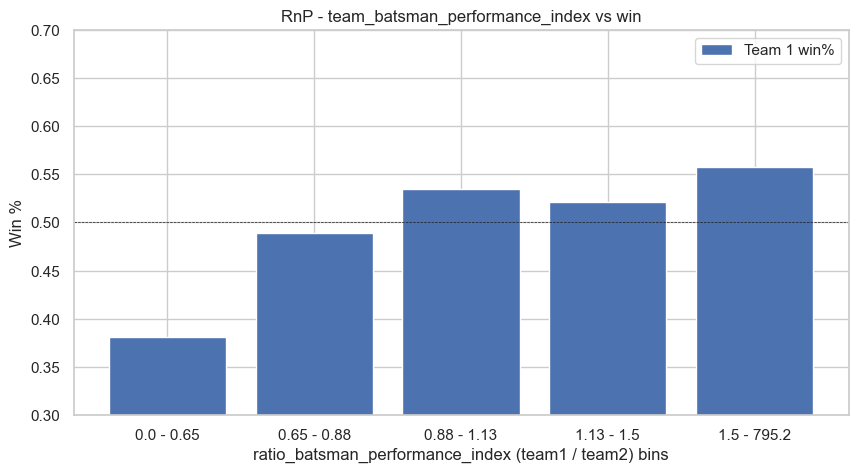

Correlation between team_batsman_performance_index and winner_01 is: -0.04003766613639936


In [117]:
createRnP(train_data, 'team_batsman_performance_index')

In [118]:
# train_data = handle_outliers(train_data, 'team_batsman_performance_index')
# test_data = handle_outliers(test_data, 'team_batsman_performance_index')

remove_skew(train_data, 'team_batsman_performance_index', method='quantile')
remove_skew(test_data, 'team_batsman_performance_index', method='quantile', train=False)

Skewness of team_batsman_performance_index was 12.449616793480345. quantile transformation applied. New skewness is -1.359370114009024
Skewness of team_batsman_performance_index was 16.283788203031076. quantile transformation applied. New skewness is -1.3028202795544273


/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2667: UserWarning: n_quantiles (1000) is greater than the total number of samples (948). n_quantiles is set to n_samples.
  warnings.warn(


/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


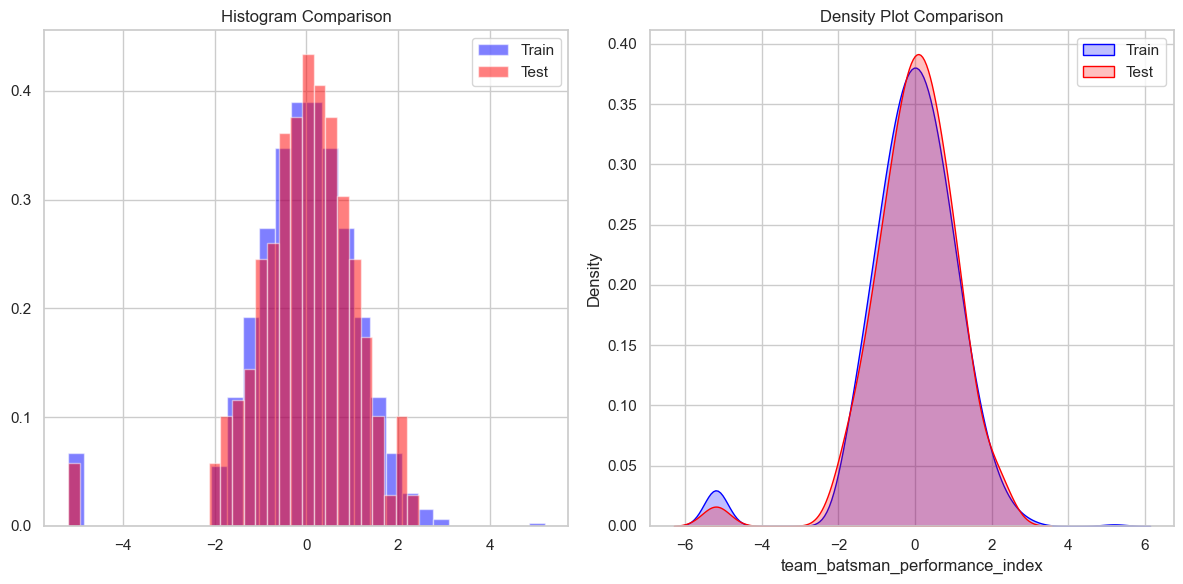

Kolmogorov-Smirnov test result: KS statistic = 0.0409, p-value = 0.8554

Descriptive Statistics Comparison:
        Train Stats  Test Stats
count  9.480000e+02  271.000000
mean  -6.322290e-02   -0.012944
std    1.230942e+00    1.121032
min   -5.199338e+00   -5.199338
25%   -6.744904e-01   -0.615070
50%   -1.392116e-16    0.097209
75%    6.744904e-01    0.683611
max    5.199338e+00    2.456836


In [119]:
check_distribution_match(train_data['team_batsman_performance_index'], test_data['team_batsman_performance_index'])

4

In [120]:
def overall_historical_win_rate(match_lvl_data, team_id, date):
    historical_matches = match_lvl_data[((match_lvl_data['team1_id'] == team_id) | (match_lvl_data['team2_id'] == team_id)) &
                                        (match_lvl_data['match_dt'] < date)]
    wins = historical_matches['winner_id'].apply(lambda x: 1 if x == team_id else 0).sum()
    total_matches = len(historical_matches)
    return wins / total_matches if total_matches > 0 else 0

train_data['team1_overall_win_rate'] = train_data.apply(
    lambda x: overall_historical_win_rate(match_lvl_data, x['team1_id'], x['match_dt']),
    axis=1
)
train_data['team2_overall_win_rate'] = train_data.apply(
    lambda x: overall_historical_win_rate(match_lvl_data, x['team2_id'], x['match_dt']),
    axis=1
)

train_data = add_ratio_column(train_data, 'team1_overall_win_rate', 'team2_overall_win_rate', 'team_overall_win_rate')

train_data = train_data.drop(columns=['team1_overall_win_rate', 'team2_overall_win_rate'])

test_data['team1_overall_win_rate'] = test_data.apply(
    lambda x: overall_historical_win_rate(match_lvl_data, x['team1_id'], x['match_dt']),
    axis=1
)
test_data['team2_overall_win_rate'] = test_data.apply(
    lambda x: overall_historical_win_rate(match_lvl_data, x['team2_id'], x['match_dt']),
    axis=1
)

test_data = add_ratio_column(test_data, 'team1_overall_win_rate', 'team2_overall_win_rate', 'team_overall_win_rate')

test_data = test_data.drop(columns=['team1_overall_win_rate', 'team2_overall_win_rate'])

slope: 0.57 / 0.43 =  1.33


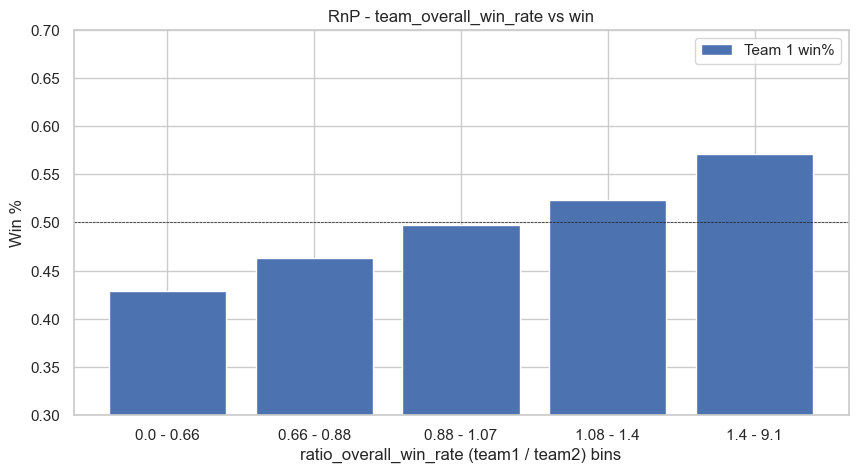

Correlation between team_overall_win_rate and winner_01 is: -0.0997730874267899


In [121]:
createRnP(train_data, 'team_overall_win_rate')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


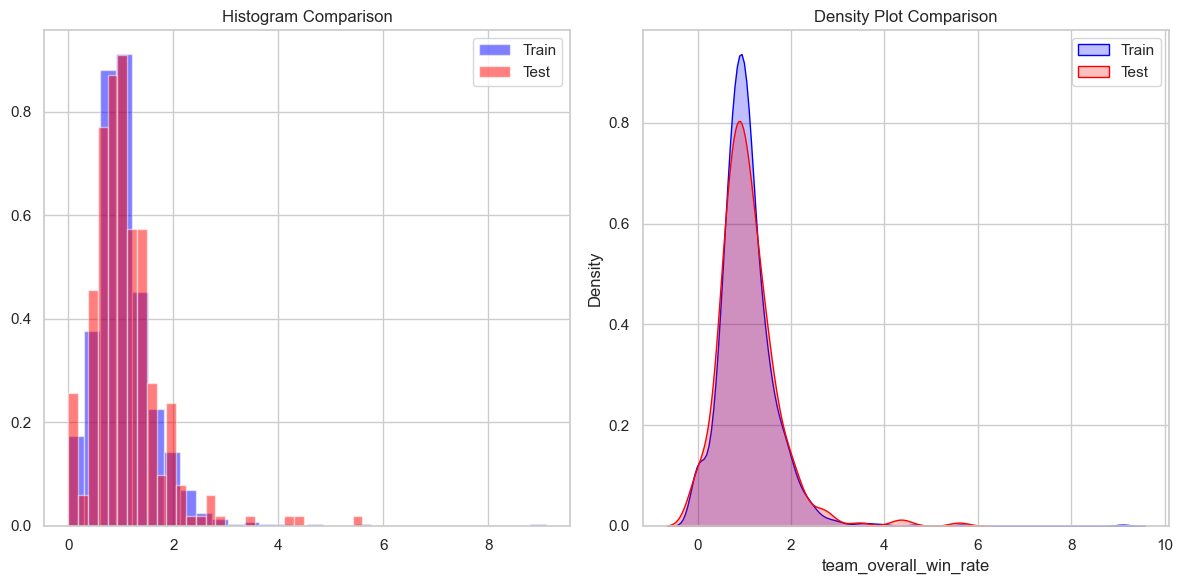

Kolmogorov-Smirnov test result: KS statistic = 0.0415, p-value = 0.8432

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.055088    1.078534
std       0.622973    0.670776
min       0.000000    0.000000
25%       0.717949    0.688018
50%       0.977346    0.969231
75%       1.285714    1.355731
max       9.100000    5.600000


In [122]:
check_distribution_match(train_data['team_overall_win_rate'], test_data['team_overall_win_rate'])

In [123]:
remove_skew(train_data, 'team_overall_win_rate', method='quantile')
remove_skew(test_data, 'team_overall_win_rate', method='quantile', train=False)

Skewness of team_overall_win_rate was 3.490573489976669. quantile transformation applied. New skewness is -1.6895356565675712
Skewness of team_overall_win_rate was 2.3412361291253334. quantile transformation applied. New skewness is -1.6323802734006134


/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2667: UserWarning: n_quantiles (1000) is greater than the total number of samples (948). n_quantiles is set to n_samples.
  warnings.warn(


5

In [124]:
def avg_win_margin_runs(matches, team_id, date):
    win_by_runs_matches = matches[(matches['by'] == 'runs') & ((matches['team1_id'] == team_id) | (matches['team2_id'] == team_id)) & (matches['match_dt'] < date)]
    total_margin = win_by_runs_matches[win_by_runs_matches['winner_id'] == team_id]['win amount'].sum()
    total_matches = win_by_runs_matches[win_by_runs_matches['winner_id'] == team_id].shape[0]
    return total_margin / total_matches if total_matches > 0 else 0

train_data['team1_avg_win_margin_runs'] = train_data.apply(lambda x: avg_win_margin_runs(match_lvl_data, x['team1_id'], x['match_dt']), axis=1)
train_data['team2_avg_win_margin_runs'] = train_data.apply(lambda x: avg_win_margin_runs(match_lvl_data, x['team2_id'], x['match_dt']), axis=1)

train_data = add_ratio_column(train_data, 'team1_avg_win_margin_runs', 'team2_avg_win_margin_runs', 'team_avg_win_margin_runs')

train_data = train_data.drop(columns=['team1_avg_win_margin_runs', 'team2_avg_win_margin_runs'])

test_data['team1_avg_win_margin_runs'] = test_data.apply(lambda x: avg_win_margin_runs(match_lvl_data, x['team1_id'], x['match_dt']), axis=1)
test_data['team2_avg_win_margin_runs'] = test_data.apply(lambda x: avg_win_margin_runs(match_lvl_data, x['team2_id'], x['match_dt']), axis=1)

test_data = add_ratio_column(test_data, 'team1_avg_win_margin_runs', 'team2_avg_win_margin_runs', 'team_avg_win_margin_runs')

test_data = test_data.drop(columns=['team1_avg_win_margin_runs', 'team2_avg_win_margin_runs'])

slope: 0.53 / 0.44 =  1.2


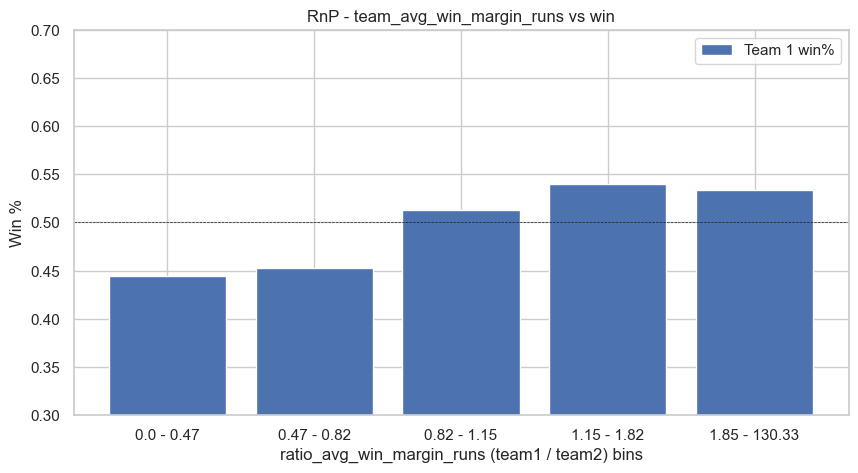

Correlation between team_avg_win_margin_runs and winner_01 is: -0.03073344181156112


In [125]:
createRnP(train_data, 'team_avg_win_margin_runs')

In [126]:
check_distribution_match(train_data['team_avg_win_margin_runs'], test_data['team_avg_win_margin_runs'])

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Kolmogorov-Smirnov test result: KS statistic = 0.0662, p-value = 0.2972

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      3.146298    2.660165
std       9.426177    6.618963
min       0.000000    0.000000
25%       0.589105    0.621948
50%       0.993953    1.024614
75%       1.597176    1.749286
max     130.333333   50.076923


In [127]:
# train_data = handle_outliers(train_data, 'team_avg_win_margin_runs')
# test_data = handle_outliers(test_data, 'team_avg_win_margin_runs')

remove_skew(train_data, 'team_avg_win_margin_runs', method='quantile')
remove_skew(test_data, 'team_avg_win_margin_runs', method='quantile', train=False)

Skewness of team_avg_win_margin_runs was 6.921814274039963. quantile transformation applied. New skewness is -1.7216934959984034
Skewness of team_avg_win_margin_runs was 4.948477463745763. quantile transformation applied. New skewness is -1.8049940671433415


/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2667: UserWarning: n_quantiles (1000) is greater than the total number of samples (948). n_quantiles is set to n_samples.
  warnings.warn(


6

In [128]:
def winpLastn_venue(team_id, date, ground_id,n):
    '''
    Get a team's win % in last n games. If a team has won 3 game out of their last 5, win% is 60%.
    
    Input-
    1. team_id: ID of the team to get their last n games and winner information from those games.
    2. date: match date from which to get last n historical games.
    3. n: look-back window of games.
    
    Output- None
    
    Returns- Float value denoting win% of the team in last n games.
    '''
    # filter out games with either team1/2_id as input team id, match_dt being before current game's date, sort desc by date, and get top n rows (games)
    df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&\
                      ((match_lvl_data['team1_id']==team_id)|(match_lvl_data['team2_id']==team_id) & (match_lvl_data['ground_id']==ground_id))]\
                        .sort_values(by='match_dt', ascending=False).head(n) 
    win_count = df_rel[df_rel['winner_id']==team_id].shape[0] # count number of rows having winner as the input team
    if win_count == 0:
        return 0
    return round(win_count*100/df_rel.shape[0], 2) # return win% rounded to two decimal points

train_data['team1_winp_venue'] = train_data.progress_apply(lambda x: \
                                  winpLastn_venue(x['team1_id'], x['match_dt'],x['ground_id'], 15), axis=1)

train_data['team2_winp_venue'] = train_data.progress_apply(lambda x: \
                                  winpLastn_venue(x['team2_id'], x['match_dt'],x['ground_id'], 15), axis=1)

train_data = add_ratio_column(train_data, 'team1_winp_venue', 'team2_winp_venue', 'team_winp_venue')

train_data = train_data.drop(columns=['team1_winp_venue', 'team2_winp_venue'])

test_data['team1_winp_venue'] = test_data.progress_apply(lambda x: \
                                winpLastn_venue(x['team1_id'], x['match_dt'],x['ground_id'], 15), axis=1)

test_data['team2_winp_venue'] = test_data.progress_apply(lambda x: \
                                winpLastn_venue(x['team2_id'], x['match_dt'],x['ground_id'], 15), axis=1)

test_data = add_ratio_column(test_data, 'team1_winp_venue', 'team2_winp_venue', 'team_winp_venue')

test_data = test_data.drop(columns=['team1_winp_venue', 'team2_winp_venue'])

100%|██████████| 271/271 [00:00<00:00, 1275.03it/s]


slope: 0.56 / 0.4 =  1.42


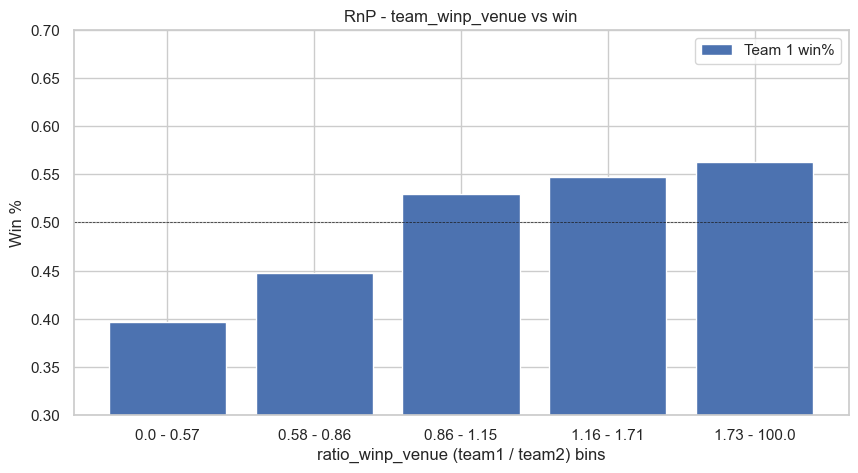

Correlation between team_winp_venue and winner_01 is: -0.05312515097696646


In [129]:
createRnP(train_data, 'team_winp_venue')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


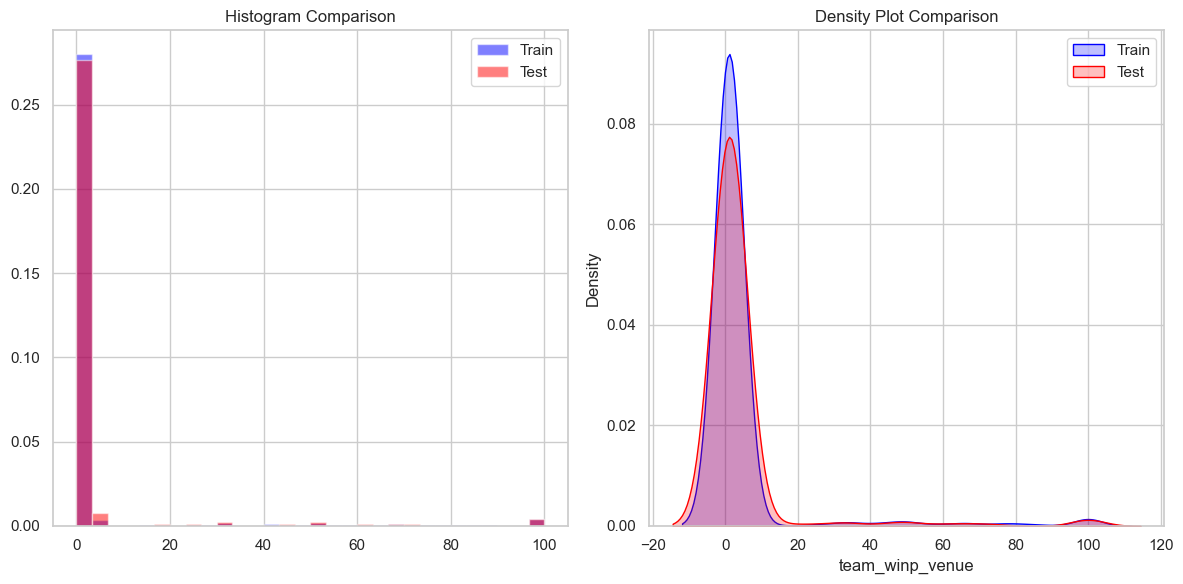

Kolmogorov-Smirnov test result: KS statistic = 0.0630, p-value = 0.3556

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      4.492258    4.253280
std      15.602713   14.798107
min       0.000000    0.000000
25%       0.650037    0.687004
50%       1.000000    1.047612
75%       1.500150    1.658566
max     100.000000  100.000000


In [130]:
check_distribution_match(train_data['team_winp_venue'], test_data['team_winp_venue'])

In [131]:
# train_data = handle_outliers(train_data, 'team_winp_venue')
# test_data = handle_outliers(test_data, 'team_winp_venue')

remove_skew(train_data, 'team_winp_venue', method='quantile')
remove_skew(test_data, 'team_winp_venue', method='quantile', train=False)

Skewness of team_winp_venue was 4.86724826469129. quantile transformation applied. New skewness is -1.198932297037219
Skewness of team_winp_venue was 5.255732985480996. quantile transformation applied. New skewness is -1.2036126505632267


/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2667: UserWarning: n_quantiles (1000) is greater than the total number of samples (948). n_quantiles is set to n_samples.
  warnings.warn(


## More

1.

In [132]:
def assign_toss_winner_flag(row):
    if row['team1'] == row['toss winner']:
        return row['team1_id']
    elif row['team2'] == row['toss winner']:
        return row['team2_id']
train_data['toss_winner_id'] = train_data.apply(assign_toss_winner_flag, axis=1)
match_lvl_data['toss_winner_id'] = match_lvl_data.apply(assign_toss_winner_flag, axis=1)
test_data['toss_winner_id']= test_data.apply(assign_toss_winner_flag, axis=1)

def assign_bat(row):
    if (row['toss_winner_id'] == row['team1_id']) & (row['toss decision']=='bat'):
        return row['team1_id']
    if (row['toss_winner_id'] != row['team1_id']) & (row['toss decision']=='field'):
        return row['team1_id']
    else:
        return row['team2_id']
train_data['bat_id'] = train_data.apply(assign_bat, axis=1) 
match_lvl_data['bat_id'] = match_lvl_data.apply(assign_bat, axis=1)
test_data['bat_id'] = test_data.apply(assign_bat, axis=1)

In [133]:
def teamAvgRunsLastn_innings1(team_id, bat_id,date, n):
    '''
    Function to calculate a team's average runs in their last n games.
    
    Input-
    1. team_id: ID of the team to calculate average runs.
    2. date: match date of the current game for which the feature is calculated.
    3. n: look-back window of games for the team.
    
    Output- None
    
    Return- Float value denoting average of runs scored by team1 in their last n games.
    '''
    # filter out games with either team1/2_id as input team_id, match date less than current game's input date, sort desc by date, and top n rows (games) returned
    
    df_rel = match_lvl_data[(match_lvl_data['match_dt']<date)&\
                    ((match_lvl_data['team1_id']==team_id)|(match_lvl_data['team2_id']==team_id) & (match_lvl_data['bat_id']==team_id))]\
                        .sort_values(by='match_dt', ascending=False).head(n)
    return df_rel['inning1_runs'].mean()

train_data['runs_team1_1st_inning']= train_data.progress_apply(lambda x: \
                                 teamAvgRunsLastn_innings1(x['team1_id'],x['bat_id'], x['match_dt'], 15), axis=1)
train_data['runs_team2_1st_inning']= train_data.progress_apply(lambda x: \
                                  teamAvgRunsLastn_innings1(x['team2_id'],x['bat_id'], x['match_dt'], 15), axis=1)

train_data = add_ratio_column(train_data, 'runs_team1_1st_inning', 'runs_team2_1st_inning', 'team_avg_runs_1st_inning')

train_data = train_data.drop(columns=['runs_team1_1st_inning', 'runs_team2_1st_inning'])

test_data['runs_team1_1st_inning']= test_data.progress_apply(lambda x: \
                                    teamAvgRunsLastn_innings1(x['team1_id'],x['bat_id'], x['match_dt'], 15), axis=1)

test_data['runs_team2_1st_inning']= test_data.progress_apply(lambda x: \
                                    teamAvgRunsLastn_innings1(x['team2_id'],x['bat_id'], x['match_dt'], 15), axis=1)

test_data = add_ratio_column(test_data, 'runs_team1_1st_inning', 'runs_team2_1st_inning', 'team_avg_runs_1st_inning')

test_data = test_data.drop(columns=['runs_team1_1st_inning', 'runs_team2_1st_inning'])

100%|██████████| 271/271 [00:00<00:00, 1442.40it/s]


slope: 0.55 / 0.44 =  1.25


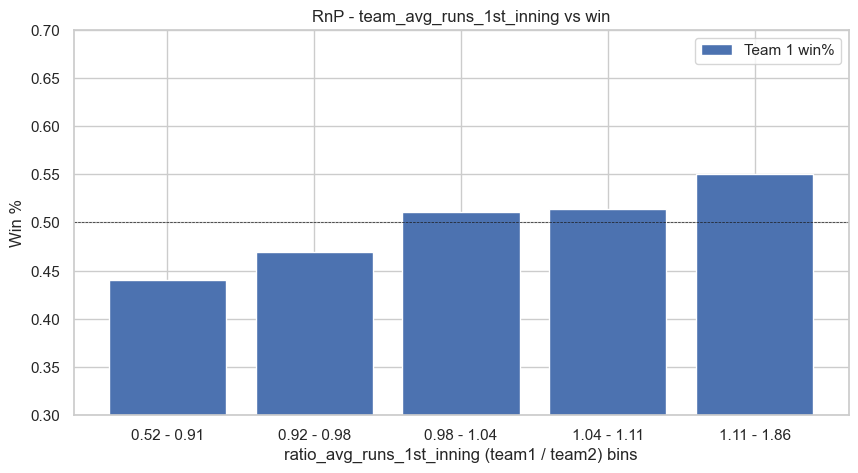

Correlation between team_avg_runs_1st_inning and winner_01 is: -0.08210253516941837


In [134]:
createRnP(train_data, 'team_avg_runs_1st_inning')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


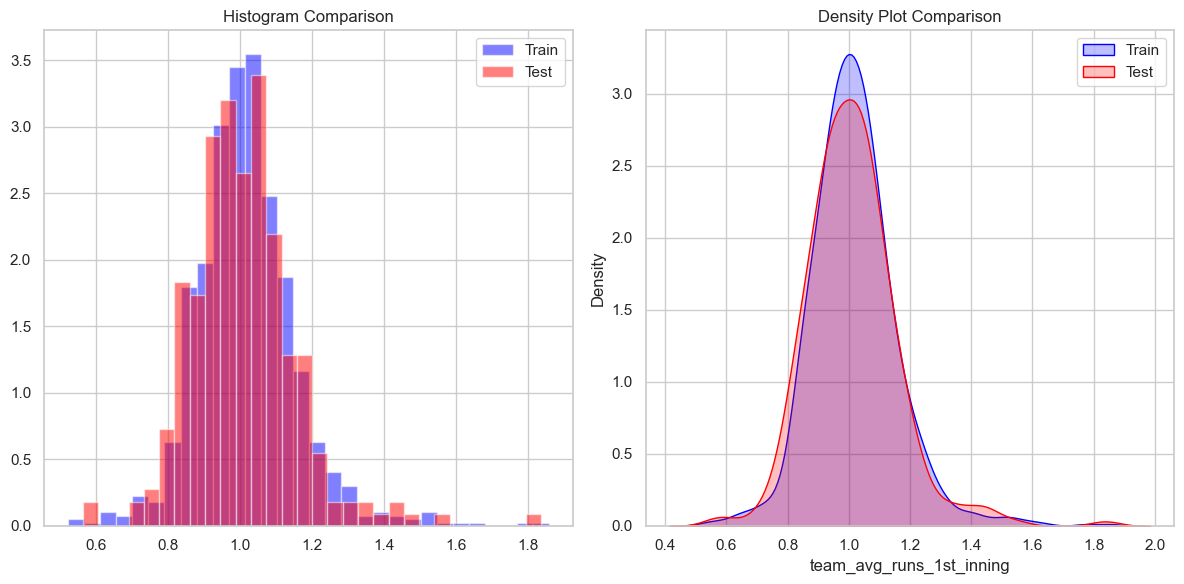

Kolmogorov-Smirnov test result: KS statistic = nan, p-value = nan

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   887.000000  257.000000
mean      1.016814    1.009674
std       0.141082    0.147750
min       0.523536    0.563282
25%       0.931371    0.919311
50%       1.007966    1.001393
75%       1.087347    1.082585
max       1.858280    1.838217


In [135]:
check_distribution_match(train_data['team_avg_runs_1st_inning'], test_data['team_avg_runs_1st_inning'])

2.

In [136]:
def EcoLastn(player_list, date, n):
    '''
    Function to get the average strike rate of players in the roster of a team in the last n games.
    
    Input:
    1. player_list: ':' separated list of player ids in the roster of a team.
    2. date: match date of the game to calculate this feature.
    3. n: Number of games to look-back and create this feature.
    
    Output: None
    
    Returns: float value denoting the average strike rate of all players in the roster.
    '''
    
    # Split the player_list into individual player IDs
    player_list = str(player_list).split(':')
    res_list = []
    
    # Loop through each player ID
    for player in player_list:
        # Get batting stats from the last n games for each player
        df_rel = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bowl')
        # Calculate the mean strike rate for the player and append it to res_list
        if not df_rel.empty:
            res_list.append(np.nanmean(df_rel['economy']))
    
    # Return the mean of strike rates from res_list if it contains any values
    if res_list:
        return np.nanmean(res_list)
    else:
        return np.nan  # Return NaN if res_list is empty
    
train_data['team1_avg_eco'] = train_data.progress_apply(lambda x: \
            EcoLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['team2_avg_eco'] = train_data.progress_apply(lambda x: \
            EcoLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data = add_ratio_column(train_data, 'team1_avg_eco', 'team2_avg_eco', 'team_avg_eco')

train_data = train_data.drop(columns=['team1_avg_eco', 'team2_avg_eco'])

test_data['team1_avg_eco'] = test_data.progress_apply(lambda x: \
            EcoLastn(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data['team2_avg_eco'] = test_data.progress_apply(lambda x: \
            EcoLastn(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data = add_ratio_column(test_data, 'team1_avg_eco', 'team2_avg_eco', 'team_avg_eco')

test_data = test_data.drop(columns=['team1_avg_eco', 'team2_avg_eco'])

100%|██████████| 271/271 [00:03<00:00, 75.80it/s]


In [137]:
train_data['team_avg_eco'].fillna(0, inplace=True)
test_data['team_avg_eco'].fillna(0, inplace=True)

/var/folders/z7/t3qmw89j637f4y58ls6cb_vh0000gn/T/ipykernel_50413/2488158631.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['team_avg_eco'].fillna(0, inplace=True)
/var/folders/z7/t3qmw89j637f4y58ls6cb_vh0000gn/T/ipykernel_50413/2488158631.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

slope: 0.55 / 0.46 =  1.2


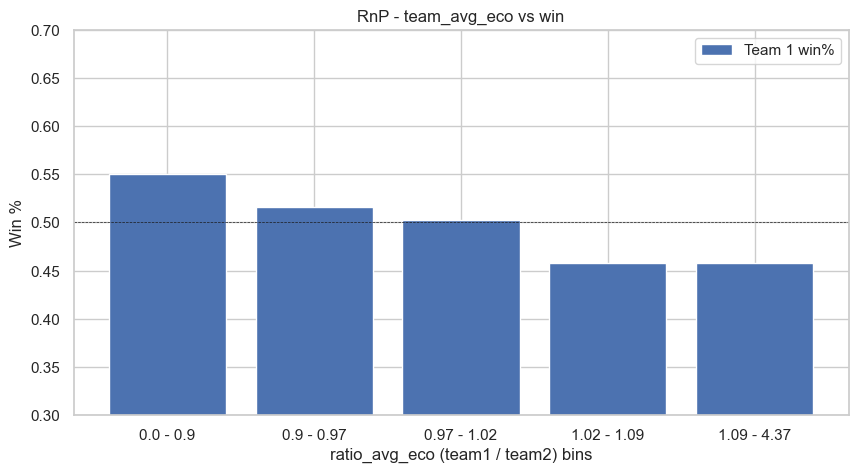

Correlation between team_avg_eco and winner_01 is: -0.010640867698874084


In [138]:
createRnP(train_data, 'team_avg_eco')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


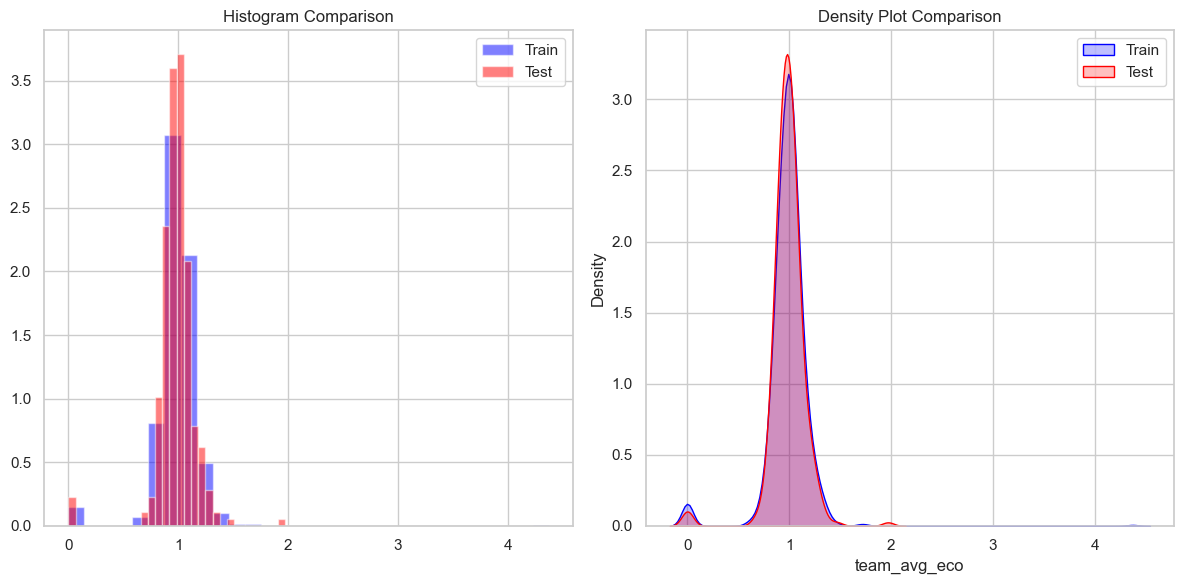

Kolmogorov-Smirnov test result: KS statistic = 0.0540, p-value = 0.5477

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      0.984224    0.983138
std       0.222947    0.176660
min       0.000000    0.000000
25%       0.915671    0.911923
50%       0.994028    0.984892
75%       1.064583    1.052212
max       4.371515    1.969705


In [139]:
check_distribution_match(train_data['team_avg_eco'], test_data['team_avg_eco'])

In [140]:
remove_skew(train_data, 'team_avg_eco', method='quantile')
remove_skew(test_data, 'team_avg_eco', method='quantile', train=False)

Skewness of team_avg_eco was 2.001852966895667. quantile transformation applied. New skewness is -1.3259753645771795
Skewness of team_avg_eco was -1.68466847436801. quantile transformation applied. New skewness is -1.1524184354858384


/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2667: UserWarning: n_quantiles (1000) is greater than the total number of samples (948). n_quantiles is set to n_samples.
  warnings.warn(


3.

In [141]:
def consistency_index(matches, team_id, date, n=5):
    recent_matches = matches[((matches['team1_id'] == team_id) | (matches['team2_id'] == team_id)) & (matches['match_dt'] < date)].sort_values(by='match_dt', ascending=False).head(n)
    total_matches = recent_matches.shape[0]
    if total_matches == 0:
        return 0
    
    wins = recent_matches[recent_matches['winner_id'] == team_id].shape[0]
    win_percentage = (wins / total_matches) * 100
    return win_percentage

# Apply to training data
train_data['team1_consistency_index'] = train_data.apply(lambda x: consistency_index(match_lvl_data, x['team1_id'], x['match_dt']), axis=1)
train_data['team2_consistency_index'] = train_data.apply(lambda x: consistency_index(match_lvl_data, x['team2_id'], x['match_dt']), axis=1)
train_data = add_ratio_column(train_data, 'team1_consistency_index', 'team2_consistency_index', 'consistency_index_ratio')

# Drop intermediate columns to avoid redundancy
train_data = train_data.drop(columns=['team1_consistency_index', 'team2_consistency_index'])

# Apply to test data
test_data['team1_consistency_index'] = test_data.apply(lambda x: consistency_index(match_lvl_data, x['team1_id'], x['match_dt']), axis=1)
test_data['team2_consistency_index'] = test_data.apply(lambda x: consistency_index(match_lvl_data, x['team2_id'], x['match_dt']), axis=1)
test_data = add_ratio_column(test_data, 'team1_consistency_index', 'team2_consistency_index', 'consistency_index_ratio')

# Drop intermediate columns to avoid redundancy
test_data = test_data.drop(columns=['team1_consistency_index', 'team2_consistency_index'])

slope: 0.58 / 0.41 =  1.44


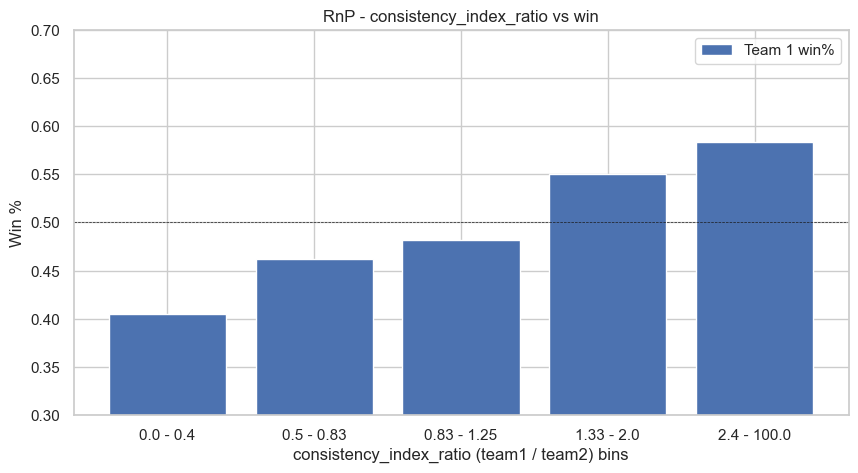

Correlation between consistency_index_ratio and winner_01 is: -0.011988735319849479


In [142]:
createRnP(train_data, 'consistency_index_ratio')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


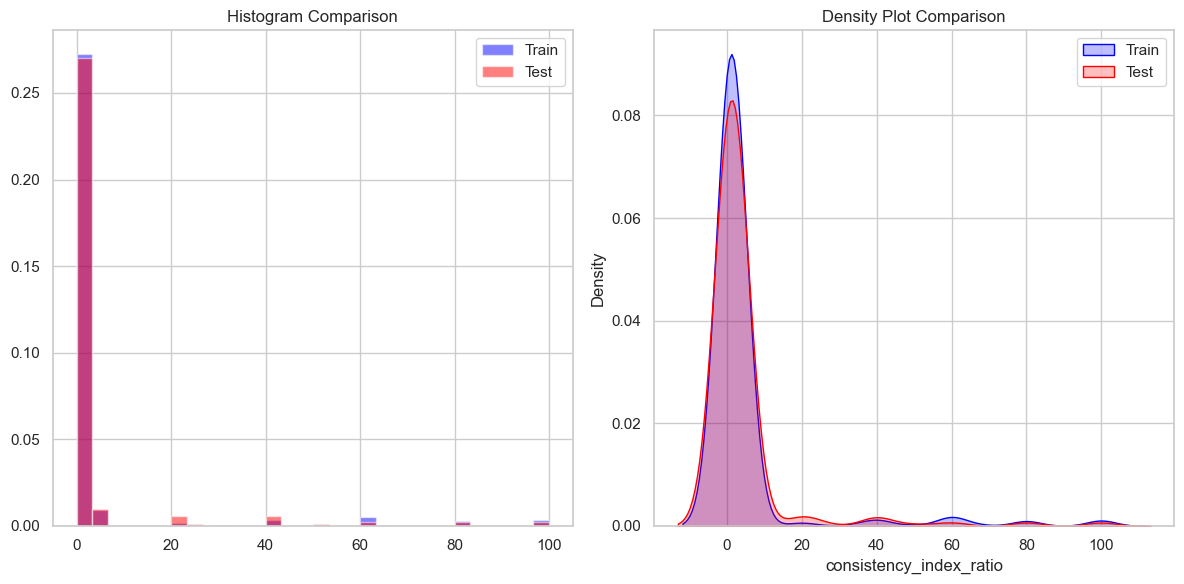

Kolmogorov-Smirnov test result: KS statistic = 0.0467, p-value = 0.7246

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      4.838880    4.312177
std      15.622568   13.431704
min       0.000000    0.000000
25%       0.500000    0.666667
50%       1.000000    1.000000
75%       2.000000    2.000000
max     100.000000  100.000000


In [143]:
check_distribution_match(train_data['consistency_index_ratio'], test_data['consistency_index_ratio'])

In [144]:
# train_data = handle_outliers(train_data, 'consistency_index_ratio')
# test_data = handle_outliers(test_data, 'consistency_index_ratio')

remove_skew(train_data, 'consistency_index_ratio', method='quantile')
remove_skew(test_data, 'consistency_index_ratio', method='quantile', train=False)

Skewness of consistency_index_ratio was 4.516880422121104. quantile transformation applied. New skewness is -1.3624183835115249
Skewness of consistency_index_ratio was 5.091153047803863. quantile transformation applied. New skewness is -1.5917930695301128


/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2667: UserWarning: n_quantiles (1000) is greater than the total number of samples (948). n_quantiles is set to n_samples.
  warnings.warn(


4.

In [145]:
# Function to calculate average wickets taken batting first
def avg_wickets_taken_batting_first(matches, team_id, date):
    batting_first_matches = matches[(matches['match_dt'] < date) & (((matches['team1_id'] == team_id) & (matches['toss decision'] == 'bat')) | ((matches['team2_id'] == team_id) & (matches['toss decision'] == 'field')))]
    wickets_taken = batting_first_matches.apply(lambda x: x['inning2_wickets'] if x['team1_id'] == team_id else x['inning1_wickets'], axis=1).sum()
    total_matches = batting_first_matches.shape[0]
    return wickets_taken / total_matches if total_matches > 0 else 0

# Apply to training data
train_data['team1_avg_wickets_taken_batting_first'] = train_data.apply(lambda x: avg_wickets_taken_batting_first(match_lvl_data, x['team1_id'], x['match_dt']), axis=1)
train_data['team2_avg_wickets_taken_batting_first'] = train_data.apply(lambda x: avg_wickets_taken_batting_first(match_lvl_data, x['team2_id'], x['match_dt']), axis=1)
train_data = add_ratio_column(train_data, 'team1_avg_wickets_taken_batting_first', 'team2_avg_wickets_taken_batting_first', 'avg_wickets_taken_batting_first_ratio')

# Drop intermediate columns to avoid redundancy
train_data = train_data.drop(columns=['team1_avg_wickets_taken_batting_first', 'team2_avg_wickets_taken_batting_first'])

# Apply to test data
test_data['team1_avg_wickets_taken_batting_first'] = test_data.apply(lambda x: avg_wickets_taken_batting_first(match_lvl_data, x['team1_id'], x['match_dt']), axis=1)
test_data['team2_avg_wickets_taken_batting_first'] = test_data.apply(lambda x: avg_wickets_taken_batting_first(match_lvl_data, x['team2_id'], x['match_dt']), axis=1)
test_data = add_ratio_column(test_data, 'team1_avg_wickets_taken_batting_first', 'team2_avg_wickets_taken_batting_first', 'avg_wickets_taken_batting_first_ratio')

# Drop intermediate columns to avoid redundancy
test_data = test_data.drop(columns=['team1_avg_wickets_taken_batting_first', 'team2_avg_wickets_taken_batting_first'])

slope: 0.55 / 0.4 =  1.39


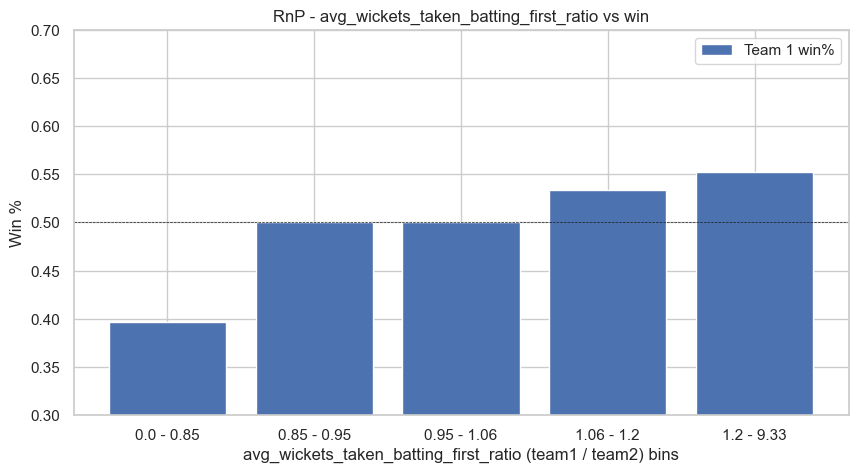

Correlation between avg_wickets_taken_batting_first_ratio and winner_01 is: -0.04510259271532462


In [146]:
createRnP(train_data, 'avg_wickets_taken_batting_first_ratio')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


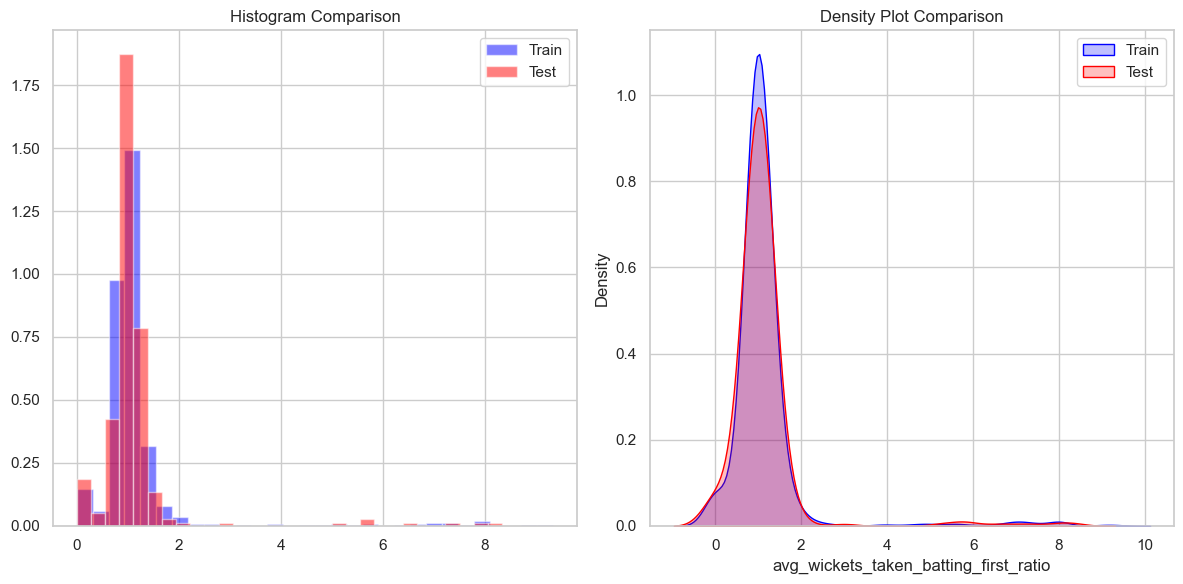

Kolmogorov-Smirnov test result: KS statistic = 0.0591, p-value = 0.4339

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.157780    1.128841
std       1.033151    0.986607
min       0.000000    0.000000
25%       0.880124    0.872984
50%       1.000000    1.015385
75%       1.165926    1.129166
max       9.333333    8.333333


In [147]:
check_distribution_match(train_data['avg_wickets_taken_batting_first_ratio'], test_data['avg_wickets_taken_batting_first_ratio'])

In [148]:
remove_skew(train_data, 'avg_wickets_taken_batting_first_ratio', method='quantile')
remove_skew(test_data, 'avg_wickets_taken_batting_first_ratio', method='quantile', train=False)

Skewness of avg_wickets_taken_batting_first_ratio was 5.19003093981409. quantile transformation applied. New skewness is -1.7158425887986999
Skewness of avg_wickets_taken_batting_first_ratio was 5.271726519259609. quantile transformation applied. New skewness is -1.914047404286299


/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2667: UserWarning: n_quantiles (1000) is greater than the total number of samples (948). n_quantiles is set to n_samples.
  warnings.warn(


5.

In [149]:
def team_win_rate_at_ground(team_id, ground_id, date, n):
    # Filter matches with specified team and ground, before the given date
    relevant_games = match_lvl_data[(match_lvl_data['match_dt'] < date) &
                                    ((match_lvl_data['team1_id'] == team_id) |
                                     (match_lvl_data['team2_id'] == team_id)) &
                                    (match_lvl_data['ground_id'] == ground_id)].sort_values(by='match_dt', ascending=False).head(n)

    # Calculate wins
    wins = relevant_games.apply(lambda x: 1 if x['winner_id'] == team_id else 0, axis=1).sum()

    # Calculate win rate
    if len(relevant_games) > 0:
        win_rate = wins / len(relevant_games)
    else:
        win_rate = 0  # No games to calculate from

    return win_rate

train_data['team1_win_rate_at_ground'] = train_data.progress_apply(lambda x:
                            team_win_rate_at_ground(x['team1_id'], x['ground_id'], x['match_dt'], 15), axis=1)
train_data['team2_win_rate_at_ground'] = train_data.progress_apply(lambda x:
                            team_win_rate_at_ground(x['team2_id'], x['ground_id'], x['match_dt'], 15), axis=1)

train_data = add_ratio_column(train_data, 'team1_win_rate_at_ground', 'team2_win_rate_at_ground', 'team_win_rate_at_ground')

train_data = train_data.drop(columns=['team1_win_rate_at_ground', 'team2_win_rate_at_ground'])

test_data['team1_win_rate_at_ground'] = test_data.progress_apply(lambda x:
                            team_win_rate_at_ground(x['team1_id'], x['ground_id'], x['match_dt'], 15), axis=1)
test_data['team2_win_rate_at_ground'] = test_data.progress_apply(lambda x:
                            team_win_rate_at_ground(x['team2_id'], x['ground_id'], x['match_dt'], 15), axis=1)

test_data = add_ratio_column(test_data, 'team1_win_rate_at_ground', 'team2_win_rate_at_ground', 'team_win_rate_at_ground')

test_data = test_data.drop(columns=['team1_win_rate_at_ground', 'team2_win_rate_at_ground'])

100%|██████████| 271/271 [00:00<00:00, 1286.55it/s]


slope: 0.56 / 0.47 =  1.2


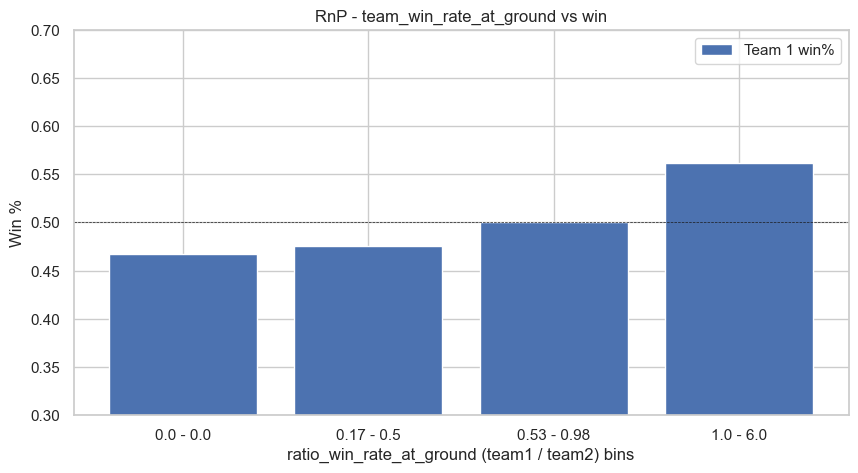

Correlation between team_win_rate_at_ground and winner_01 is: -0.05370441711356502


In [150]:
createRnP(train_data, 'team_win_rate_at_ground')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


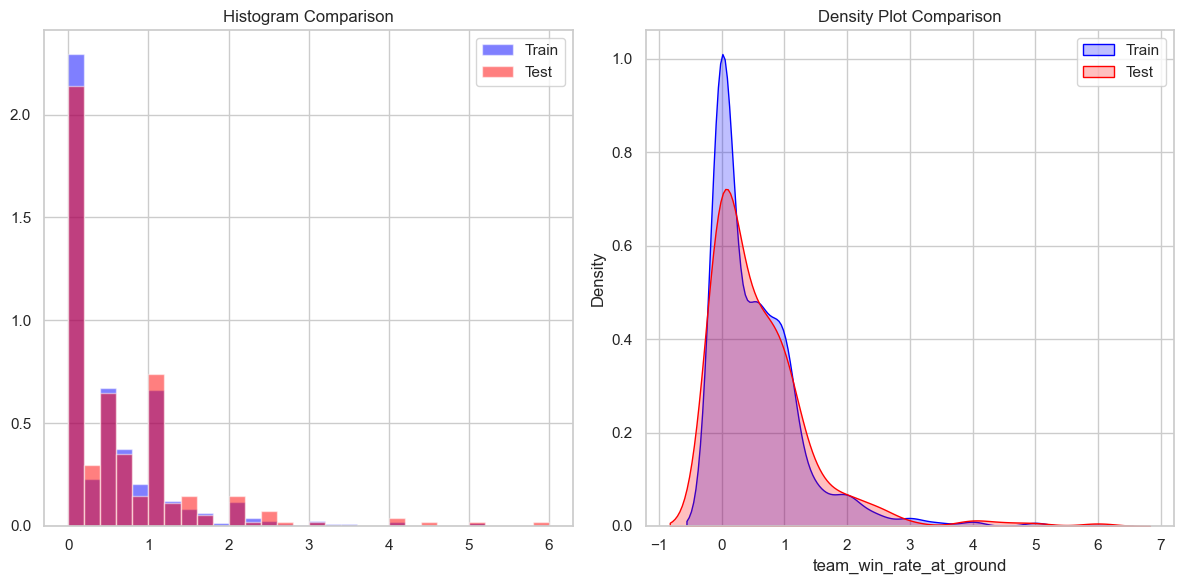

Kolmogorov-Smirnov test result: KS statistic = 0.0436, p-value = 0.7969

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      0.542720    0.610622
std       0.740211    0.848291
min       0.000000    0.000000
25%       0.000000    0.000000
50%       0.375000    0.428571
75%       0.937500    1.000000
max       6.000000    6.000000


In [151]:
check_distribution_match(train_data['team_win_rate_at_ground'], test_data['team_win_rate_at_ground'])

6.

In [152]:
def calculate_batsman_strike_rate(player_list, date, n):
    player_list = str(player_list).split(':')  # Split string of ':' separated ids into a list of ids
    res_list = []

    for player in player_list:
        recent_matches = giveLastNgamesPlayer(player_id=player, date=date, n=n, bat_or_bowl='bat')
        runs = recent_matches['runs'].sum()
        balls = recent_matches['balls_faced'].sum()

        # Calculate strike rate and avoid division by zero
        if balls > 0:
            strike_rate = (runs / balls) * 100
        else:
            strike_rate = 0

        res_list.append(strike_rate)

    # Calculate the average strike rate across all players in the list
    if res_list:  # Ensure the list is not empty to avoid division by zero
        average_strike_rate = sum(res_list) / len(res_list)
    else:
        average_strike_rate = 0

    return average_strike_rate

train_data['team1_strike_rate'] = train_data.progress_apply(lambda x: \
            calculate_batsman_strike_rate(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
train_data['team2_strike_rate'] = train_data.progress_apply(lambda x: \
            calculate_batsman_strike_rate(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

train_data = add_ratio_column(train_data, 'team1_strike_rate', 'team2_strike_rate', 'team_strike_rate')

train_data = train_data.drop(columns=['team1_strike_rate', 'team2_strike_rate'])

test_data['team1_strike_rate'] = test_data.progress_apply(lambda x: \
            calculate_batsman_strike_rate(player_list=x['team1_roster_ids'], date=x['match_dt'], n=15), axis=1)
test_data['team2_strike_rate'] = test_data.progress_apply(lambda x: \
            calculate_batsman_strike_rate(player_list=x['team2_roster_ids'], date=x['match_dt'], n=15), axis=1)

test_data = add_ratio_column(test_data, 'team1_strike_rate', 'team2_strike_rate', 'team_strike_rate')

test_data = test_data.drop(columns=['team1_strike_rate', 'team2_strike_rate'])

100%|██████████| 271/271 [00:04<00:00, 61.72it/s]


slope: 0.55 / 0.42 =  1.32


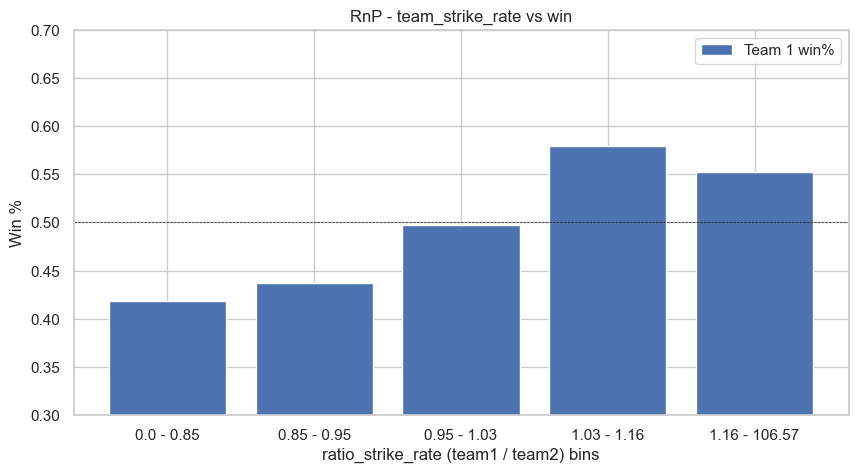

Correlation between team_strike_rate and winner_01 is: -0.046993779948201454


In [153]:
createRnP(train_data, 'team_strike_rate')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


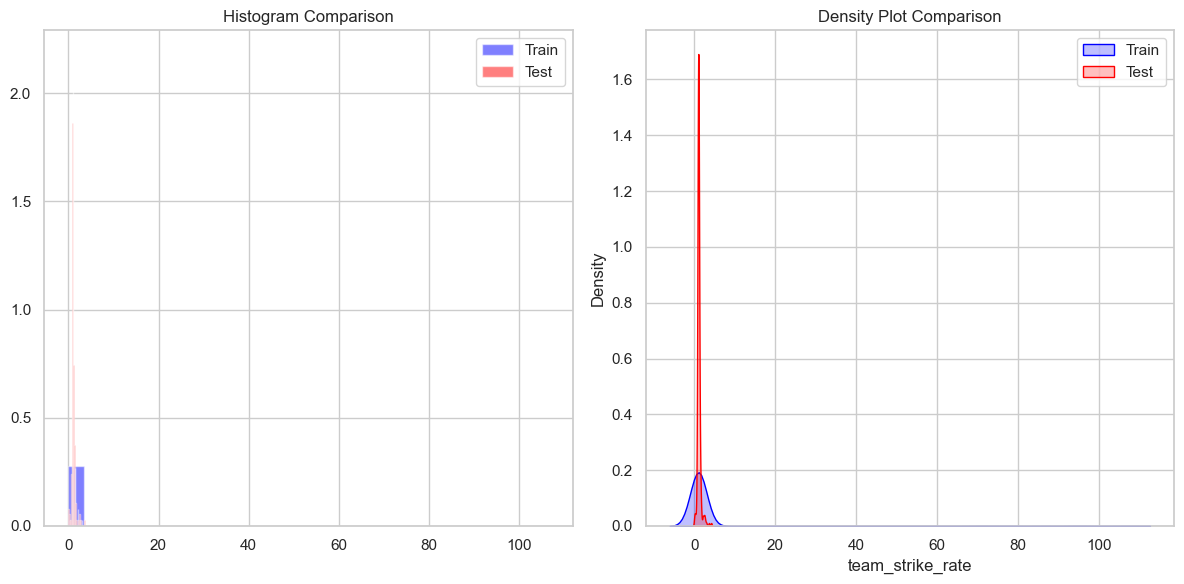

Kolmogorov-Smirnov test result: KS statistic = 0.0542, p-value = 0.5419

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.752818    1.056381
std       7.980454    0.426486
min       0.000000    0.000000
25%       0.887845    0.885572
50%       0.997539    0.998391
75%       1.115476    1.108754
max     106.574684    4.162338


In [154]:
check_distribution_match(train_data['team_strike_rate'], test_data['team_strike_rate'])

In [155]:
# train_data = handle_outliers(train_data, 'team_strike_rate')
# test_data = handle_outliers(test_data, 'team_strike_rate')

remove_skew(train_data, 'team_strike_rate', method='quantile')
remove_skew(test_data, 'team_strike_rate', method='quantile', train=False)

Skewness of team_strike_rate was 11.035006539460246. quantile transformation applied. New skewness is -0.9104786548959192
Skewness of team_strike_rate was 3.2116043492120885. quantile transformation applied. New skewness is -0.5673828578416706


/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2667: UserWarning: n_quantiles (1000) is greater than the total number of samples (948). n_quantiles is set to n_samples.
  warnings.warn(


7.

In [156]:
def scoring_variance_at_venue(match_lvl_data, team_id, venue, match_dt):
    scores = match_lvl_data[((match_lvl_data['venue'] == venue) &
                             ((match_lvl_data['team1_id'] == team_id) | (match_lvl_data['team2_id'] == team_id)) &
                             (match_lvl_data['match_dt'] < match_dt))].apply(
        lambda x: x['inning1_runs'] if x['team1_id'] == team_id else x['inning2_runs'],
        axis=1
    )
    if len(scores) > 1:
        return np.var(scores)
    return None  # Not applicable if fewer than 2 scores

train_data['team1_scoring_variance_at_venue'] = train_data.apply(
    lambda x: scoring_variance_at_venue(match_lvl_data, x['team1_id'], x['venue'], x['match_dt']),
    axis=1
)
train_data['team2_scoring_variance_at_venue'] = train_data.apply(
    lambda x: scoring_variance_at_venue(match_lvl_data, x['team2_id'], x['venue'], x['match_dt']),
    axis=1
)

train_data = add_ratio_column(train_data, 'team1_scoring_variance_at_venue', 'team2_scoring_variance_at_venue', 'team_scoring_variance_at_venue')

train_data = train_data.drop(columns=['team1_scoring_variance_at_venue', 'team2_scoring_variance_at_venue'])

test_data['team1_scoring_variance_at_venue'] = test_data.apply(
    lambda x: scoring_variance_at_venue(match_lvl_data, x['team1_id'], x['venue'], x['match_dt']),
    axis=1
)
test_data['team2_scoring_variance_at_venue'] = test_data.apply(
    lambda x: scoring_variance_at_venue(match_lvl_data, x['team2_id'], x['venue'], x['match_dt']),
    axis=1
)

test_data = add_ratio_column(test_data, 'team1_scoring_variance_at_venue', 'team2_scoring_variance_at_venue', 'team_scoring_variance_at_venue')

test_data = test_data.drop(columns=['team1_scoring_variance_at_venue', 'team2_scoring_variance_at_venue'])

slope: 0.67 / 0.42 =  1.6


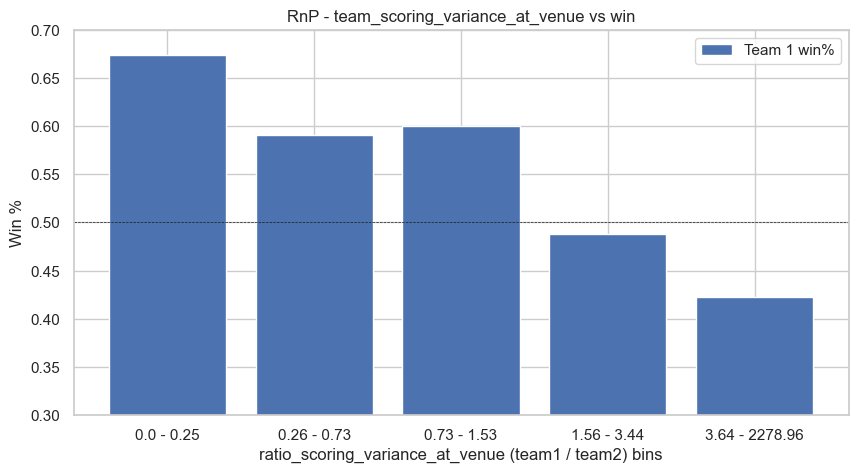

Correlation between team_scoring_variance_at_venue and winner_01 is: 0.07382813750939758


In [157]:
createRnP(train_data, 'team_scoring_variance_at_venue')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


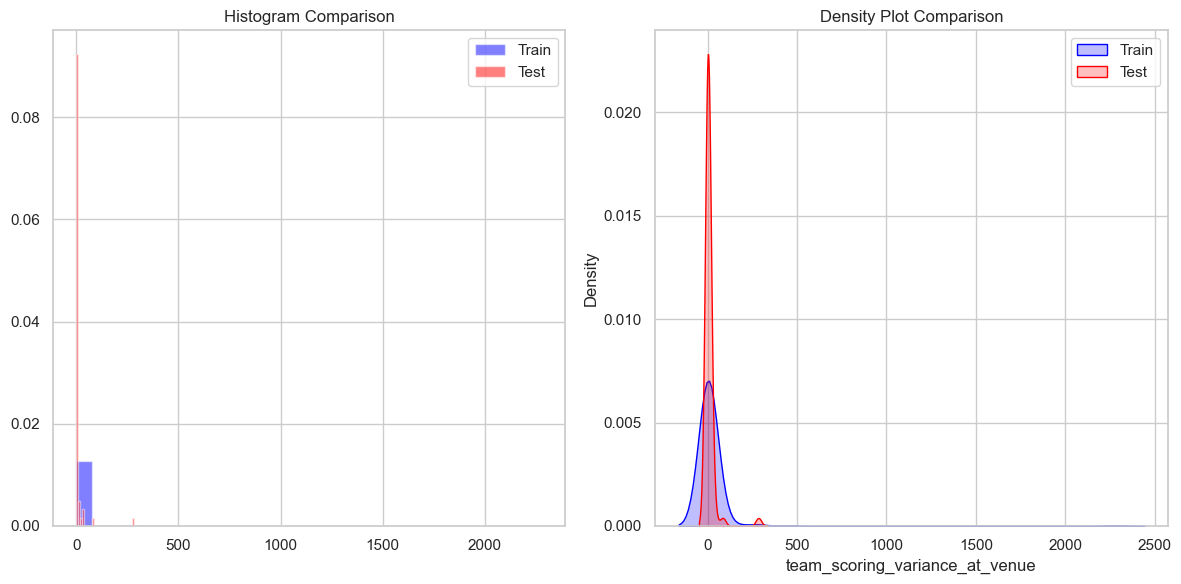

Kolmogorov-Smirnov test result: KS statistic = nan, p-value = nan

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   220.000000   64.000000
mean     20.670464    8.811408
std     159.135882   36.995710
min       0.002268    0.000000
25%       0.391702    0.410554
50%       1.154405    1.040817
75%       2.456717    2.601452
max    2278.958333  284.305556


In [158]:
check_distribution_match(train_data['team_scoring_variance_at_venue'], test_data['team_scoring_variance_at_venue'])

In [159]:
# train_data = handle_outliers(train_data, 'team_scoring_variance_at_venue')
# test_data = handle_outliers(test_data, 'team_scoring_variance_at_venue')

remove_skew(train_data, 'team_scoring_variance_at_venue', method='quantile')
remove_skew(test_data, 'team_scoring_variance_at_venue', method='quantile', train=False)

Skewness of team_scoring_variance_at_venue was 13.30455372357735. quantile transformation applied. New skewness is -0.35760963934232465
Skewness of team_scoring_variance_at_venue was 6.907818316072297. quantile transformation applied. New skewness is -1.452672829818567


/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2667: UserWarning: n_quantiles (1000) is greater than the total number of samples (948). n_quantiles is set to n_samples.
  warnings.warn(


## Model

In [160]:
train_data.columns

Index(['match id', 'team1', 'team1_id', 'team1_roster_ids', 'team2',
       'team2_id', 'team2_roster_ids', 'winner', 'winner_id', 'toss winner',
       'toss decision', 'venue', 'city', 'match_dt', 'lighting', 'series_name',
       'season', 'ground_id', 'team_count_50runs_last15', 'team_winp_last5',
       'team1only_avg_runs_last15', 'team1_winp_team2_last15',
       'ground_avg_runs_last15', 'winner_01', 'team_avg_score_ground_ratio',
       'avg_score_ground_batting_first_ratio', 'match_experience_score_ratio',
       'team_match_impact_score', 'team_balls_efficiency_score',
       'team_avg_wickets_top5_bowlers', 'team_extra_runs_conceded',
       'team_average_dots_per_match', 'team_bowler_performance_ratio',
       'team_avg_wicket', 'team_batting_strength', 'team_momentum',
       'team_batsman_performance_recent', 'team_pom_frequency',
       'team_count_100runs_ratio_last15', 'team_win_percentage_fielding_first',
       'team_wicket_loss_average', 'team_win_rate_at_venue',
 

col = ['team_avg_score_ground_ratio',
       'avg_score_ground_batting_first_ratio', 'match_experience_score_ratio',
       'team_match_impact_score', 'team_balls_efficiency_score',
       'team_avg_wickets_top5_bowlers', 'team_extra_runs_conceded',
       'team_average_dots_per_match', 'team_wicket_loss_average',
       'team_bowler_performance_ratio', 'team_avg_wicket',
       'team_batting_strength', 'team_win_rate_at_venue',
       'team_batsman_performance_index', 'team_overall_win_rate',
       'team_momentum', 'team_batsman_performance_recent',
       'team_pom_frequency', 'team_count_100runs_ratio_last15',
       'team_win_percentage_fielding_first', 'team_avg_win_margin_runs',
       'team_winp_venue', 'winner_01']

In [235]:
## 68% accuracy 61% 0
# col = ['team_avg_score_ground_ratio', 'team_count_50runs_last15', 
#        'avg_score_ground_batting_first_ratio', 'match_experience_score_ratio',
#        'team_match_impact_score', 'team_balls_efficiency_score',
#        'team_avg_wickets_top5_bowlers', 'team_extra_runs_conceded',
#        'team_average_dots_per_match', 'team_bowler_performance_ratio',
#        'team_avg_wicket', 'team_batting_strength', 'team_momentum',
#        'team_batsman_performance_recent', 'team_pom_frequency',
#        'team_count_100runs_ratio_last15',
#        'team_win_percentage_fielding_first', 'winner_01']

col = ['team_avg_score_ground_ratio',
       'avg_score_ground_batting_first_ratio', 'match_experience_score_ratio',
       'team_match_impact_score', 'team_balls_efficiency_score',
       'team_avg_wickets_top5_bowlers', 'team_extra_runs_conceded',
       'team_average_dots_per_match', 'team_wicket_loss_average',
       'team_bowler_performance_ratio', 'team_avg_wicket',
       'team_batting_strength', 'team_win_rate_at_venue',
       'team_batsman_performance_index', 'team_overall_win_rate',
       'team_momentum', 'team_batsman_performance_recent',
       'team_pom_frequency', 'team_count_100runs_ratio_last15',
       'team_win_percentage_fielding_first', 'team_avg_win_margin_runs',
       'team_winp_venue', 'winner_01']

# col = ['team_avg_score_ground_ratio','team_count_50runs_last15',
#        'avg_score_ground_batting_first_ratio', 'match_experience_score_ratio',
#        'team_match_impact_score', 'team_balls_efficiency_score',
#        'team_avg_wickets_top5_bowlers', 'team_extra_runs_conceded',
#        'team_average_dots_per_match', 'team_bowler_performance_ratio',
#        'team_avg_wicket', 'team_batting_strength', 'team_momentum',
#        'team_batsman_performance_recent', 'team_pom_frequency',
#        'team_count_100runs_ratio_last15', 'team_win_percentage_fielding_first',
#        'team_wicket_loss_average', 'team_win_rate_at_venue',
#        'team_batsman_performance_index', 'team_overall_win_rate',
#        'team_avg_win_margin_runs', 'team_winp_venue', 'toss_winner_id',
#        'bat_id', 'team_avg_runs_1st_inning', 'team_avg_eco',
#        'consistency_index_ratio', 'avg_wickets_taken_batting_first_ratio',
#        'team_win_rate_at_ground', 'team_strike_rate',
#        'team_scoring_variance_at_venue', 'winner_01']

In [236]:
df = train_data[col]

In [237]:
df.corr()['winner_01'].sort_values()

team_win_percentage_fielding_first     -0.219447
match_experience_score_ratio           -0.219131
team_avg_score_ground_ratio            -0.212361
avg_score_ground_batting_first_ratio   -0.203732
team_match_impact_score                -0.195274
team_batting_strength                  -0.190013
team_avg_wickets_top5_bowlers          -0.169015
team_bowler_performance_ratio          -0.166911
team_batsman_performance_recent        -0.160832
team_balls_efficiency_score            -0.159139
team_avg_wicket                        -0.157641
team_pom_frequency                     -0.157227
team_count_100runs_ratio_last15        -0.146283
team_batsman_performance_index         -0.110905
team_average_dots_per_match            -0.107916
team_winp_venue                        -0.097938
team_momentum                          -0.097423
team_extra_runs_conceded               -0.090836
team_overall_win_rate                  -0.089531
team_avg_win_margin_runs               -0.067452
team_win_rate_at_ven

In [238]:
df.fillna(0, inplace=True)

/var/folders/z7/t3qmw89j637f4y58ls6cb_vh0000gn/T/ipykernel_50413/4231983114.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(0, inplace=True)


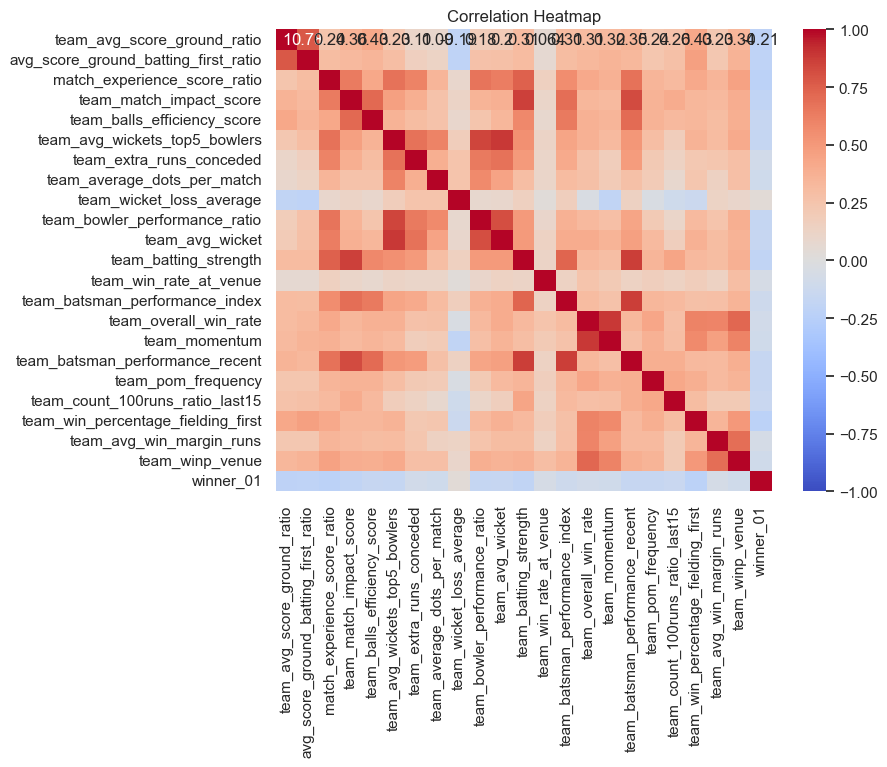

In [239]:
corr_matrix = df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

In [240]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop('winner_01', axis=1)
y = df['winner_01']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [241]:
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

# Assuming X_train, y_train, X_test, y_test are defined

# Initialize models
GBM_model = GradientBoostingClassifier()
LGBM_model = LGBMClassifier()
XGB_model = XGBClassifier()
CatBoost_model = CatBoostClassifier()

# Train the models
GBM_model.fit(X_train, y_train)
LGBM_model.fit(X_train, y_train)
XGB_model.fit(X_train, y_train)
CatBoost_model.fit(X_train, y_train)

# Make predictions on test set
y_pred_GBM_test = GBM_model.predict(X_test)
y_pred_LGBM_test = LGBM_model.predict(X_test)
y_pred_XGB_test = XGB_model.predict(X_test)
y_pred_CatBoost_test = CatBoost_model.predict(X_test)

# Make predictions on train set
y_pred_GBM_train = GBM_model.predict(X_train)
y_pred_LGBM_train = LGBM_model.predict(X_train)
y_pred_XGB_train = XGB_model.predict(X_train)
y_pred_CatBoost_train = CatBoost_model.predict(X_train)

# Evaluate models on test data
accuracy_GBM_test = accuracy_score(y_test, y_pred_GBM_test)
accuracy_LGBM_test = accuracy_score(y_test, y_pred_LGBM_test)
accuracy_XGB_test = accuracy_score(y_test, y_pred_XGB_test)
accuracy_CatBoost_test = accuracy_score(y_test, y_pred_CatBoost_test)

# Evaluate models on train data
accuracy_GBM_train = accuracy_score(y_train, y_pred_GBM_train)
accuracy_LGBM_train = accuracy_score(y_train, y_pred_LGBM_train)
accuracy_XGB_train = accuracy_score(y_train, y_pred_XGB_train)
accuracy_CatBoost_train = accuracy_score(y_train, y_pred_CatBoost_train)

# Print accuracies
print("Accuracy for GBM model on training data:", accuracy_GBM_train)
print("Accuracy for GBM model on testing data:", accuracy_GBM_test)
print('====================================================================')
print("Accuracy for LGBM model on training data:", accuracy_LGBM_train)
print("Accuracy for LGBM model on testing data:", accuracy_LGBM_test)
print('====================================================================')
print("Accuracy for XGB model on training data:", accuracy_XGB_train)
print("Accuracy for XGB model on testing data:", accuracy_XGB_test)
print('====================================================================')
print("Accuracy for CatBoost model on training data:", accuracy_CatBoost_train)
print("Accuracy for CatBoost model on testing data:", accuracy_CatBoost_test)

[LightGBM] [Info] Number of positive: 432, number of negative: 421
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5208
[LightGBM] [Info] Number of data points in the train set: 853, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506448 -> initscore=0.025793
[LightGBM] [Info] Start training from score 0.025793
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Learning rate set to 0.009626
0:	learn: 0.6914701	total: 3.65ms	remaining: 3.64s
1:	learn: 0.6902099	total: 5.5ms	remaining: 2.75s
2:	learn: 0.6891764	total: 7.06ms	remaining: 2.35s
3:	learn: 0.6878794	total: 8.64ms	remaining: 2.15s
4:	learn: 0.6864445	total: 10.2ms	remaining: 2.02s
5:	learn: 0.6851251	total: 11.9ms	remaining: 1.97s
6:	learn: 0.6838386	total: 13.4ms	remaining: 1.9s
7:	learn: 0.6828205	total: 14.8ms	remaining: 1.84s
8:	

In [242]:
import optuna
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score

# Assuming X_train, y_train, X_test, and y_test are already defined
train_pool = Pool(data=X_train, label=y_train)
valid_pool = Pool(data=X_test, label=y_test)

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'depth': trial.suggest_int('depth', 4, 12),  # Increased upper limit
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 200.0),  # Wider range
        'border_count': trial.suggest_int('border_count', 32, 255),
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 10.0),  # Wider range for more exploration
        'random_strength': trial.suggest_loguniform('random_strength', 1e-2, 100.0),  # Wider range
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'od_wait': trial.suggest_int('od_wait', 20, 100),  # Increased upper limit
        'verbose': 0  # Suppress output for tuning
    }
    
    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50)
    
    preds = model.predict(valid_pool)
    accuracy = accuracy_score(y_test, preds)
    
    return accuracy  # Aim to maximize accuracy

# Create and run the Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # Reduced number of trials for quicker experimentation

# Get the best parameters
best_params = study.best_params
print(f"Best parameters: {best_params}")

# Train the final model with the best parameters
best_model = CatBoostClassifier(**best_params, verbose=100)
best_model.fit(X_train, y_train, eval_set=(X_test, y_test))

# Evaluate the final model on the validation set
final_preds = best_model.predict(X_test)
final_accuracy = accuracy_score(y_test, final_preds)
print(final_accuracy)

[I 2024-06-12 00:16:53,085] A new study created in memory with name: no-name-40631d7a-1adb-4a56-a239-42699931a73d
/var/folders/z7/t3qmw89j637f4y58ls6cb_vh0000gn/T/ipykernel_50413/2137102577.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
/var/folders/z7/t3qmw89j637f4y58ls6cb_vh0000gn/T/ipykernel_50413/2137102577.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 200.0),  # Wider range
/var/folders/z7/t3qmw89j637f4y58ls6cb_vh0000gn/T/ipykernel_50413/2137102577.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Th

Best parameters: {'iterations': 482, 'learning_rate': 0.00010078700348561568, 'depth': 4, 'l2_leaf_reg': 23.08584687309742, 'border_count': 167, 'bagging_temperature': 0.01010367729869837, 'random_strength': 0.04223001734202825, 'od_type': 'Iter', 'od_wait': 81}
0:	learn: 0.6931320	test: 0.6931346	best: 0.6931346 (0)	total: 1.4ms	remaining: 675ms
100:	learn: 0.6919064	test: 0.6920264	best: 0.6920264 (100)	total: 87.5ms	remaining: 330ms
200:	learn: 0.6907056	test: 0.6909562	best: 0.6909562 (200)	total: 180ms	remaining: 251ms
300:	learn: 0.6895168	test: 0.6898969	best: 0.6898969 (300)	total: 291ms	remaining: 175ms
400:	learn: 0.6883412	test: 0.6888638	best: 0.6888638 (400)	total: 395ms	remaining: 79.8ms
481:	learn: 0.6874031	test: 0.6880635	best: 0.6880635 (481)	total: 472ms	remaining: 0us

bestTest = 0.6880634813
bestIteration = 481

0.6947368421052632


In [243]:
pred_train = best_model.predict(X_train)
accuracy_score(y_train, pred_train)

0.6588511137162955

In [244]:
# import optuna
# from catboost import Pool
# train_pool = Pool(data=X_train, label=y_train)
# valid_pool = Pool(data=X_test, label=y_test)

# # Define the objective function for hyperparameter tuning
# def objective(trial):
#     params = {
#         'iterations': trial.suggest_int('iterations', 100, 1000),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
#         'depth': trial.suggest_int('depth', 4, 10),
#         'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
#         'border_count': trial.suggest_int('border_count', 32, 255),
#         'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 1.0),
#         'random_strength': trial.suggest_loguniform('random_strength', 1e-3, 10.0),
#         'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
#         'od_wait': trial.suggest_int('od_wait', 10, 50),
#         'verbose': 0  # Suppress output for tuning
#     }
    
#     model = CatBoostClassifier(**params)
#     model.fit(train_pool)
#     preds = model.predict(valid_pool)
#     accuracy = accuracy_score(y_test, preds)
    
#     return -accuracy  # Minimize the negative accuracy

# # Create and run the Optuna study
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

# # Get the best parameters
# best_params = study.best_params
# print(f"Best parameters: {best_params}")

# # Train the final model with the best parameters
# best_model = CatBoostClassifier(
#     iterations=best_params['iterations'],
#     learning_rate=best_params['learning_rate'],
#     depth=best_params['depth'],
#     l2_leaf_reg=best_params['l2_leaf_reg'],
#     border_count=best_params['border_count'],
#     bagging_temperature=best_params['bagging_temperature'],
#     random_strength=best_params['random_strength'],
#     od_type=best_params['od_type'],
#     od_wait=best_params['od_wait'],
#     verbose=100  # To monitor the training process
# )

# best_model.fit(X_train, y_train)

# # Evaluate the final model on the validation set
# final_preds = best_model.predict(X_test)
# final_accuracy = accuracy_score(y_test, final_preds)
# print(final_accuracy)

In [245]:
pred_train = best_model.predict(X_train)
accuracy_score(y_train, pred_train)

0.6588511137162955

## Test

In [246]:
df_test = test_data[col[:-1]]

In [247]:
len(col)

23

In [248]:
X.shape, df_test.shape

((948, 22), (271, 22))

In [249]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
test_X = scaler.transform(df_test)

In [250]:
best_model.fit(X, y)

0:	learn: 0.6931339	total: 1.59ms	remaining: 766ms
100:	learn: 0.6918539	total: 107ms	remaining: 405ms
200:	learn: 0.6906010	total: 208ms	remaining: 290ms
300:	learn: 0.6893654	total: 303ms	remaining: 182ms
400:	learn: 0.6881383	total: 393ms	remaining: 79.4ms
481:	learn: 0.6871532	total: 462ms	remaining: 0us


In [251]:
pred = best_model.predict(X)
accuracy_score(y, pred)

0.6561181434599156

In [252]:
pred_test = best_model.predict(test_X)

In [253]:
pred_test

array([1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0])

In [254]:
def count_zeros(y_test):
    total_elements = len(y_test)
    count_zeros = np.sum(y_test == 0)
    percentage_zeros = (count_zeros / total_elements) * 100
    return percentage_zeros

print(f"Percentage of zeros in the test set: {count_zeros(pred_test)}%")

Percentage of zeros in the test set: 62.73062730627307%


In [255]:
# import optuna
# import lightgbm as lgb
# from sklearn.metrics import accuracy_score
# from sklearn.model_selection import train_test_split

# train_pool = lgb.Dataset(X_train, label=y_train)
# valid_pool = lgb.Dataset(X_test, label=y_test, reference=train_data)

# def objective(trial):
#     param = {
#         'objective': 'binary',  # or 'multiclass' for multi-class classification
#         'metric': 'binary_logloss',  # or 'multi_logloss' for multi-class classification
#         'verbosity': -1,
#         'boosting_type': 'gbdt',
#         'num_leaves': trial.suggest_int('num_leaves', 31, 256),
#         'max_bin': trial.suggest_int('max_bin', 200, 300),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
#         'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e2),
#         'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 500),
#         'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
#         'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
#         'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
#         'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
#         'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
#     }

#     model = lgb.train(param, train_pool, valid_sets=[valid_pool])
#     preds = model.predict(X_test)
#     pred_labels = np.rint(preds)  # Round predictions to the nearest integer
#     accuracy = accuracy_score(y_test, pred_labels)
#     return -accuracy  # Minimize the negative accuracy

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

# best_params = study.best_params
# print(f"Best parameters: {best_params}")

# # Train the final model with the best parameters
# final_model = lgb.train({**best_params, 'objective': 'binary', 'metric': 'binary_logloss'},
#                         train_pool,
#                         valid_sets=[valid_pool])

# # Evaluate the final model on the validation set
# final_preds = final_model.predict(X_test)
# final_pred_labels = np.rint(final_preds)  # Round predictions to the nearest integer
# final_accuracy = accuracy_score(y_test, final_pred_labels)
# print(f"Final accuracy: {final_accuracy}")

In [256]:
# X_train.shape

In [257]:
# train_data.columns

In [262]:
col = ['team_count_50runs_last15', 'team_winp_last5',
       'team1only_avg_runs_last15', 'team1_winp_team2_last15',
       'ground_avg_runs_last15', 'team_avg_score_ground_ratio',
       'avg_score_ground_batting_first_ratio', 'match_experience_score_ratio',
       'team_match_impact_score', 'team_balls_efficiency_score',
       'team_avg_wickets_top5_bowlers', 'team_extra_runs_conceded',
       'team_average_dots_per_match', 'team_bowler_performance_ratio',
       'team_avg_wicket', 'team_batting_strength', 'team_momentum',
       'team_batsman_performance_recent', 'team_pom_frequency',
       'team_count_100runs_ratio_last15', 'team_win_percentage_fielding_first',
       'team_wicket_loss_average', 'team_win_rate_at_venue',
       'team_batsman_performance_index', 'team_overall_win_rate',
       'team_avg_win_margin_runs', 'team_winp_venue', 'toss_winner_id',
       'bat_id', 'team_avg_runs_1st_inning', 'team_avg_eco',
       'consistency_index_ratio', 'avg_wickets_taken_batting_first_ratio',
       'team_win_rate_at_ground', 'team_strike_rate', 'winner_01']

In [263]:
train_data = train_data[col]
test_data = test_data[col[:-1]]

In [264]:
train_data.shape

(948, 36)

In [265]:
train_data.to_csv('train_data_outlier.csv', index=False)
test_data.to_csv('test_data_outlier.csv', index=False)